In [340]:
library("tidyverse")
library("DT")
library("ggplot2")
library("dplyr")
library(cluster)
library(pheatmap)
library(tigris)
library(sf)
library(geojsonio)
library(corrplot)
library("ggrepel")
library("ggcorrplot")
library(factoextra )
library(cmeans)

ERROR: Error in library(cmeans): there is no package called 'cmeans'


In [341]:
install.packages("cmeans")

Installing package into 'C:/Users/Nick/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

Warning message:
"package 'cmeans' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


In [342]:
snapshot_urlfile = "https://raw.githubusercontent.com/ncliu95/smu_dm_project_2/main/texas_snapshot_with_census_pol.csv"

In [343]:
snapshot_cases <- read_csv(url(snapshot_urlfile))

Rows: 254 Columns: 270
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (9): county_name.x, state.x, state.y, state_po, county_name.y, office...
dbl  (250): county_fips_code, state_fips_code, confirmed_cases, deaths, geo_...
lgl   (10): pop_5_years_over, speak_only_english_at_home, speak_spanish_at_h...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [344]:
snapshot_cases <- snapshot_cases %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases,
    hispanic_ratio = hispanic_pop/total_pop,
    percent_male_pop = male_pop/total_pop,
    percent_female_pop = female_pop/total_pop,
    white_ratio = white_pop/total_pop,
    black_ratio = black_pop/total_pop,
    asian_ratio = asian_pop/total_pop,
    amerindian_ratio = amerindian_pop/total_pop,
    other_race_ratio = other_race_pop/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_employed_agriculture_forestry_fishing_hunting_mining = employed_agriculture_forestry_fishing_hunting_mining/total_pop,
    percent_employed_arts_entertainment_recreation_accommodation_food = employed_arts_entertainment_recreation_accommodation_food/total_pop,
    percent_employed_construction = employed_construction/total_pop,
    percent_employed_education_health_social = employed_education_health_social/total_pop,
    percent_employed_finance_insurance_real_estate = employed_finance_insurance_real_estate/total_pop,
    percent_employed_information = employed_information/total_pop,
    percent_employed_manufacturing = employed_manufacturing/total_pop,
    percent_employed_other_services_not_public_admin = employed_other_services_not_public_admin/total_pop,
    percent_employed_public_administration = employed_public_administration/total_pop,
    percent_employed_retail_trade = employed_retail_trade/total_pop,
    percent_employed_science_management_admin_waste = employed_science_management_admin_waste/total_pop,
    percent_employed_transportation_warehousing_utilities = employed_transportation_warehousing_utilities/total_pop,
    percent_employed_wholesale_trade = employed_wholesale_trade/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_commute_by_bus = commuters_by_bus/employed_pop,
    percent_commute_by_car_truck_van = commuters_by_car_truck_van/employed_pop,
    percent_commute_by_carpool = commuters_by_carpool/employed_pop,
    percent_commute_by_subway = commuters_by_subway_or_elevated/employed_pop,
    percent_commute_by_driving_alone = commuters_drove_alone/employed_pop,
    percent_wfh = worked_at_home/employed_pop
)

In [345]:
# Download county data for Texas
tx_counties <- counties(state = "TX")
tx_counties$GEOID <- as.numeric(tx_counties$GEOID)
snapshot_cases <- left_join(snapshot_cases, tx_counties[, c("GEOID", "ALAND")], by = c("county_fips_code" = "GEOID"))
snapshot_cases <- snapshot_cases %>% mutate(
  pop_density = total_pop/ALAND)
    

Retrieving data for the year 2021



In [346]:
data <- select(snapshot_cases, 
                  'county_name.x',
'median_income',
'cases_per_1000',
'deaths_per_1000',
'death_per_case',
'hispanic_ratio',
'pop_density',
'party',
'median_age',
'poverty',
'bachelors_degree',   
'commuters_by_public_transportation',
'percent_male_pop',
'percent_female_pop',
'median_age',
'median_rent',
'white_ratio',
'black_ratio',
'asian_ratio',
'amerindian_ratio',
'other_race_ratio',
'percent_employed_agriculture_forestry_fishing_hunting_mining',
'percent_employed_arts_entertainment_recreation_accommodation_food', 
'percent_employed_construction' ,
'percent_employed_education_health_social',
'percent_employed_finance_insurance_real_estate',
'percent_employed_information', 
'percent_employed_manufacturing', 
'percent_employed_other_services_not_public_admin',
'percent_employed_public_administration',
'percent_employed_retail_trade',
'percent_employed_science_management_admin_waste',
'percent_employed_transportation_warehousing_utilities',
'percent_employed_wholesale_trade',
'percent_unemployed',
'percent_children',
 'percent_commute_by_bus',
'percent_commute_by_car_truck_van',
'percent_commute_by_carpool',
'percent_commute_by_subway',
'percent_commute_by_driving_alone',
'percent_wfh'             )

In [347]:
data <- data %>% mutate(party = ifelse(party == "REPUBLICAN", 0, 1))

In [348]:
exclude_cols <- c(
    'cases_per_1000',
'deaths_per_1000',
'death_per_case')
data_temp <- data[, -which(names(data) %in% exclude_cols)]

# Select the numeric columns in the data frame
num_cols <- sapply(data_temp, is.numeric)
# Apply the scale() function to the numeric columns
data_temp[num_cols] <- scale(data_temp[num_cols])

data_updated <- cbind(data_temp, data[, which(names(data) %in% exclude_cols)])
data <- data_updated

In [350]:
# Socioeconomic Indicators:
se_data <- subset(data, select = c(county_name.x, cases_per_1000, deaths_per_1000, death_per_case, median_income, poverty, median_rent, percent_employed_agriculture_forestry_fishing_hunting_mining, percent_employed_arts_entertainment_recreation_accommodation_food, percent_employed_construction, percent_employed_education_health_social, percent_employed_finance_insurance_real_estate, percent_employed_information, percent_employed_manufacturing, percent_employed_other_services_not_public_admin, percent_employed_public_administration, percent_employed_retail_trade, percent_employed_science_management_admin_waste, percent_employed_transportation_warehousing_utilities, percent_employed_wholesale_trade, percent_unemployed))
write.csv(se_data, "socioeconomic_feature_set.csv")
colnames(se_data)

[1] "county_name.x"                                                    
 [2] "cases_per_1000"                                                   
 [3] "deaths_per_1000"                                                  
 [4] "death_per_case"                                                   
 [5] "median_income"                                                    
 [6] "poverty"                                                          
 [7] "median_rent"                                                      
 [8] "percent_employed_agriculture_forestry_fishing_hunting_mining"     
 [9] "percent_employed_arts_entertainment_recreation_accommodation_food"
[10] "percent_employed_construction"                                    
[11] "percent_employed_education_health_social"                         
[12] "percent_employed_finance_insurance_real_estate"                   
[13] "percent_employed_information"                                     
[14] "percent_employed_manufacturing"                                   
[15] "percent_employed_other_services_not_public_admin"                 
[16] "percent_employed_public_administration"                           
[17] "percent_employed_retail_trade"                                    
[18] "percent_employed_science_management_admin_waste"                  
[19] "percent_employed_transportation_warehousing_utilities"            
[20] "percent_employed_wholesale_trade"                                 
[21] "percent_unemployed"

In [351]:
#  Demographic Indicators
demo_data <- subset(data, select = c(    
    county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    hispanic_ratio,
    median_age,
    bachelors_degree,
    percent_male_pop,
    percent_female_pop,
    white_ratio,
    black_ratio,
    asian_ratio,
    amerindian_ratio,
    other_race_ratio,
    percent_children))
write.csv(demo_data, "demographic_feature_set.csv")
colnames(demo_data)

[1] "county_name.x"      "cases_per_1000"     "deaths_per_1000"   
 [4] "death_per_case"     "hispanic_ratio"     "median_age"        
 [7] "bachelors_degree"   "percent_male_pop"   "percent_female_pop"
[10] "white_ratio"        "black_ratio"        "asian_ratio"       
[13] "amerindian_ratio"   "other_race_ratio"   "percent_children"

In [352]:
#  Transportation Metrics
transport_data <- subset(data, select = c(
county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    pop_density,
    commuters_by_public_transportation,
    percent_commute_by_bus,
    percent_commute_by_car_truck_van,
    percent_commute_by_carpool,
    percent_commute_by_subway,
    percent_commute_by_driving_alone,
    percent_wfh)
)
write.csv(transport_data, "transportation_feature_set.csv")
colnames(transport_data)

[1] "county_name.x"                      "cases_per_1000"                    
 [3] "deaths_per_1000"                    "death_per_case"                    
 [5] "pop_density"                        "commuters_by_public_transportation"
 [7] "percent_commute_by_bus"             "percent_commute_by_car_truck_van"  
 [9] "percent_commute_by_carpool"         "percent_commute_by_subway"         
[11] "percent_commute_by_driving_alone"   "percent_wfh"

In [353]:
#  Employment and Industry Indicators
emp_data <- subset(data, select = c(
    county_name.x,
    cases_per_1000,
    deaths_per_1000,
    death_per_case,
    percent_employed_agriculture_forestry_fishing_hunting_mining,
    percent_employed_arts_entertainment_recreation_accommodation_food,
    percent_employed_construction,
    percent_employed_education_health_social,
    percent_employed_finance_insurance_real_estate,
    percent_employed_information,
    percent_employed_manufacturing,
    percent_employed_other_services_not_public_admin,
    percent_employed_public_administration,
    percent_employed_retail_trade,
    percent_employed_science_management_admin_waste,
    percent_employed_transportation_warehousing_utilities,
    percent_employed_wholesale_trade,
    percent_unemployed)
)
write.csv(emp_data, "employment_and_industry_feature_set.csv")
colnames(emp_data)

[1] "county_name.x"                                                    
 [2] "cases_per_1000"                                                   
 [3] "deaths_per_1000"                                                  
 [4] "death_per_case"                                                   
 [5] "percent_employed_agriculture_forestry_fishing_hunting_mining"     
 [6] "percent_employed_arts_entertainment_recreation_accommodation_food"
 [7] "percent_employed_construction"                                    
 [8] "percent_employed_education_health_social"                         
 [9] "percent_employed_finance_insurance_real_estate"                   
[10] "percent_employed_information"                                     
[11] "percent_employed_manufacturing"                                   
[12] "percent_employed_other_services_not_public_admin"                 
[13] "percent_employed_public_administration"                           
[14] "percent_employed_retail_trade"                                    
[15] "percent_employed_science_management_admin_waste"                  
[16] "percent_employed_transportation_warehousing_utilities"            
[17] "percent_employed_wholesale_trade"                                 
[18] "percent_unemployed"

#  Socioeconomic Indicators Dataset

### K - means Clustering

In [124]:
county_names <- se_data$county_name.x
se_data_prepped <- se_data[, !(colnames(se_data) %in% c("county_name.x", "cases_per_1000", "deaths_per_1000", "death_per_case"))]

In [131]:
set.seed(123)
km <- kmeans(se_data_prepped, centers = 4)
km

K-means clustering with 4 clusters of sizes 54, 74, 101, 25

Cluster means:
  median_income     poverty median_rent
1    0.22214989 -0.22374597  -0.3441248
2   -0.75957607 -0.18754072  -0.6629317
3    0.07236232 -0.09898131   0.1667856
4    1.47615762  1.43829631   2.0317736
  percent_employed_agriculture_forestry_fishing_hunting_mining
1                                                   1.38320347
2                                                  -0.08313192
3                                                  -0.45772614
4                                                  -0.89243539
  percent_employed_arts_entertainment_recreation_accommodation_food
1                                                        -0.4794679
2                                                        -0.1867445
3                                                         0.1619325
4                                                         0.9342070
  percent_employed_construction percent_employed_education_health_soc

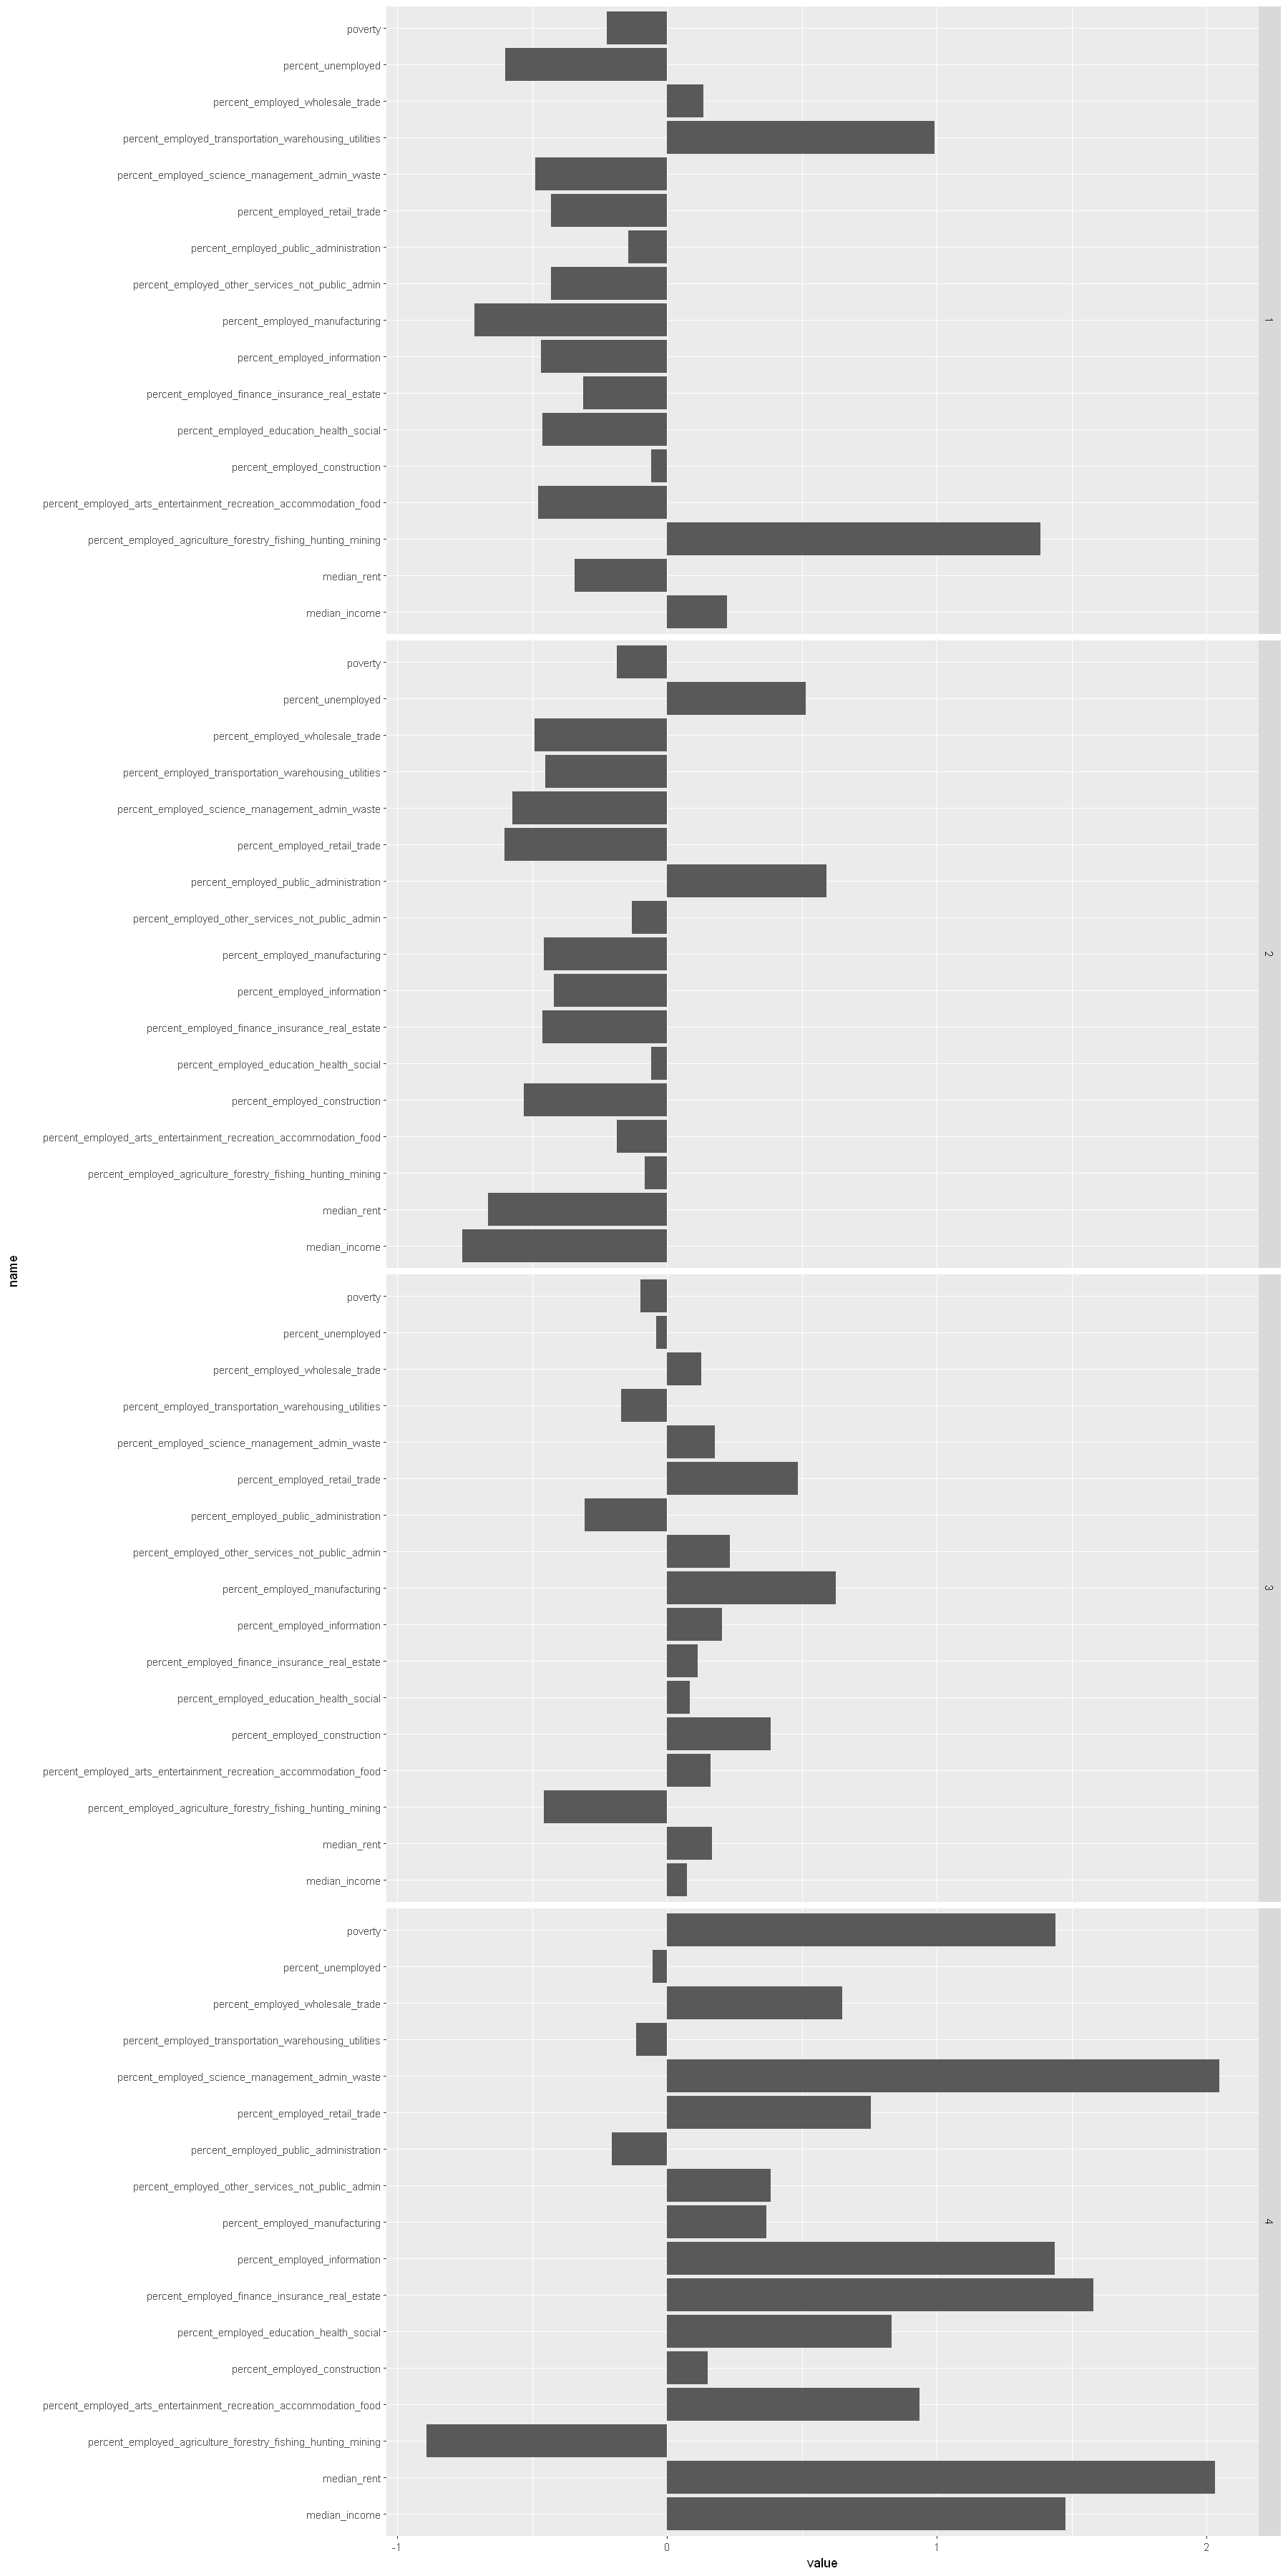

In [132]:
options(repr.plot.width = 15, repr.plot.height = 30)
ggplot(pivot_longer(as_tibble(km$centers,  rownames = "cluster"), 
  cols = colnames(km$centers)), 
  aes(y = name, x = value)) +
  geom_bar(stat = "identity") +
  facet_grid(rows = vars(cluster))

In [133]:
counties <- as_tibble(map_data("county"))
counties_TX <- counties %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion))

In [134]:
se_data <- se_data %>% mutate(county = county_name.x %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

counties_TX_clust <- counties_TX %>% left_join(se_data %>% 
    add_column(cluster = factor(km$cluster)))

Joining, by = "county"


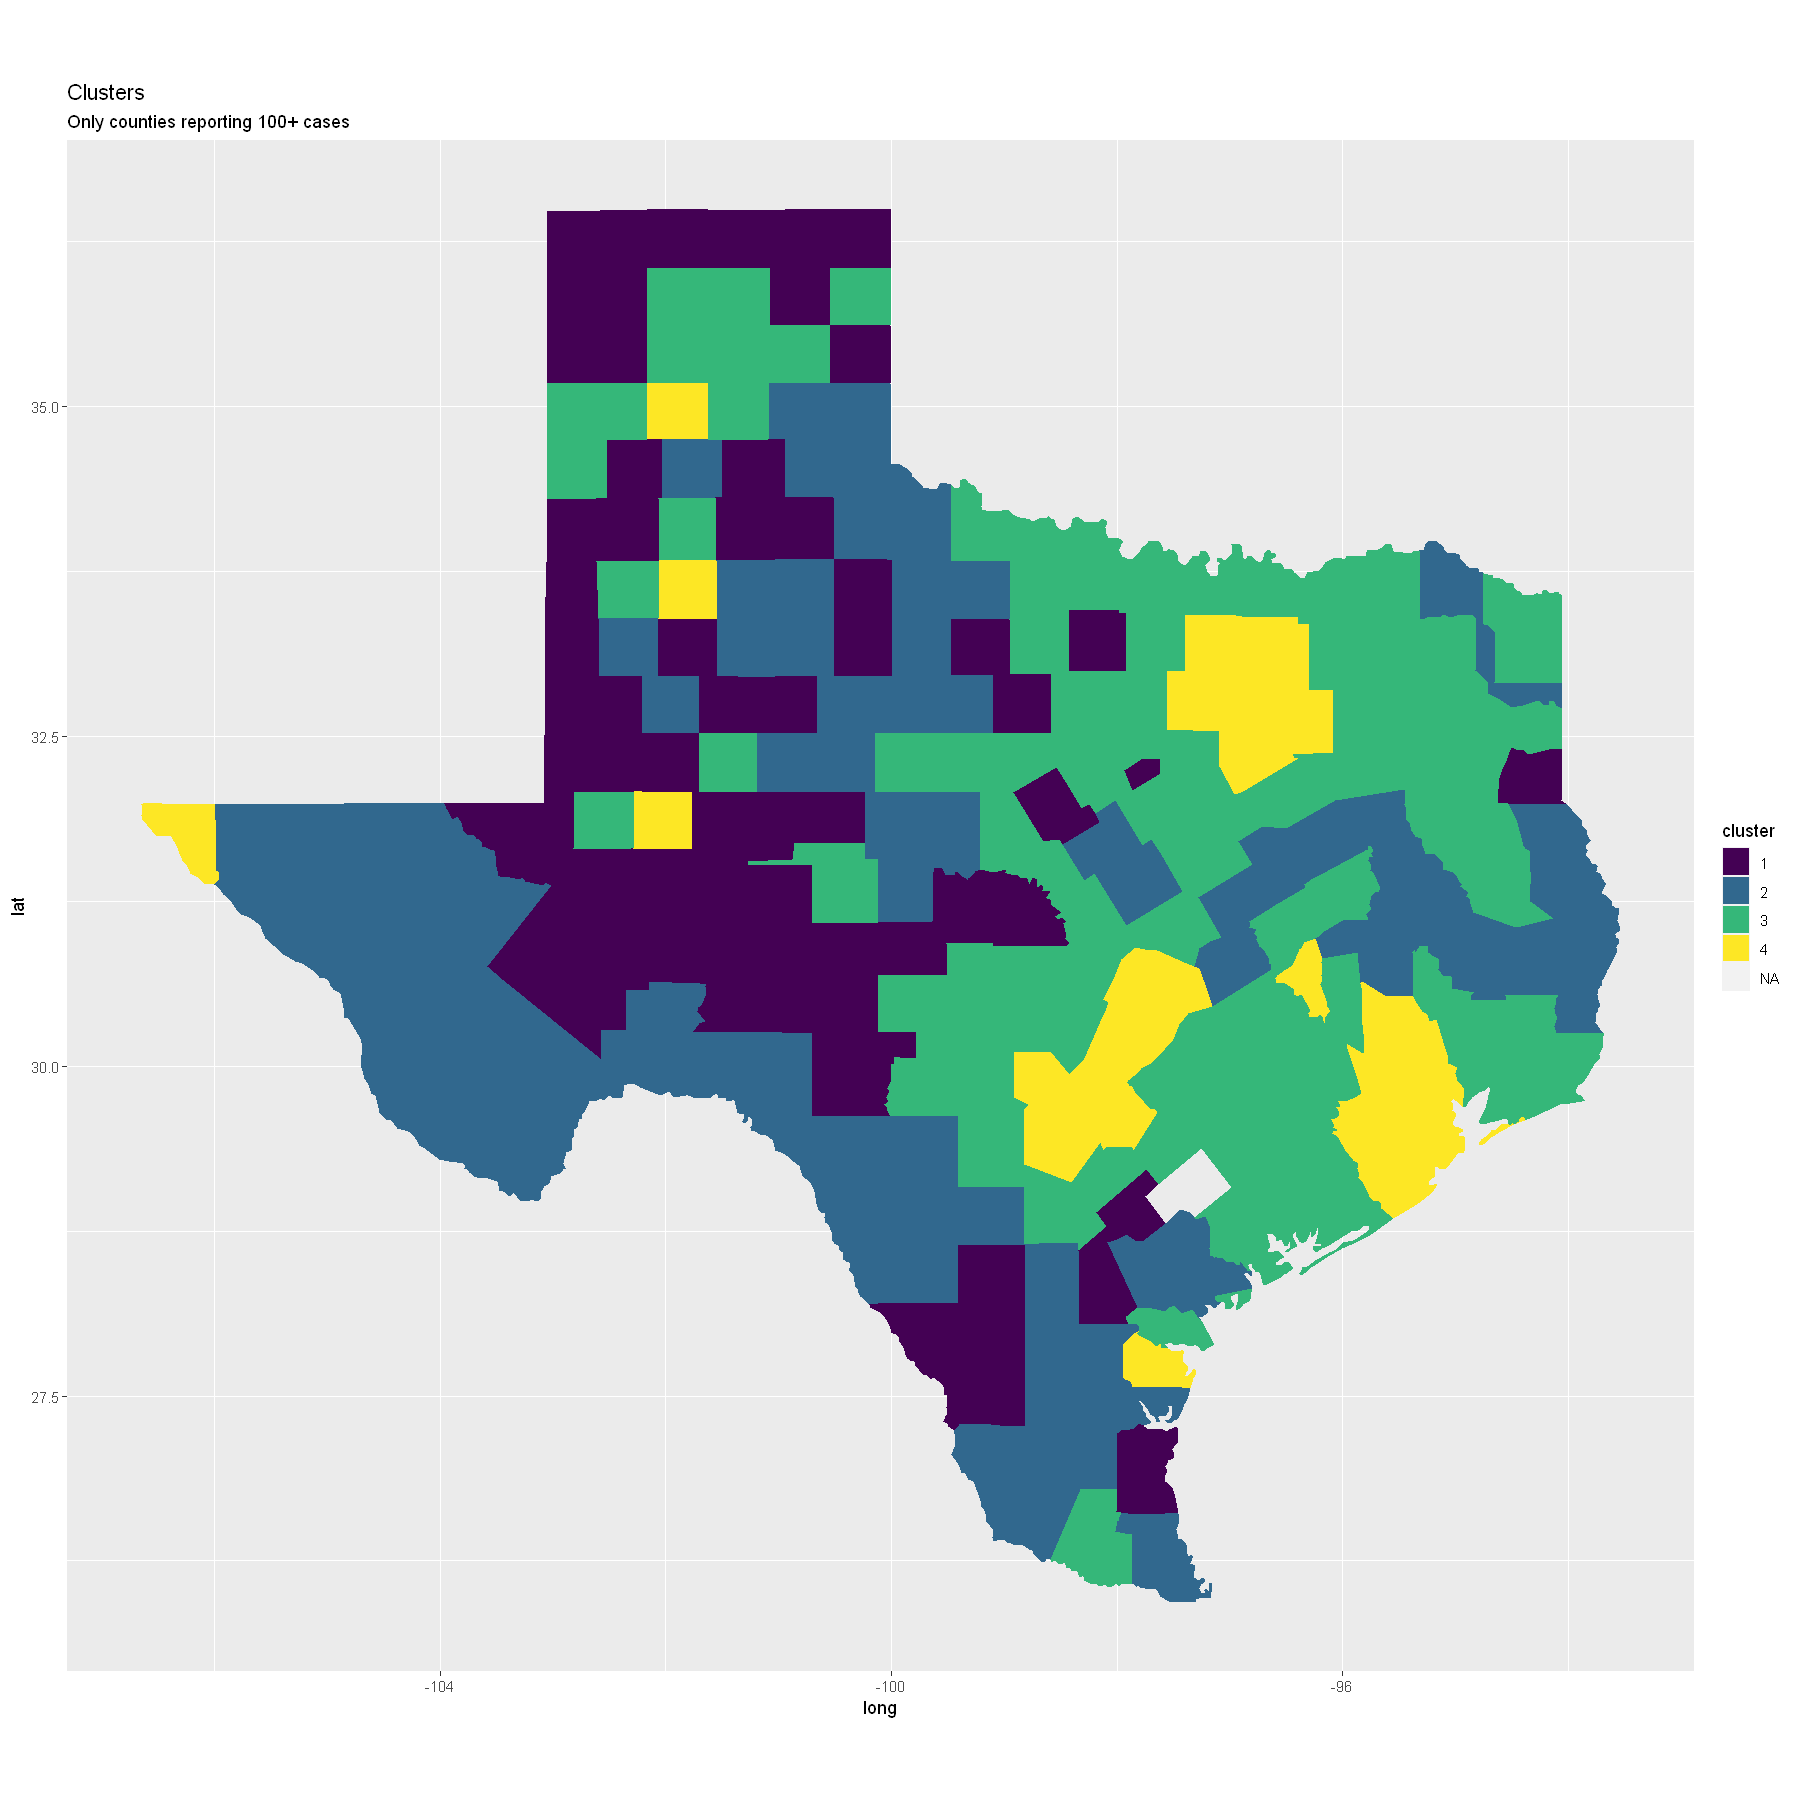

In [135]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "Clusters", subtitle = "Only counties reporting 100+ cases")

In [136]:
se_data_km <- se_data %>% add_column(cluster = factor(km$cluster))

se_data_km %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,82.28162,2.210219,0.02739127
2,81.40534,2.148647,0.02838551
3,72.35499,1.654035,0.02352106
4,81.36782,1.032447,0.01267792


#### K-means Observations

We see a substaintial drop of deaths per cases in areas in cluster 4.
Areas of cluster 1 also has less average cases than other clusters

### Hierarchical Clustering

In [139]:
county_names <- se_data$county_name.x
summary(se_data_prepped)

 median_income        poverty         median_rent     
 Min.   :-2.0688   Min.   :-0.2618   Min.   :-2.2777  
 1st Qu.:-0.6238   1st Qu.:-0.2452   1st Qu.:-0.6760  
 Median :-0.1305   Median :-0.2195   Median :-0.1189  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.4819   3rd Qu.:-0.1449   3rd Qu.: 0.4936  
 Max.   : 3.6060   Max.   :11.3992   Max.   : 3.5403  
 percent_employed_agriculture_forestry_fishing_hunting_mining
 Min.   :-1.1518                                             
 1st Qu.:-0.7294                                             
 Median :-0.2940                                             
 Mean   : 0.0000                                             
 3rd Qu.: 0.4591                                             
 Max.   : 5.1237                                             
 percent_employed_arts_entertainment_recreation_accommodation_food
 Min.   :-2.27150                                                 
 1st Qu.:-0.67314                              

In [149]:
dist_se_prepped <- dist(se_data_prepped)

In [150]:
dist_se_prepped <- dist(se_data_prepped)
hc <- hclust(dist_se_prepped, method="complete")

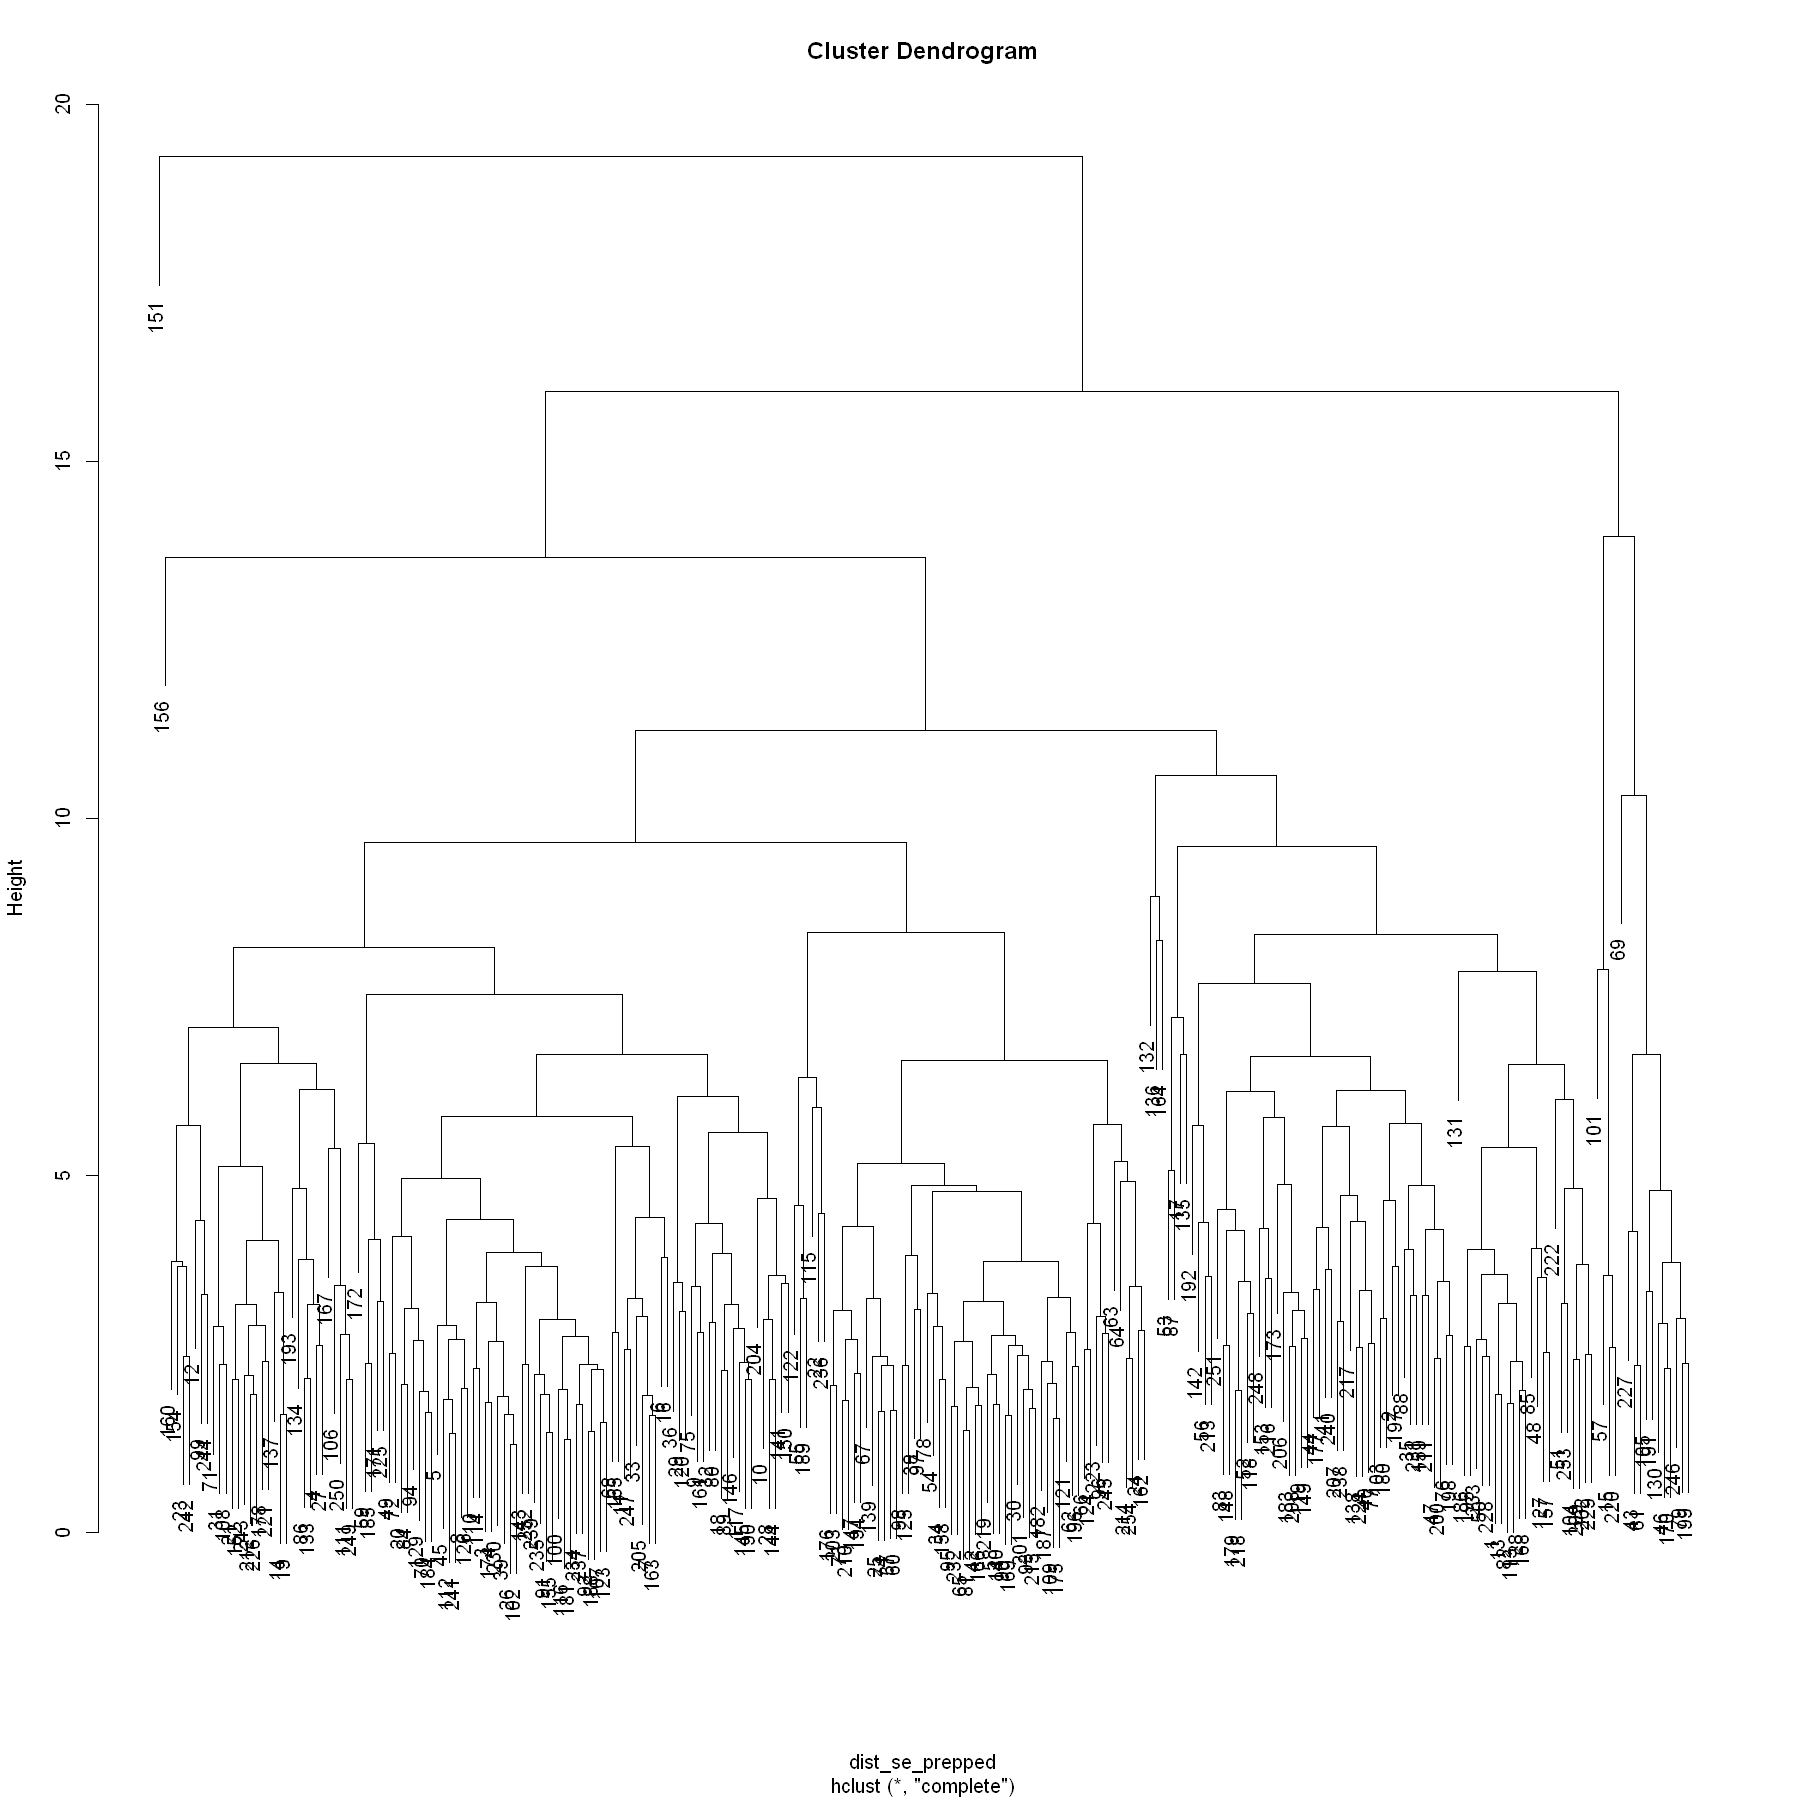

In [151]:
plot(hc)

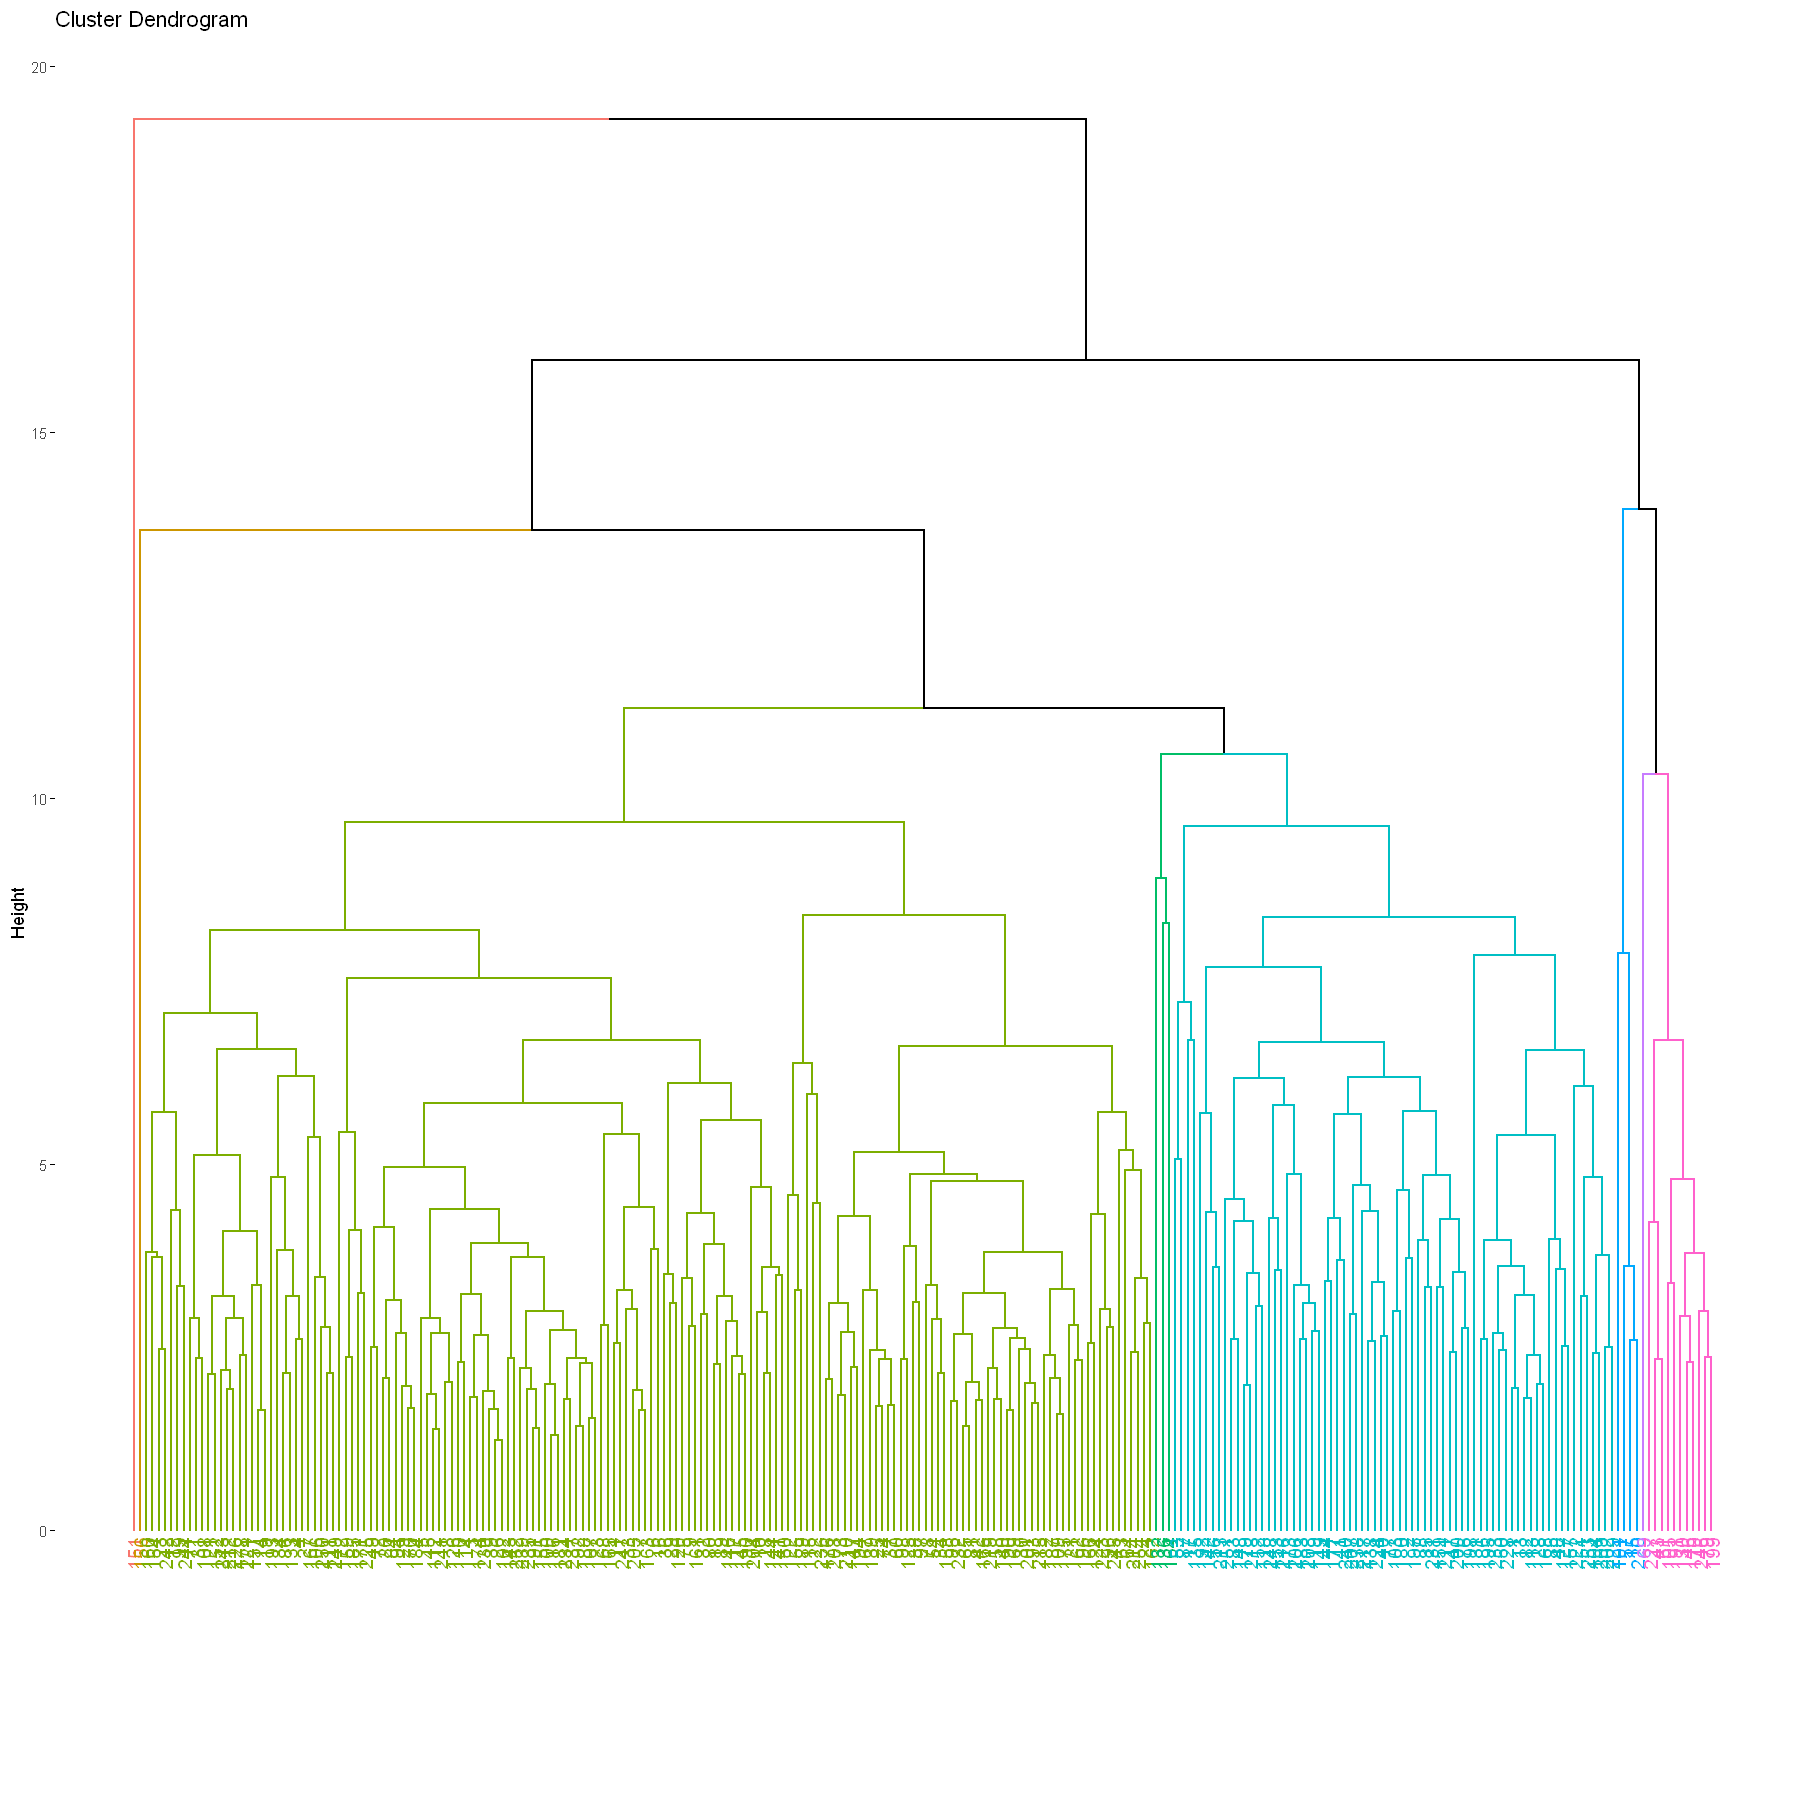

In [187]:
fviz_dend(hc, k=8)

In [191]:
h_clusters <- cutree(hc, k=8)
se_data_hclust <- se_data_prepped %>% add_column(cluster = factor(h_clusters))

In [192]:
se_data <- se_data %>% mutate(county = county_name.x %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

counties_TX_hclust <- counties_TX %>% left_join(se_data %>% 
    add_column(cluster = se_data_hclust$cluster))

Joining, by = "county"


In [264]:
counties_TX_hclust

long,lat,group,order,region,county,county_name.x,cases_per_1000,deaths_per_1000,death_per_case,⋯,percent_employed_information,percent_employed_manufacturing,percent_employed_other_services_not_public_admin,percent_employed_public_administration,percent_employed_retail_trade,percent_employed_science_management_admin_waste,percent_employed_transportation_warehousing_utilities,percent_employed_wholesale_trade,percent_unemployed,cluster
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-95.75271,31.53560,2492,74520,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.76989,31.55852,2492,74521,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.76416,31.58143,2492,74522,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.72979,31.58143,2492,74523,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.74698,31.61008,2492,74524,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.72405,31.63873,2492,74525,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.75271,31.67311,2492,74526,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.76989,31.66738,2492,74527,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1
-95.77563,31.63300,2492,74528,texas,anderson,Anderson County,96.54181,1.298769,0.01345291,⋯,-0.4592636,-0.6661024,-1.075822,0.8028068,1.267599,-0.2649101,-0.4903968,-0.4403689,-0.9317144,1


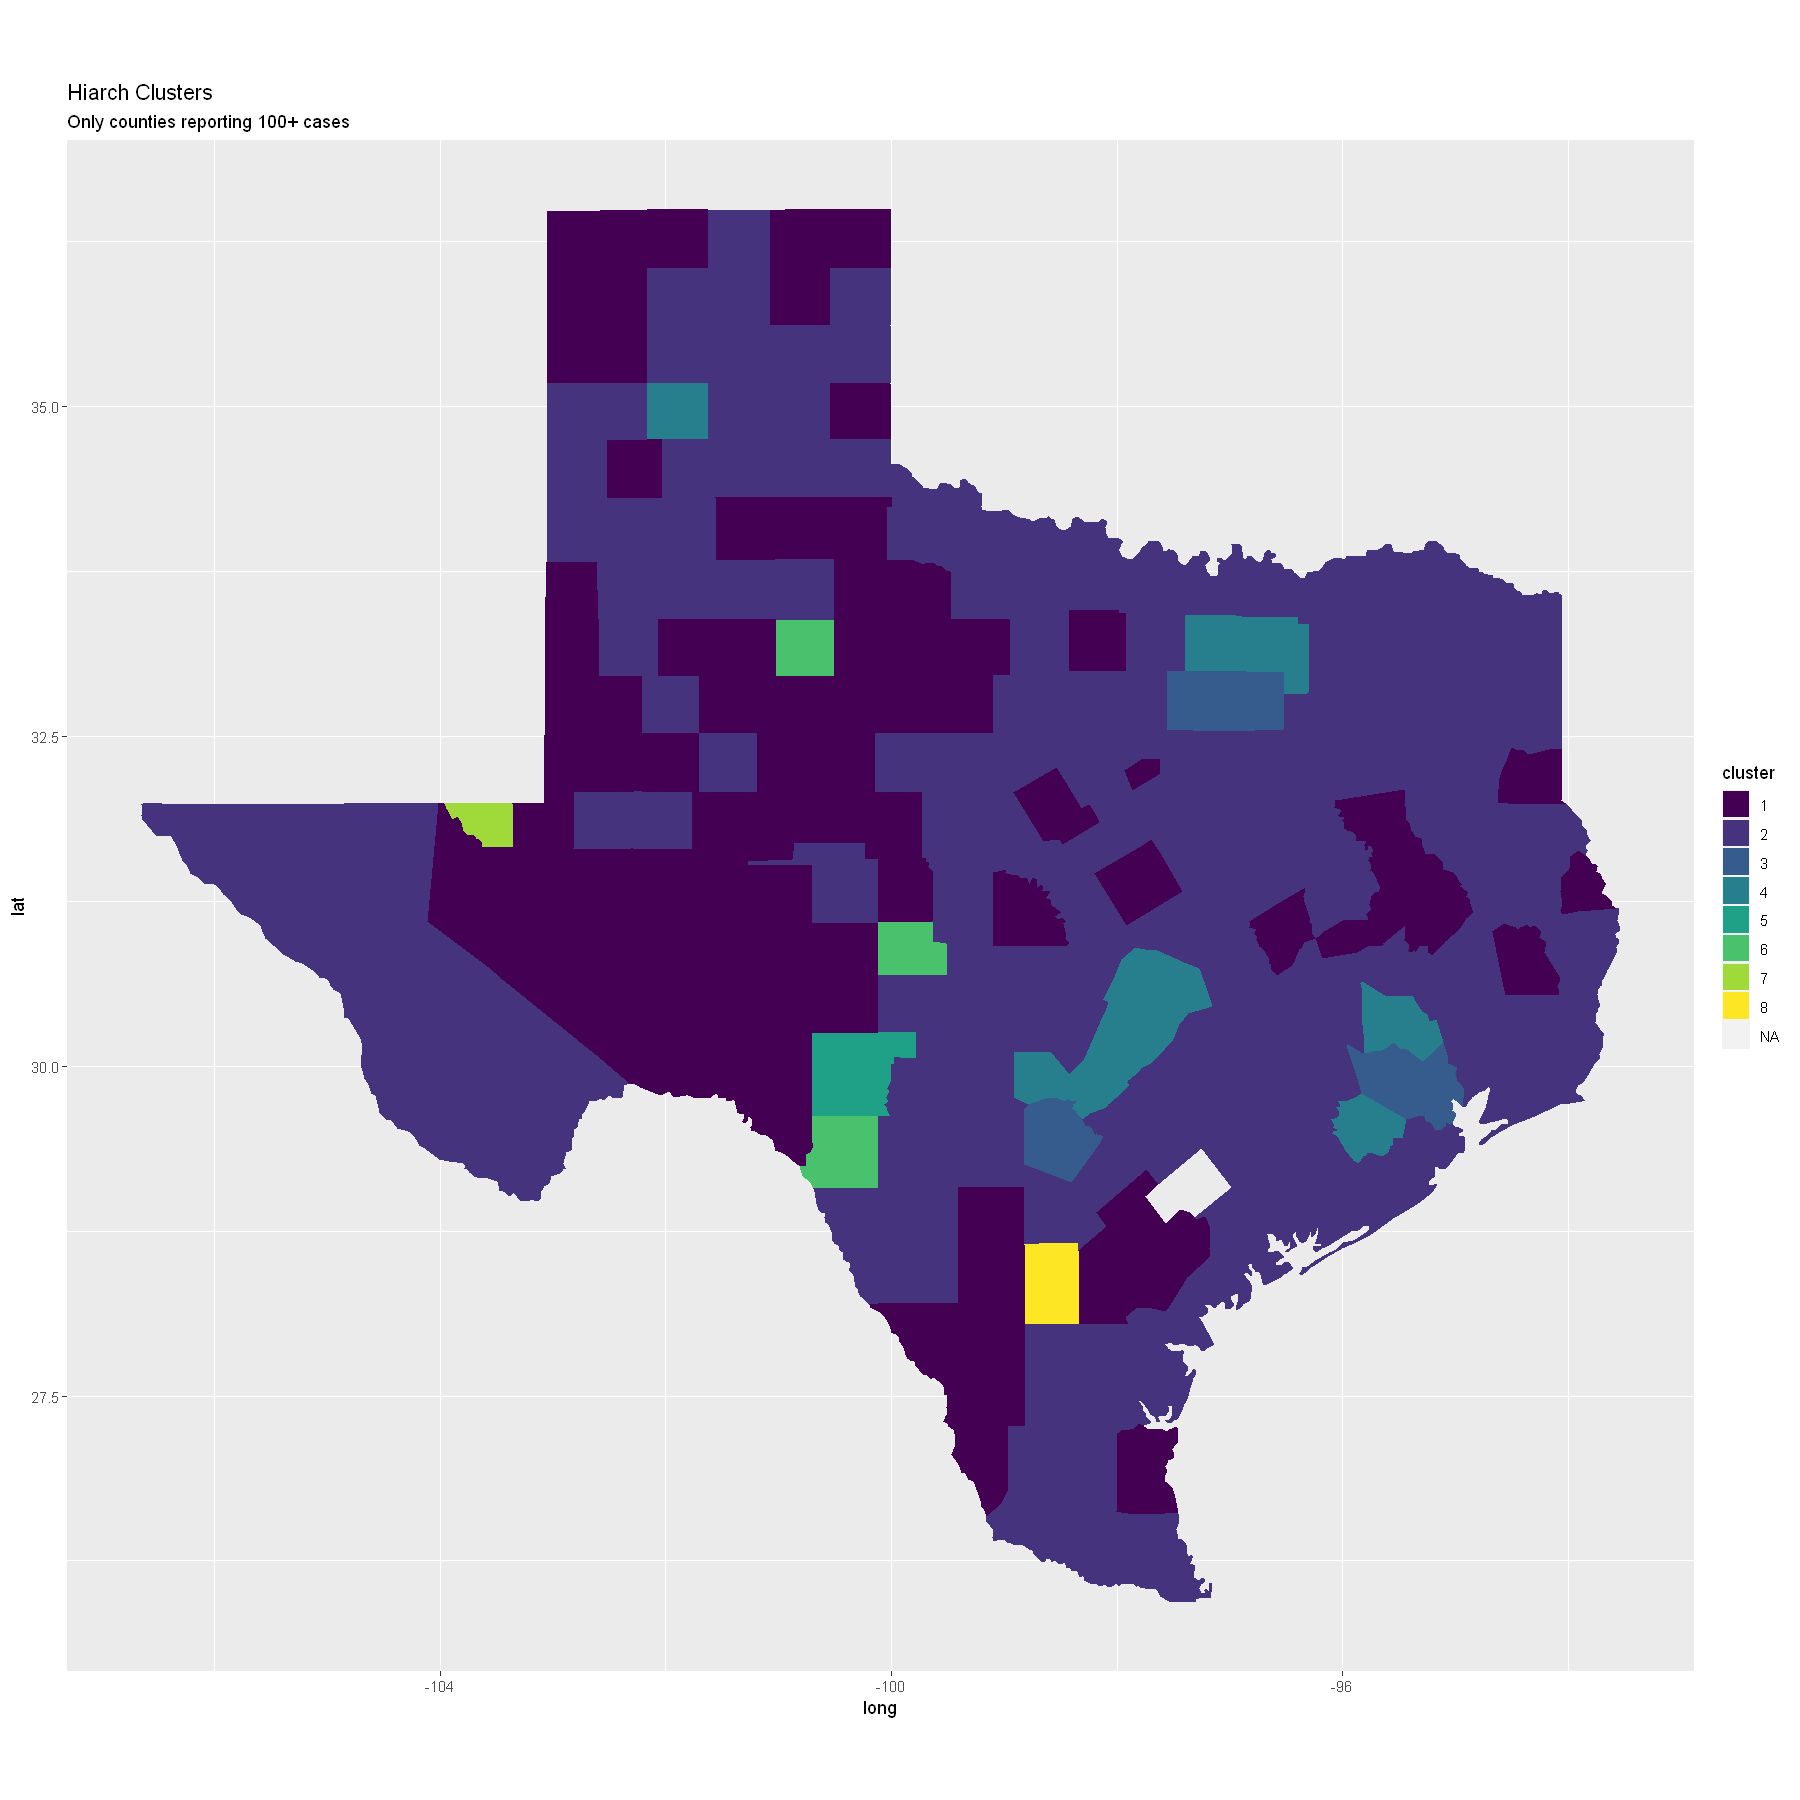

In [263]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_hclust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "Hiarch Clusters", subtitle = "Only counties reporting 100+ cases")

In [194]:
se_data_hc <- se_data %>% add_column(cluster = se_data_hclust$cluster)

se_data_hc %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,80.28430,2.1165843,0.02792868
2,77.41894,1.8437117,0.02474199
3,83.55739,0.9477385,0.01160231
4,68.08102,0.8240221,0.01250070
5,98.05779,1.4211274,0.01449275
6,85.28016,1.5506549,0.01803719
7,13.51351,0.0000000,0.00000000
8,116.66667,3.3333333,0.02857143


#### Hiarch Clustering Obervations

> Very low average cases per 1000 in cluster 7

> High deaths and cases for 8

> High cases for 5

### Fuzzy Clustering

In [204]:
install.packages("e1071")
library(e1071)

Warning message:
"package 'e1071' is in use and will not be installed"


In [235]:
fc <- cmeans(as.matrix(se_data_prepped), centers = 4)
fc

Fuzzy c-means clustering with 2 clusters

Cluster centers:
  median_income       poverty   median_rent
1 -0.0006349895 -0.0002270851 -0.0008891500
2 -0.0006795793 -0.0002430220 -0.0009515644
3  0.0018053752  0.0006452390  0.0025289215
4 -0.0004908007 -0.0001755497 -0.0006873127
  percent_employed_agriculture_forestry_fishing_hunting_mining
1                                                 0.0006770930
2                                                 0.0007246742
3                                                -0.0019263696
4                                                 0.0005232338
  percent_employed_arts_entertainment_recreation_accommodation_food
1                                                     -0.0005704557
2                                                     -0.0006105185
3                                                      0.0016222404
4                                                     -0.0004409053
  percent_employed_construction percent_employed_education_health_

In [212]:
se_data_fc <- se_data %>% add_column(cluster = fc$membership)

In [228]:
counties_TX_fc <- counties_TX %>% left_join(se_data_fc)

Joining, by = "county"


In [229]:
fc_clust_1 <- counties_TX_fc %>% mutate(cluster = cluster[,1])
fc_clust_2 <- counties_TX_fc %>% mutate(cluster = cluster[,2])
fc_clust_3 <- counties_TX_fc %>% mutate(cluster = cluster[,3])
fc_clust_4 <- counties_TX_fc %>% mutate(cluster = cluster[,4])

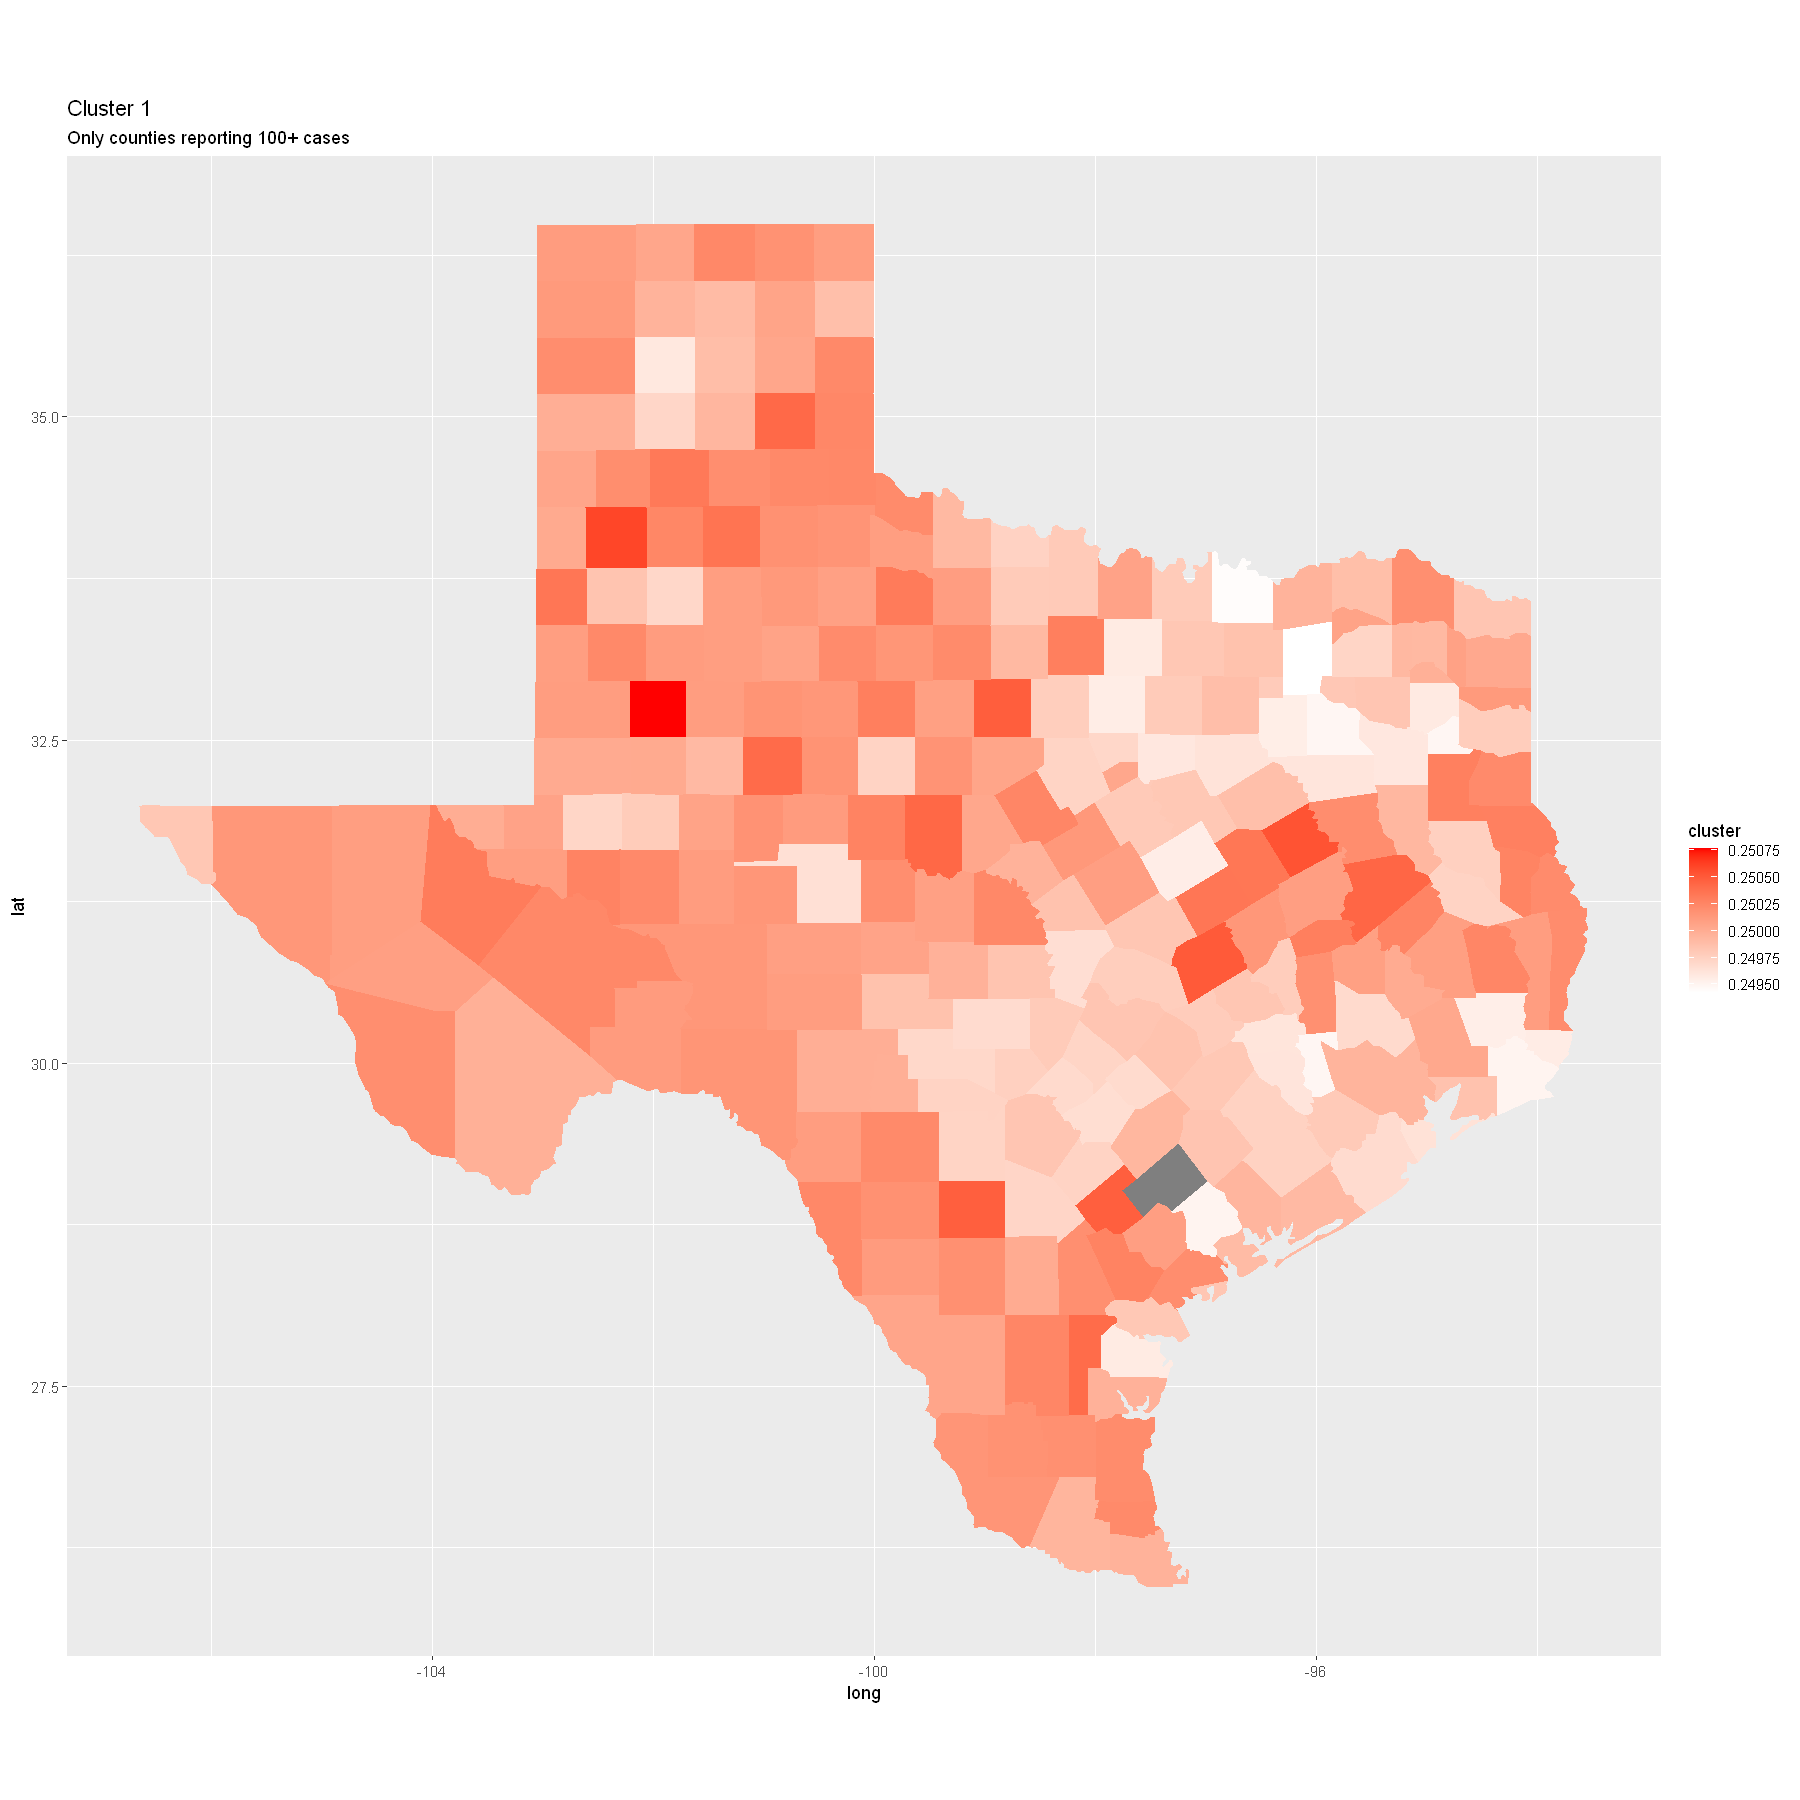

In [230]:
ggplot(fc_clust_1, aes(long, lat)) + 
  geom_polygon(data = fc_clust_1, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

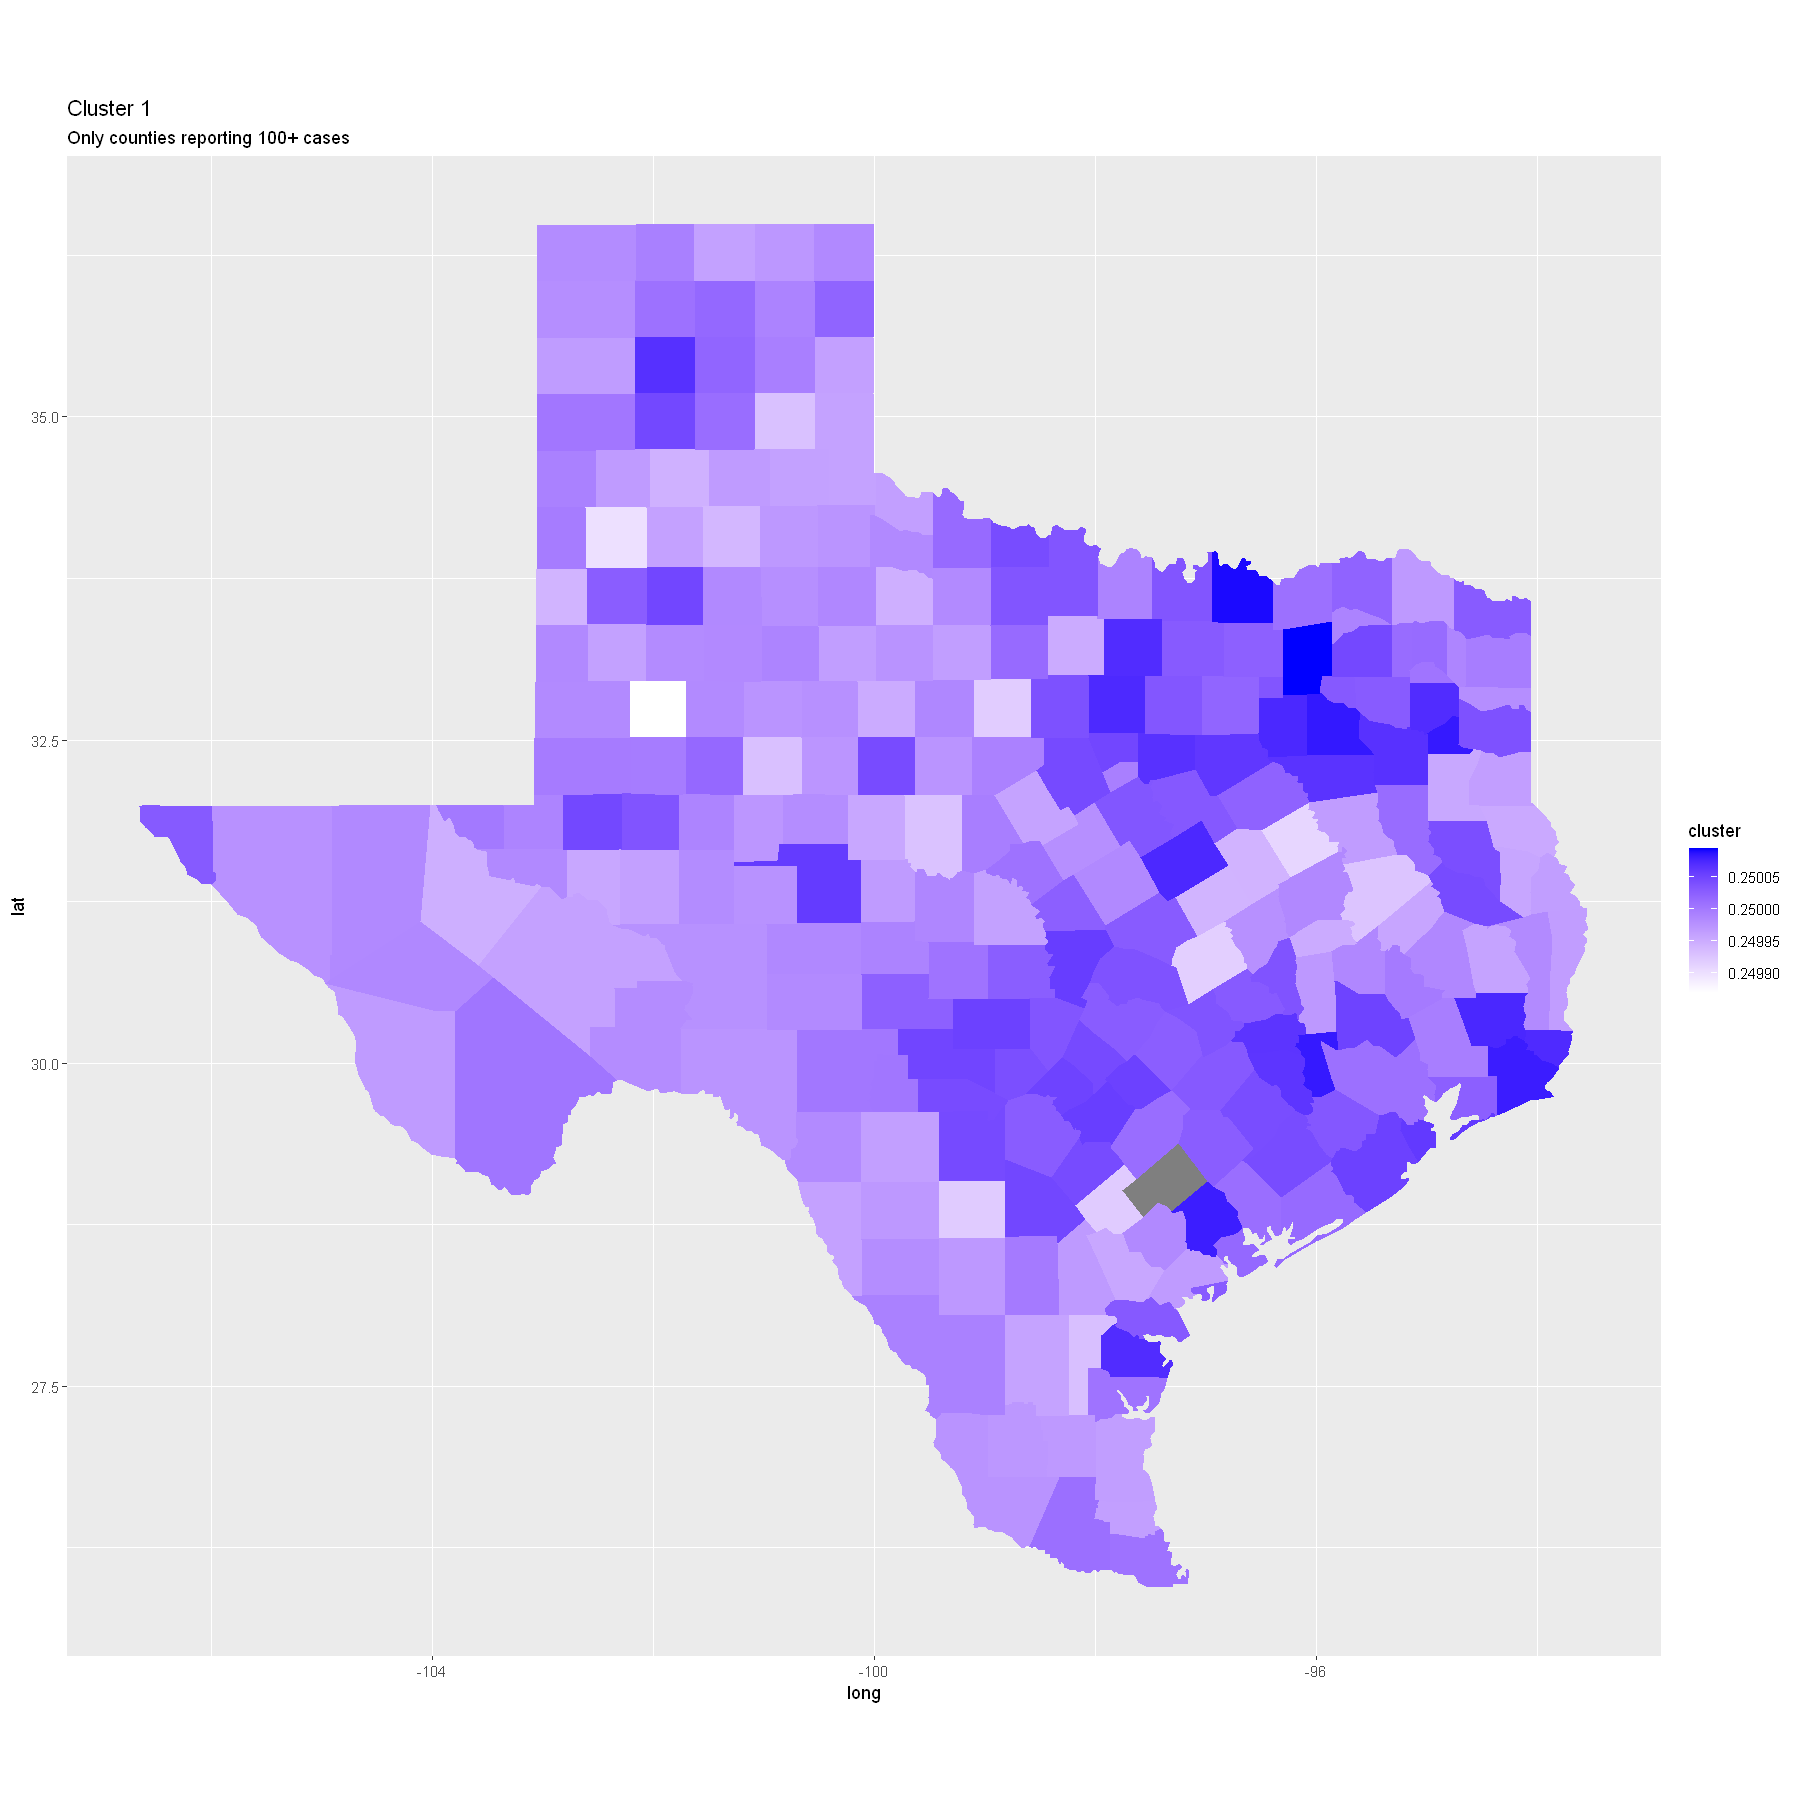

In [231]:
ggplot(fc_clust_2, aes(long, lat)) + 
  geom_polygon(data = fc_clust_2, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

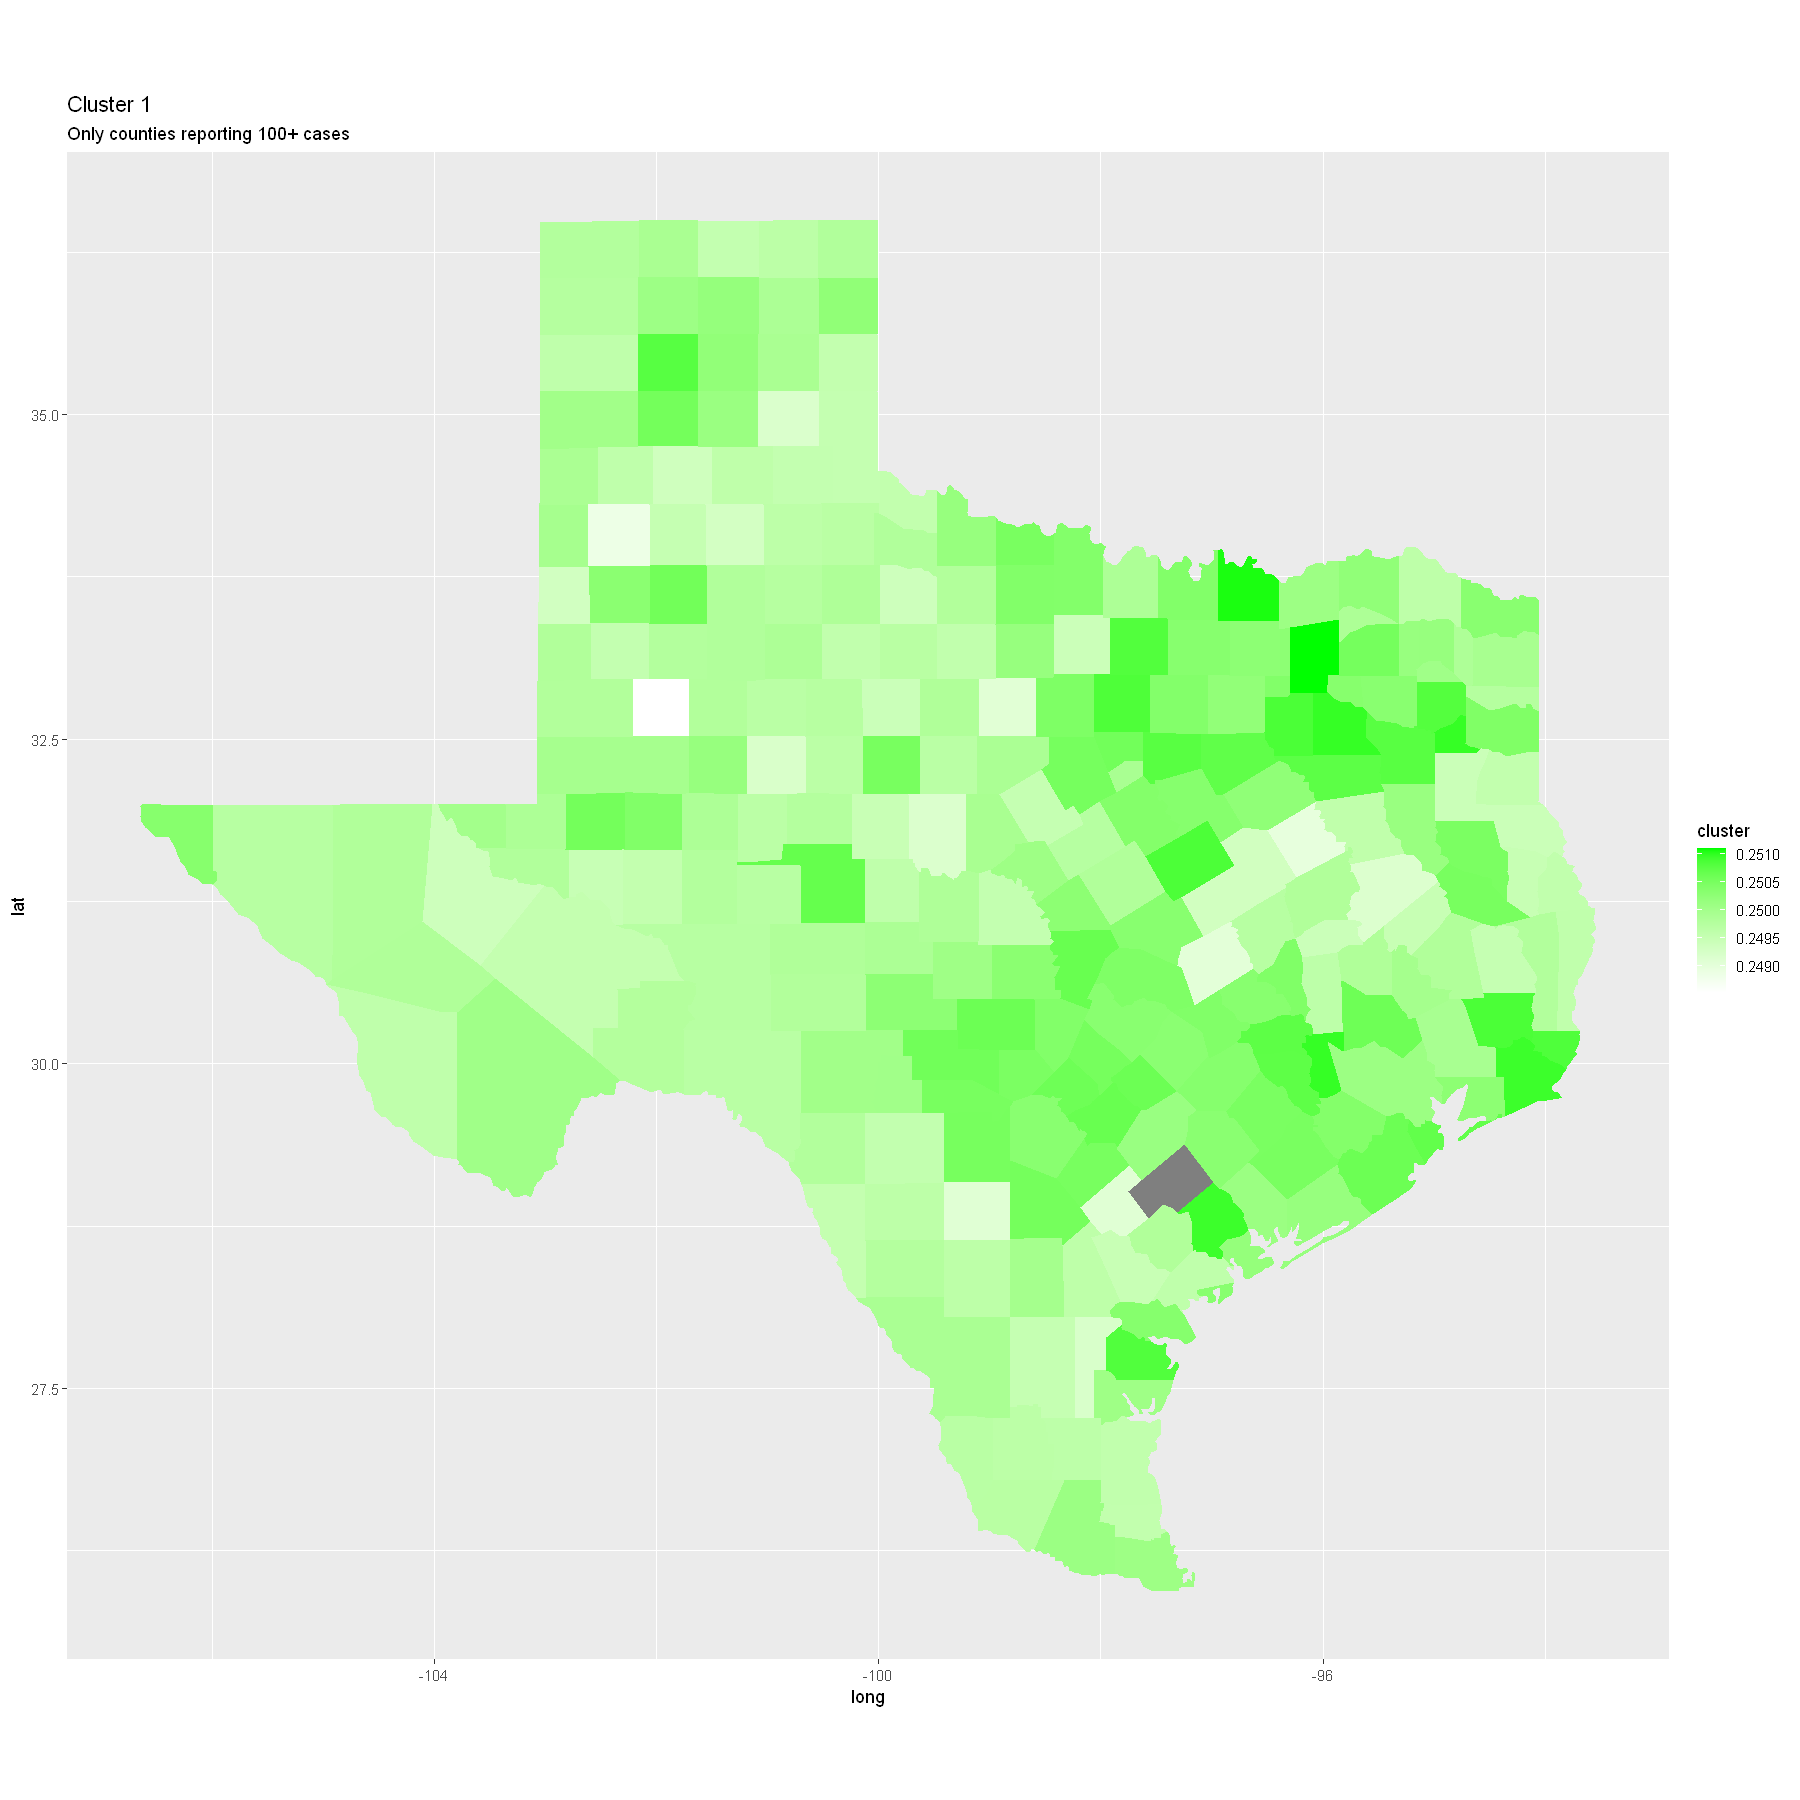

In [239]:
ggplot(fc_clust_3, aes(long, lat)) + 
  geom_polygon(data = fc_clust_3, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "green") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

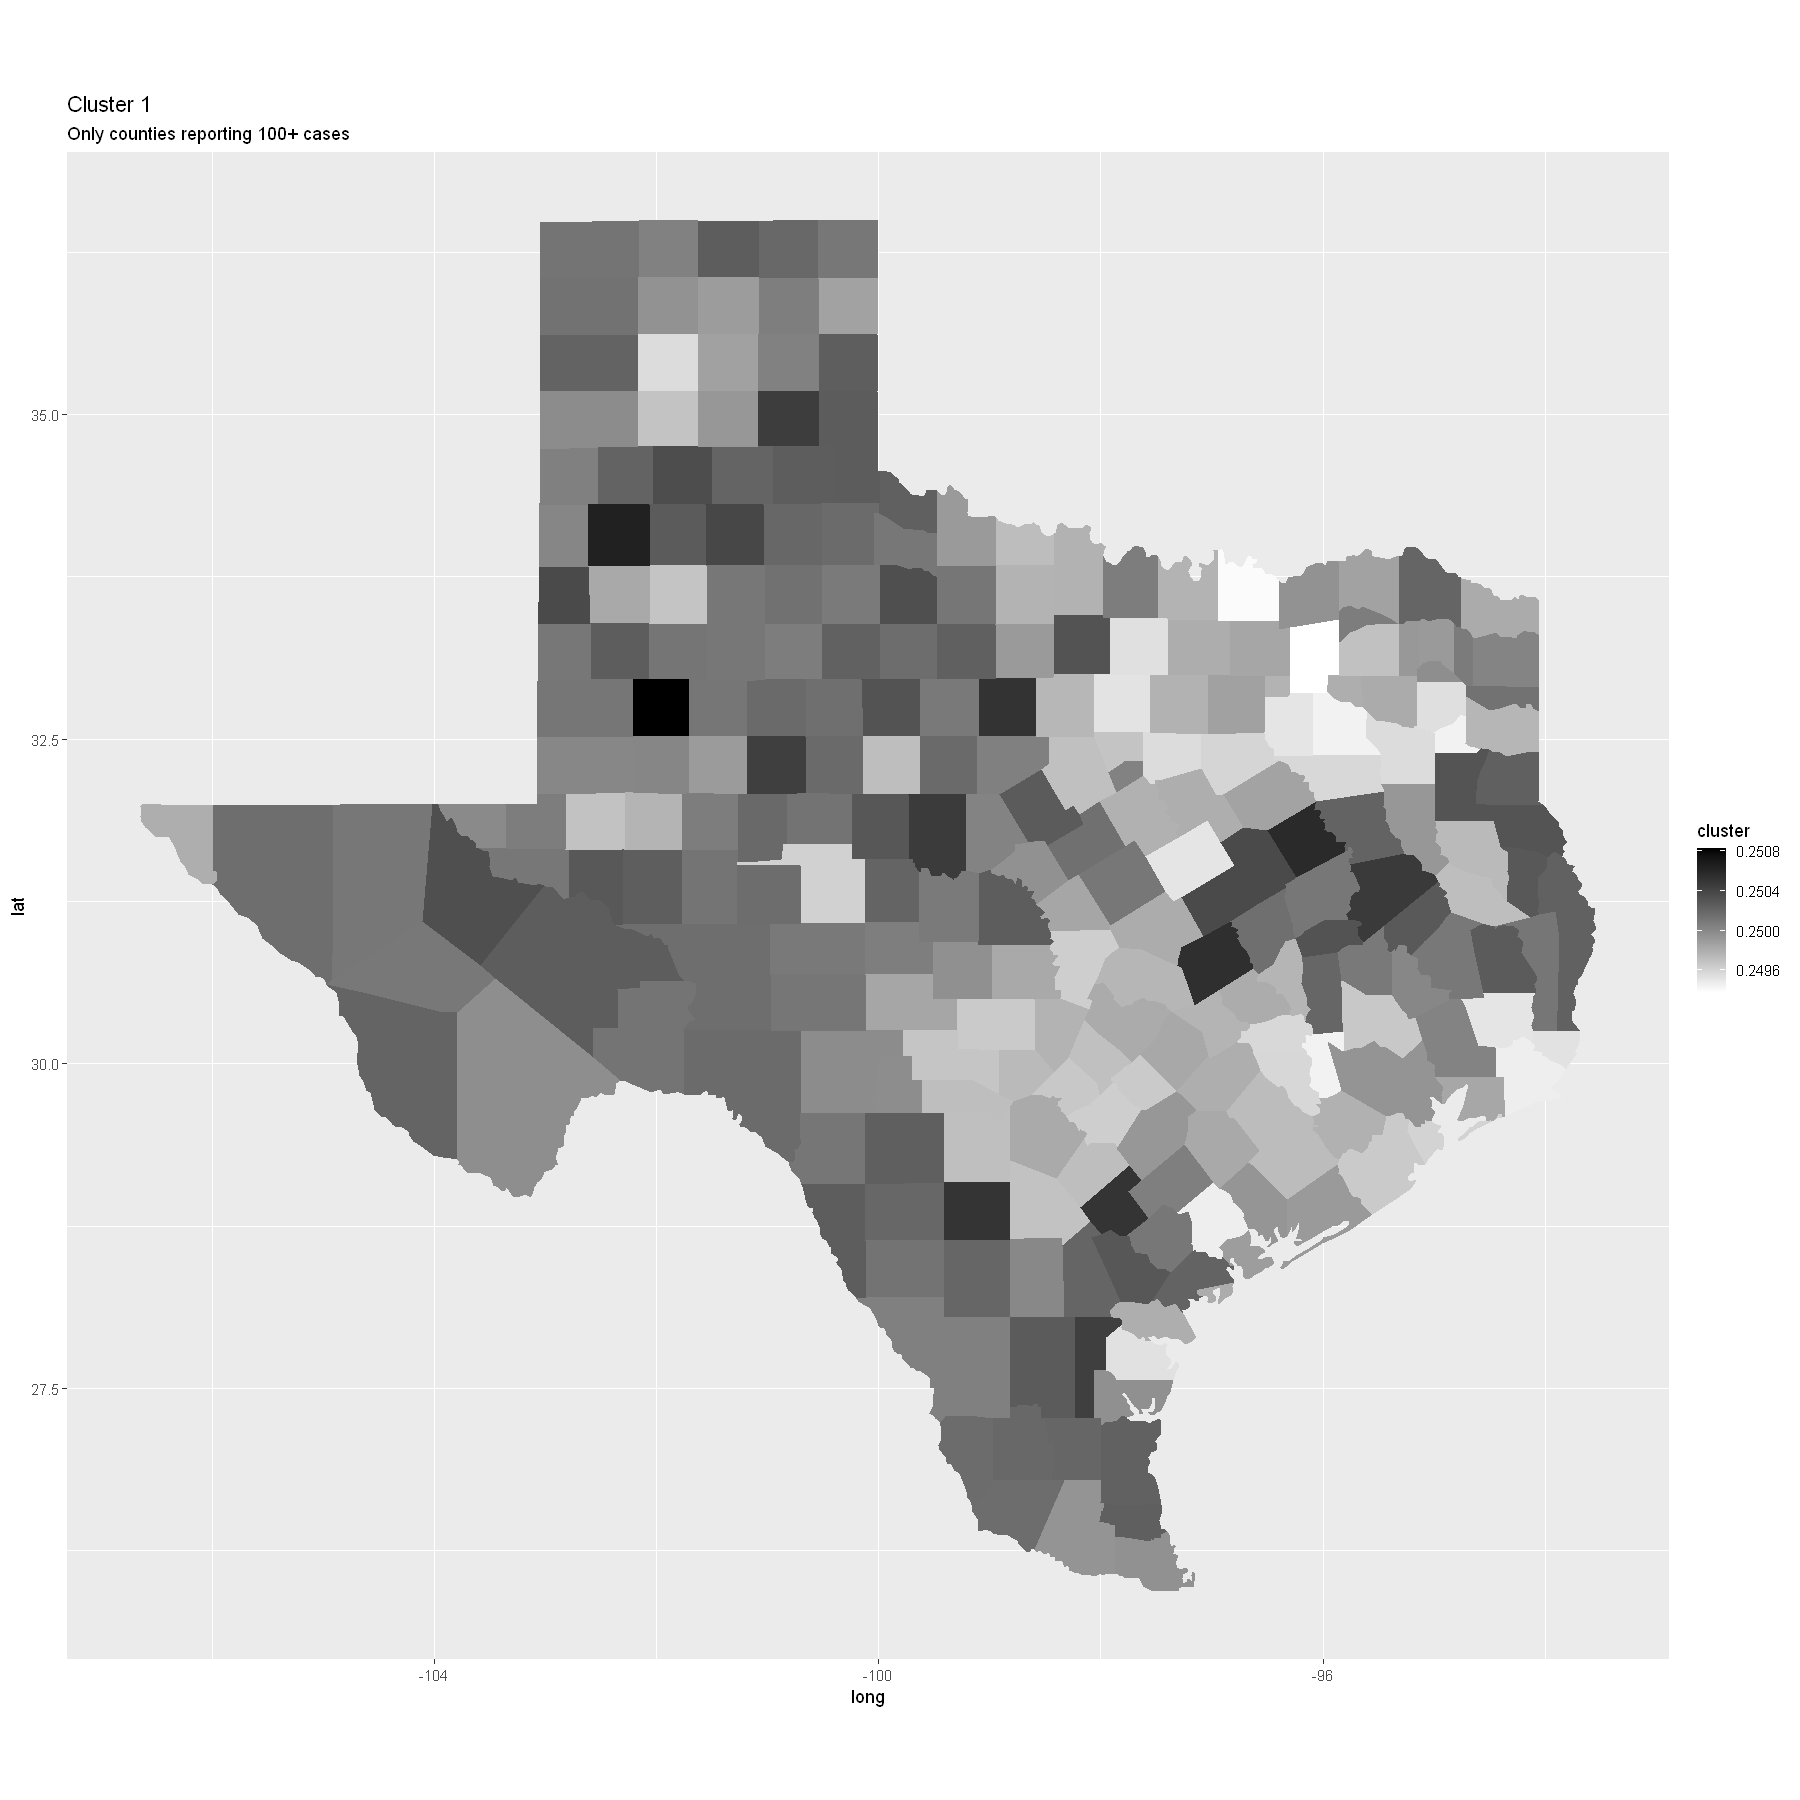

In [238]:
ggplot(fc_clust_4, aes(long, lat)) + 
  geom_polygon(data = fc_clust_4, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "black") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

#### Fuzzy Clustering Obeservations

When split into clusters, membership in each cluster is very similar in probability to each other, suggesting that the membership in each cluster is not very well defined. Maybe not the best method for this dataset

### Partitioning Around Medoids (PAM) Clustering

In [248]:
dist_se <- dist(se_data_prepped)

In [283]:
p <- pam(dist_se, k=4)

In [284]:
se_data_p <- se_data_prepped %>% add_column(cluster = factor(p$cluster))

In [285]:
counties_TX_p <- counties_TX %>% left_join(se_data %>% add_column(cluster = se_data_p$cluster))

Joining, by = "county"


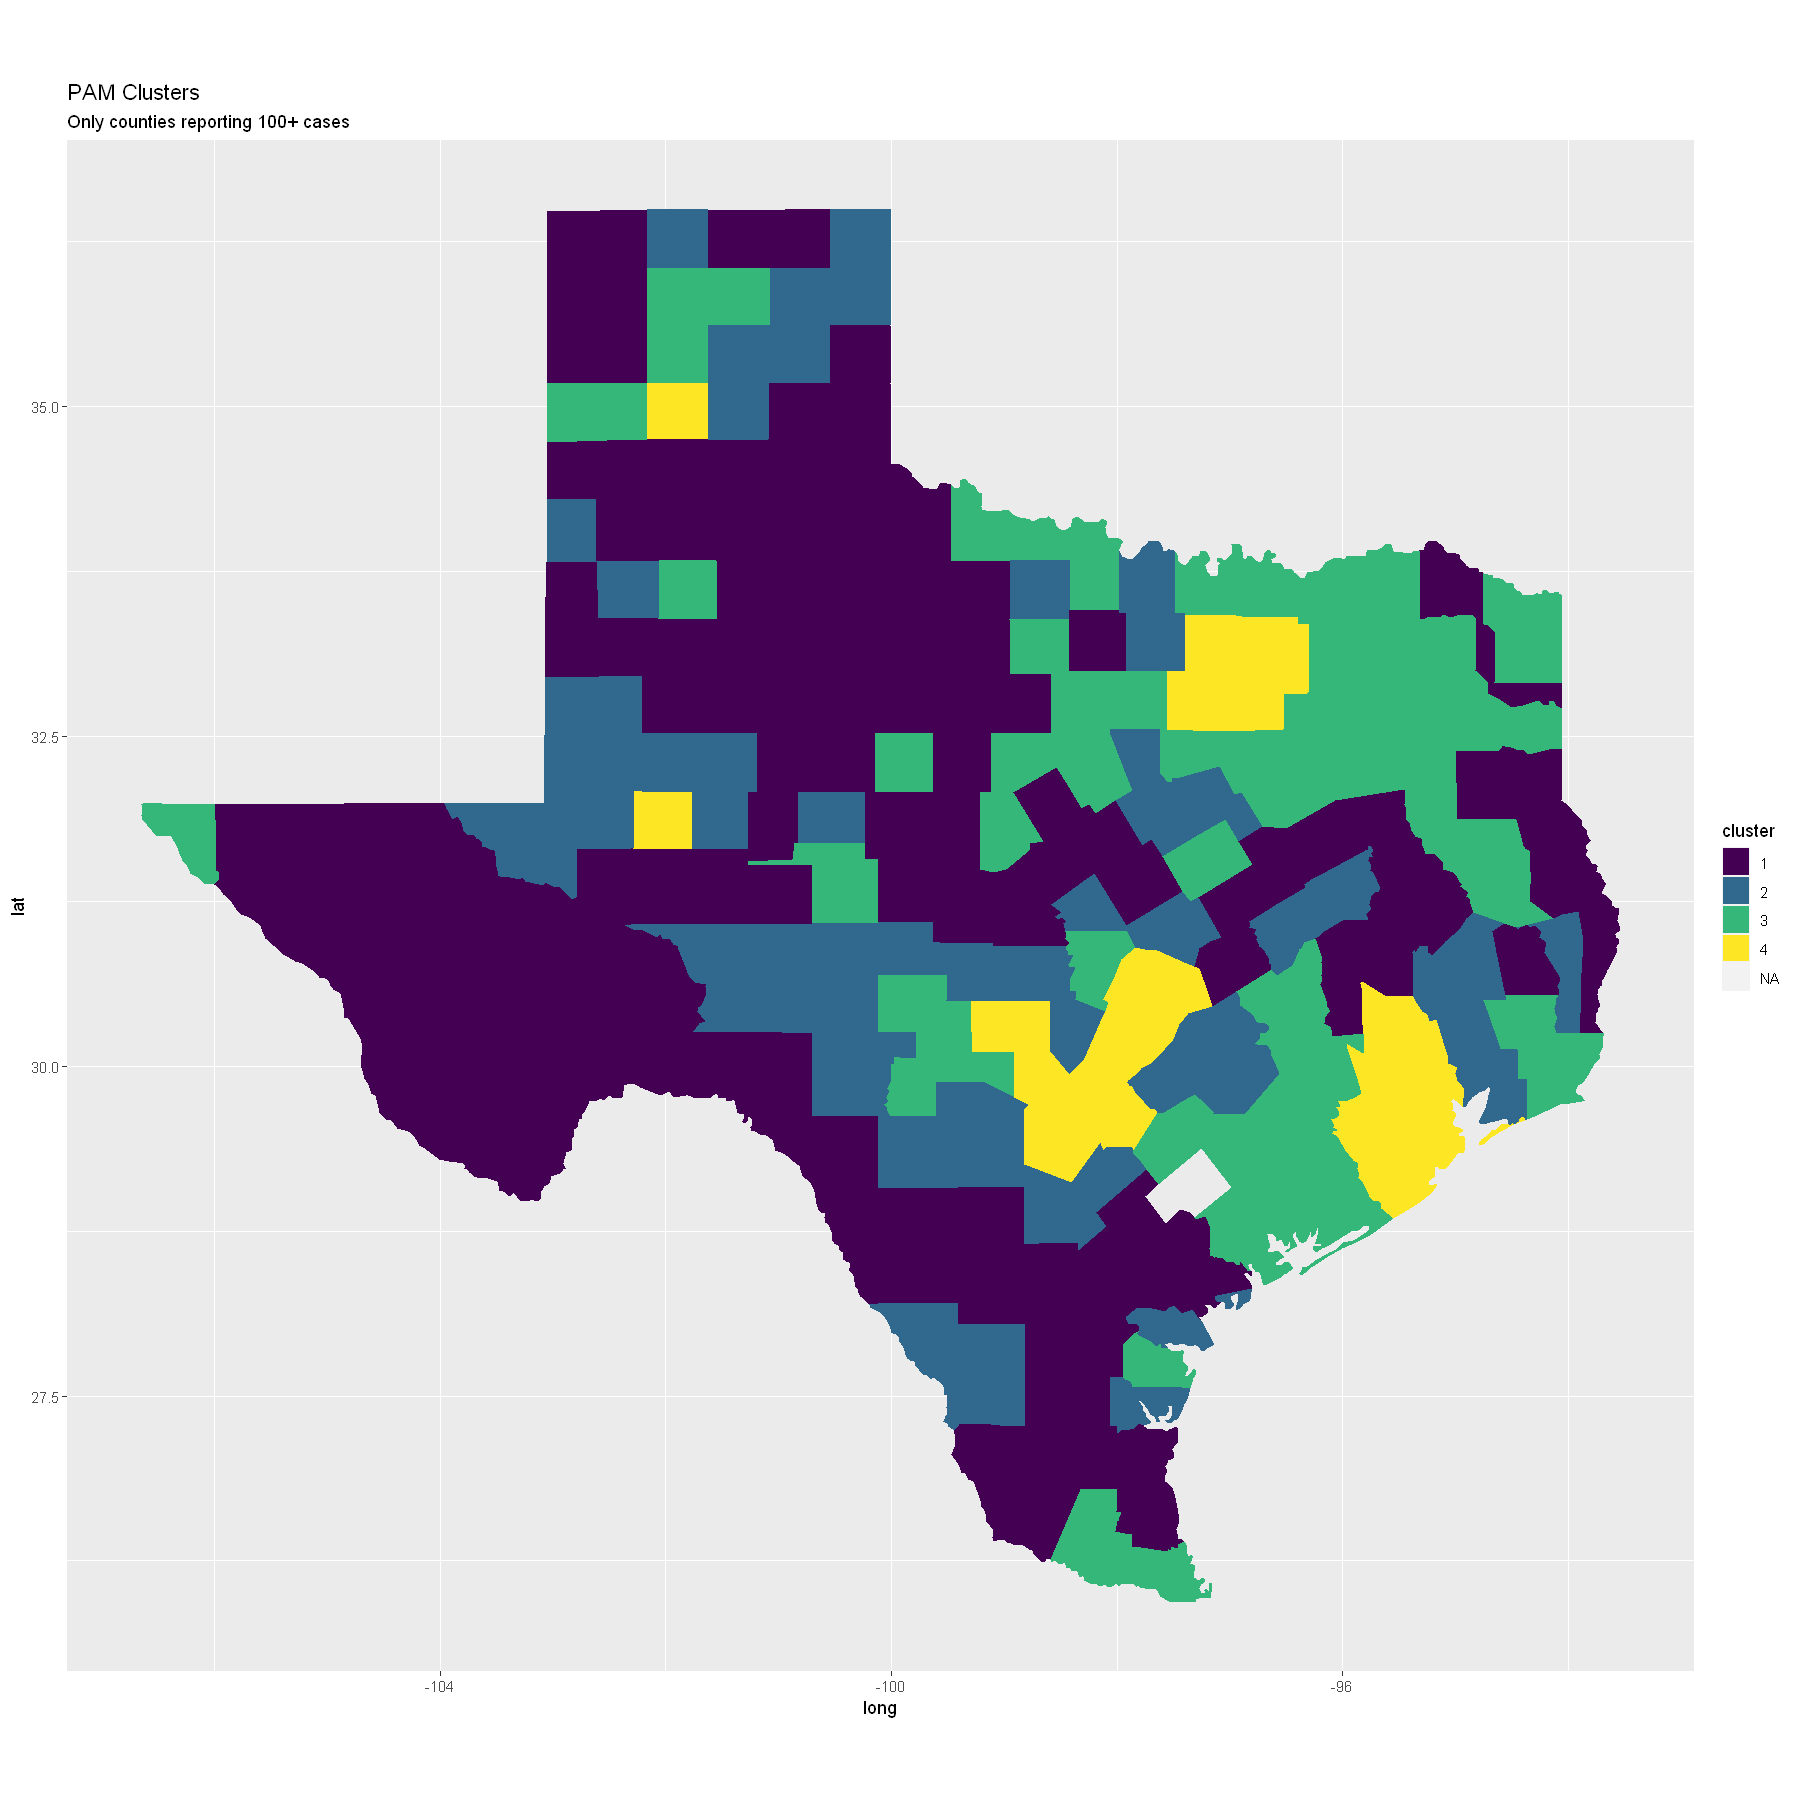

In [286]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_p, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "PAM Clusters", subtitle = "Only counties reporting 100+ cases") +
  scale_x_continuous()

In [287]:
se_data_p <- se_data %>% add_column(cluster = factor(p$cluster))

se_data_p %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,82.32510,2.2500188,0.02866199
2,72.26462,1.6351166,0.02393137
3,77.20759,1.6818991,0.02248098
4,72.82780,0.8891332,0.01252748


### PAM Observations

+ Very similar results to K-means

In [336]:
# Demographic Indicators Dataset

In [337]:
## K - means Clustering

In [354]:
demo_data_prepped <- demo_data[, !(colnames(demo_data) %in% c("county_name.x", "cases_per_1000", "deaths_per_1000", "death_per_case"))]


In [355]:
set.seed(123)
km <- kmeans(demo_data_prepped, centers = 4)
km

K-means clustering with 4 clusters of sizes 25, 156, 65, 8

Cluster means:
  hispanic_ratio median_age bachelors_degree percent_male_pop
1      0.3281032 -0.3317643       -0.2331040       2.47811495
2     -0.5814554  0.4426726       -0.1428715      -0.33700305
3      1.2786539 -0.8382277       -0.1584626      -0.08741399
4     -0.0760051 -0.7847512        4.8019532      -0.46231102
  percent_female_pop white_ratio black_ratio asian_ratio amerindian_ratio
1        -2.47811495  -0.3927378   0.1823698  -0.2080104       -0.1576406
2         0.33700305   0.5836886   0.1650225  -0.1206576        0.1334509
3         0.08741399  -1.1689078  -0.6069608  -0.1027448       -0.2316490
4         0.46231102  -0.6572459   1.1437113   3.8376579       -0.2275169
  other_race_ratio percent_children
1       0.09385046       -0.7758344
2       0.04156364       -0.3504943
3      -0.19328195        1.0814699
4       0.46664217        0.4721784

Clustering vector:
  1   2   3   4   5   6   7   8   9  10  11  

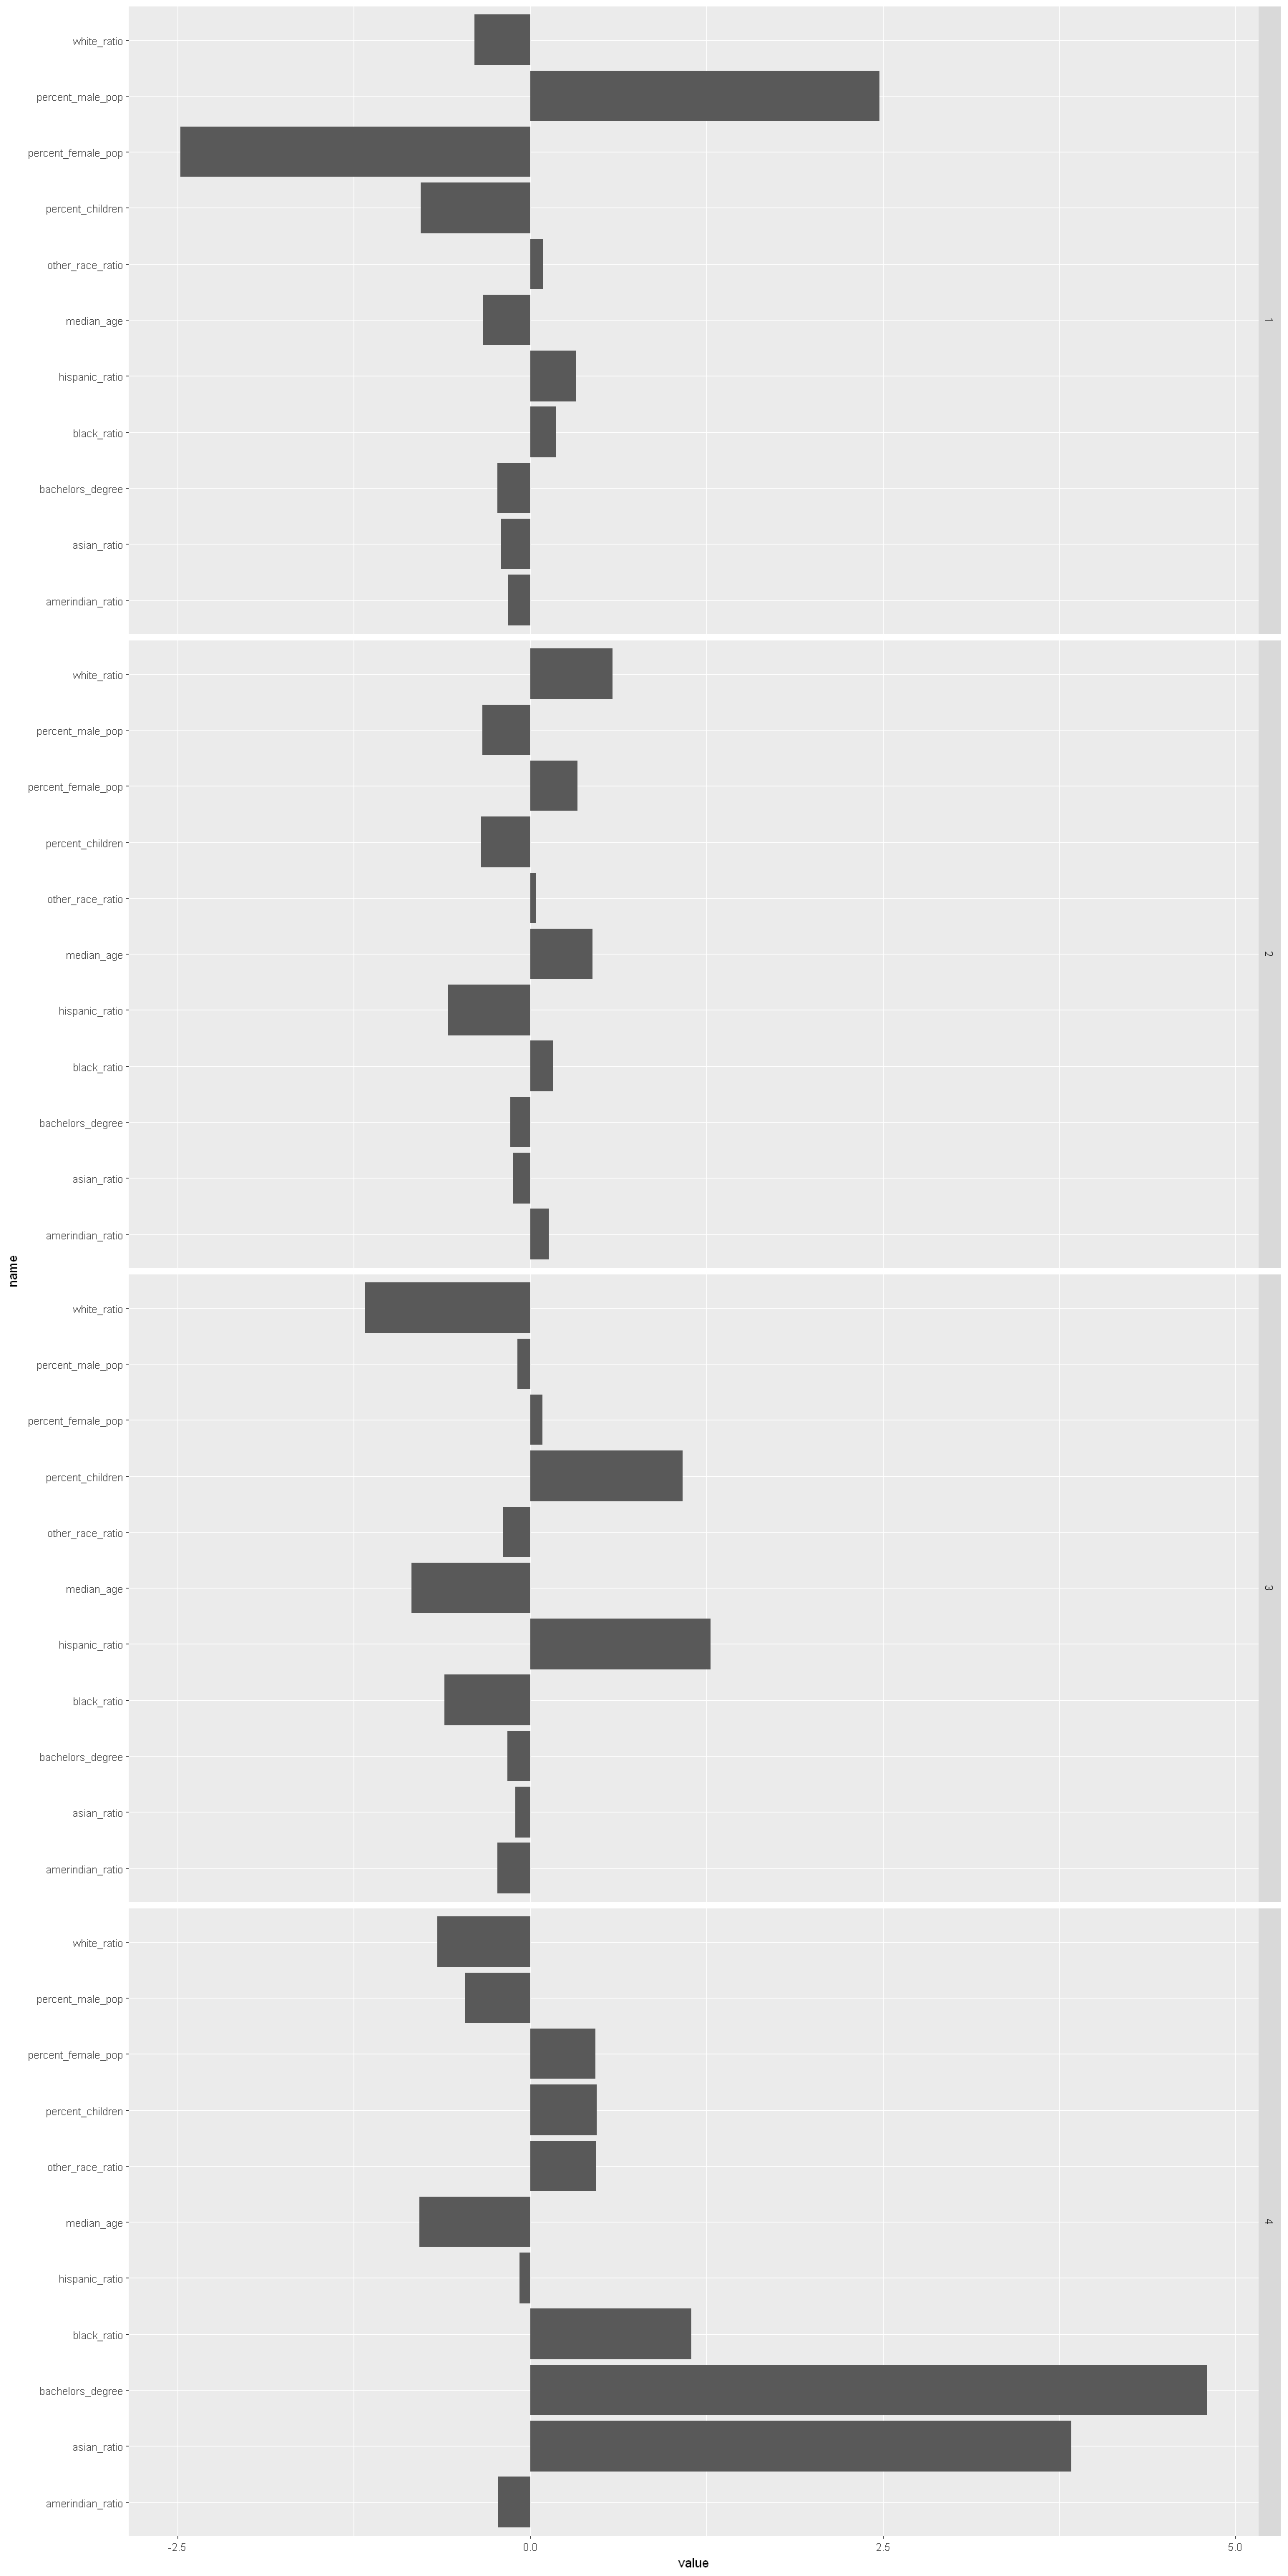

In [356]:
options(repr.plot.width = 15, repr.plot.height = 30)
ggplot(pivot_longer(as_tibble(km$centers,  rownames = "cluster"), 
  cols = colnames(km$centers)), 
  aes(y = name, x = value)) +
  geom_bar(stat = "identity") +
  facet_grid(rows = vars(cluster))

In [357]:
demo_data <- demo_data %>% mutate(county = county_name.x %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

counties_TX_clust <- counties_TX %>% left_join(demo_data %>% 
    add_column(cluster = factor(km$cluster)))

Joining, by = "county"


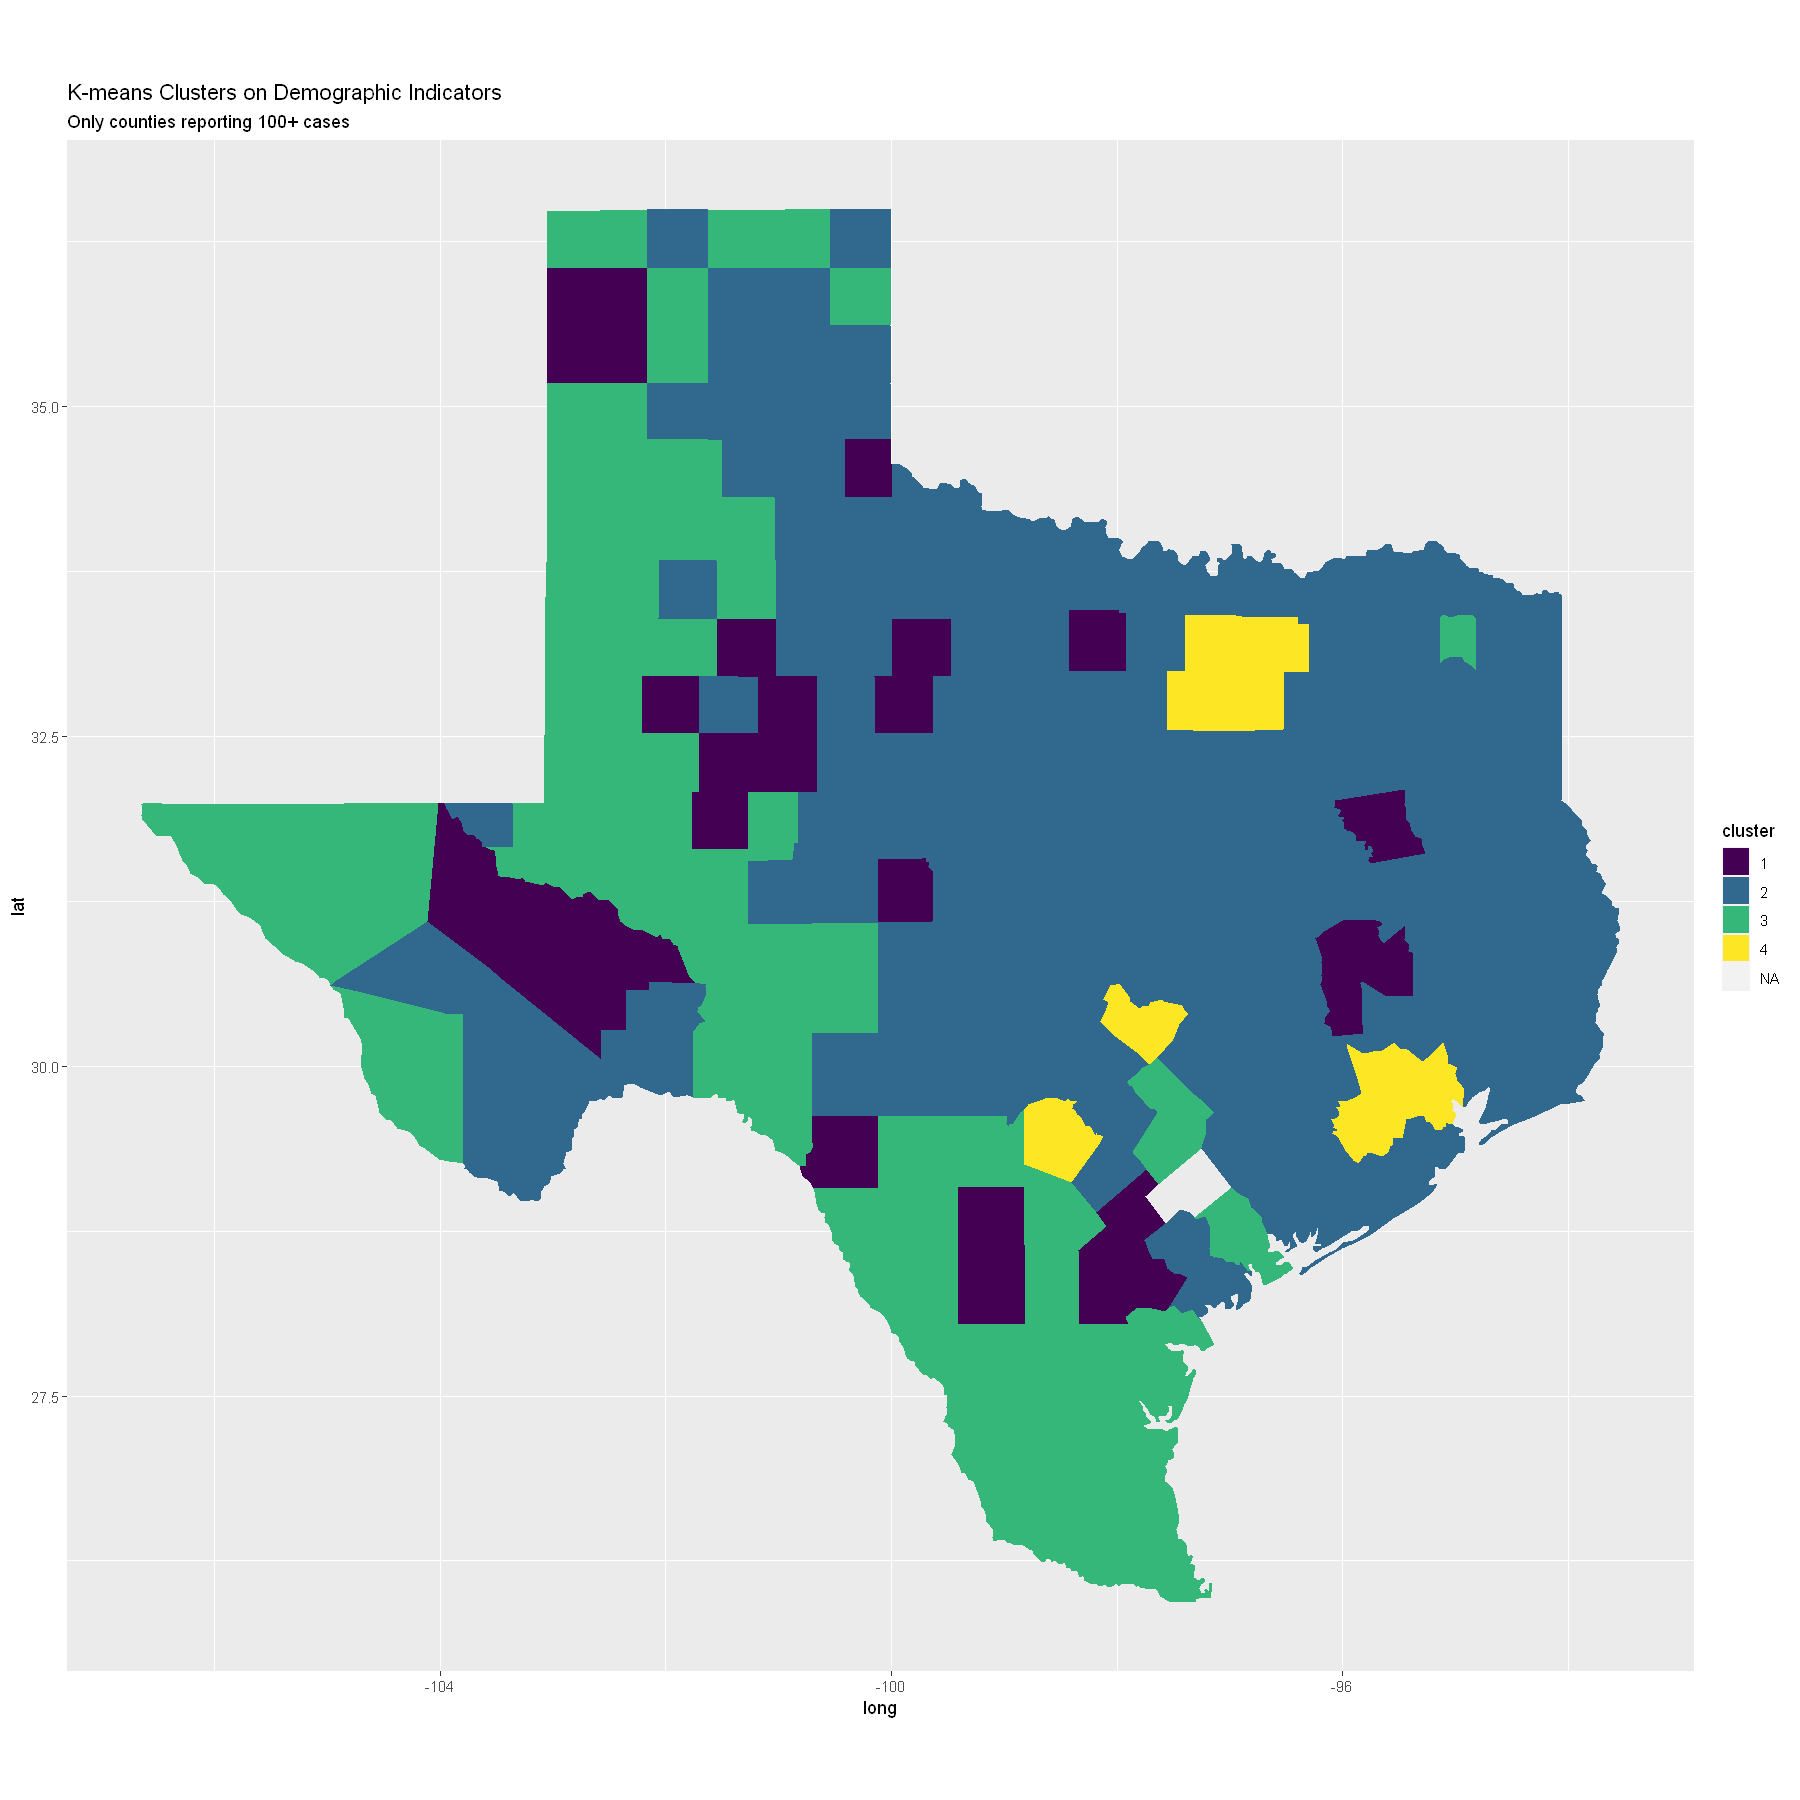

In [358]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "K-means Clusters on Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

In [359]:
demo_data_km <- demo_data %>% add_column(cluster = factor(km$cluster))

demo_data_km %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,90.35203,1.7592425,0.02110167
2,68.97909,1.6776889,0.02527045
3,95.55802,2.4536850,0.02644606
4,72.30528,0.7537937,0.01043821


### K - means Observations

+ 4 lower deaths per case
+ 2,4 low average cases

## Hierarchical Clustering

In [362]:
set.seed(420)
dist_demo_prepped <- dist(demo_data_prepped)
hc <- hclust(dist_demo_prepped, method="complete")

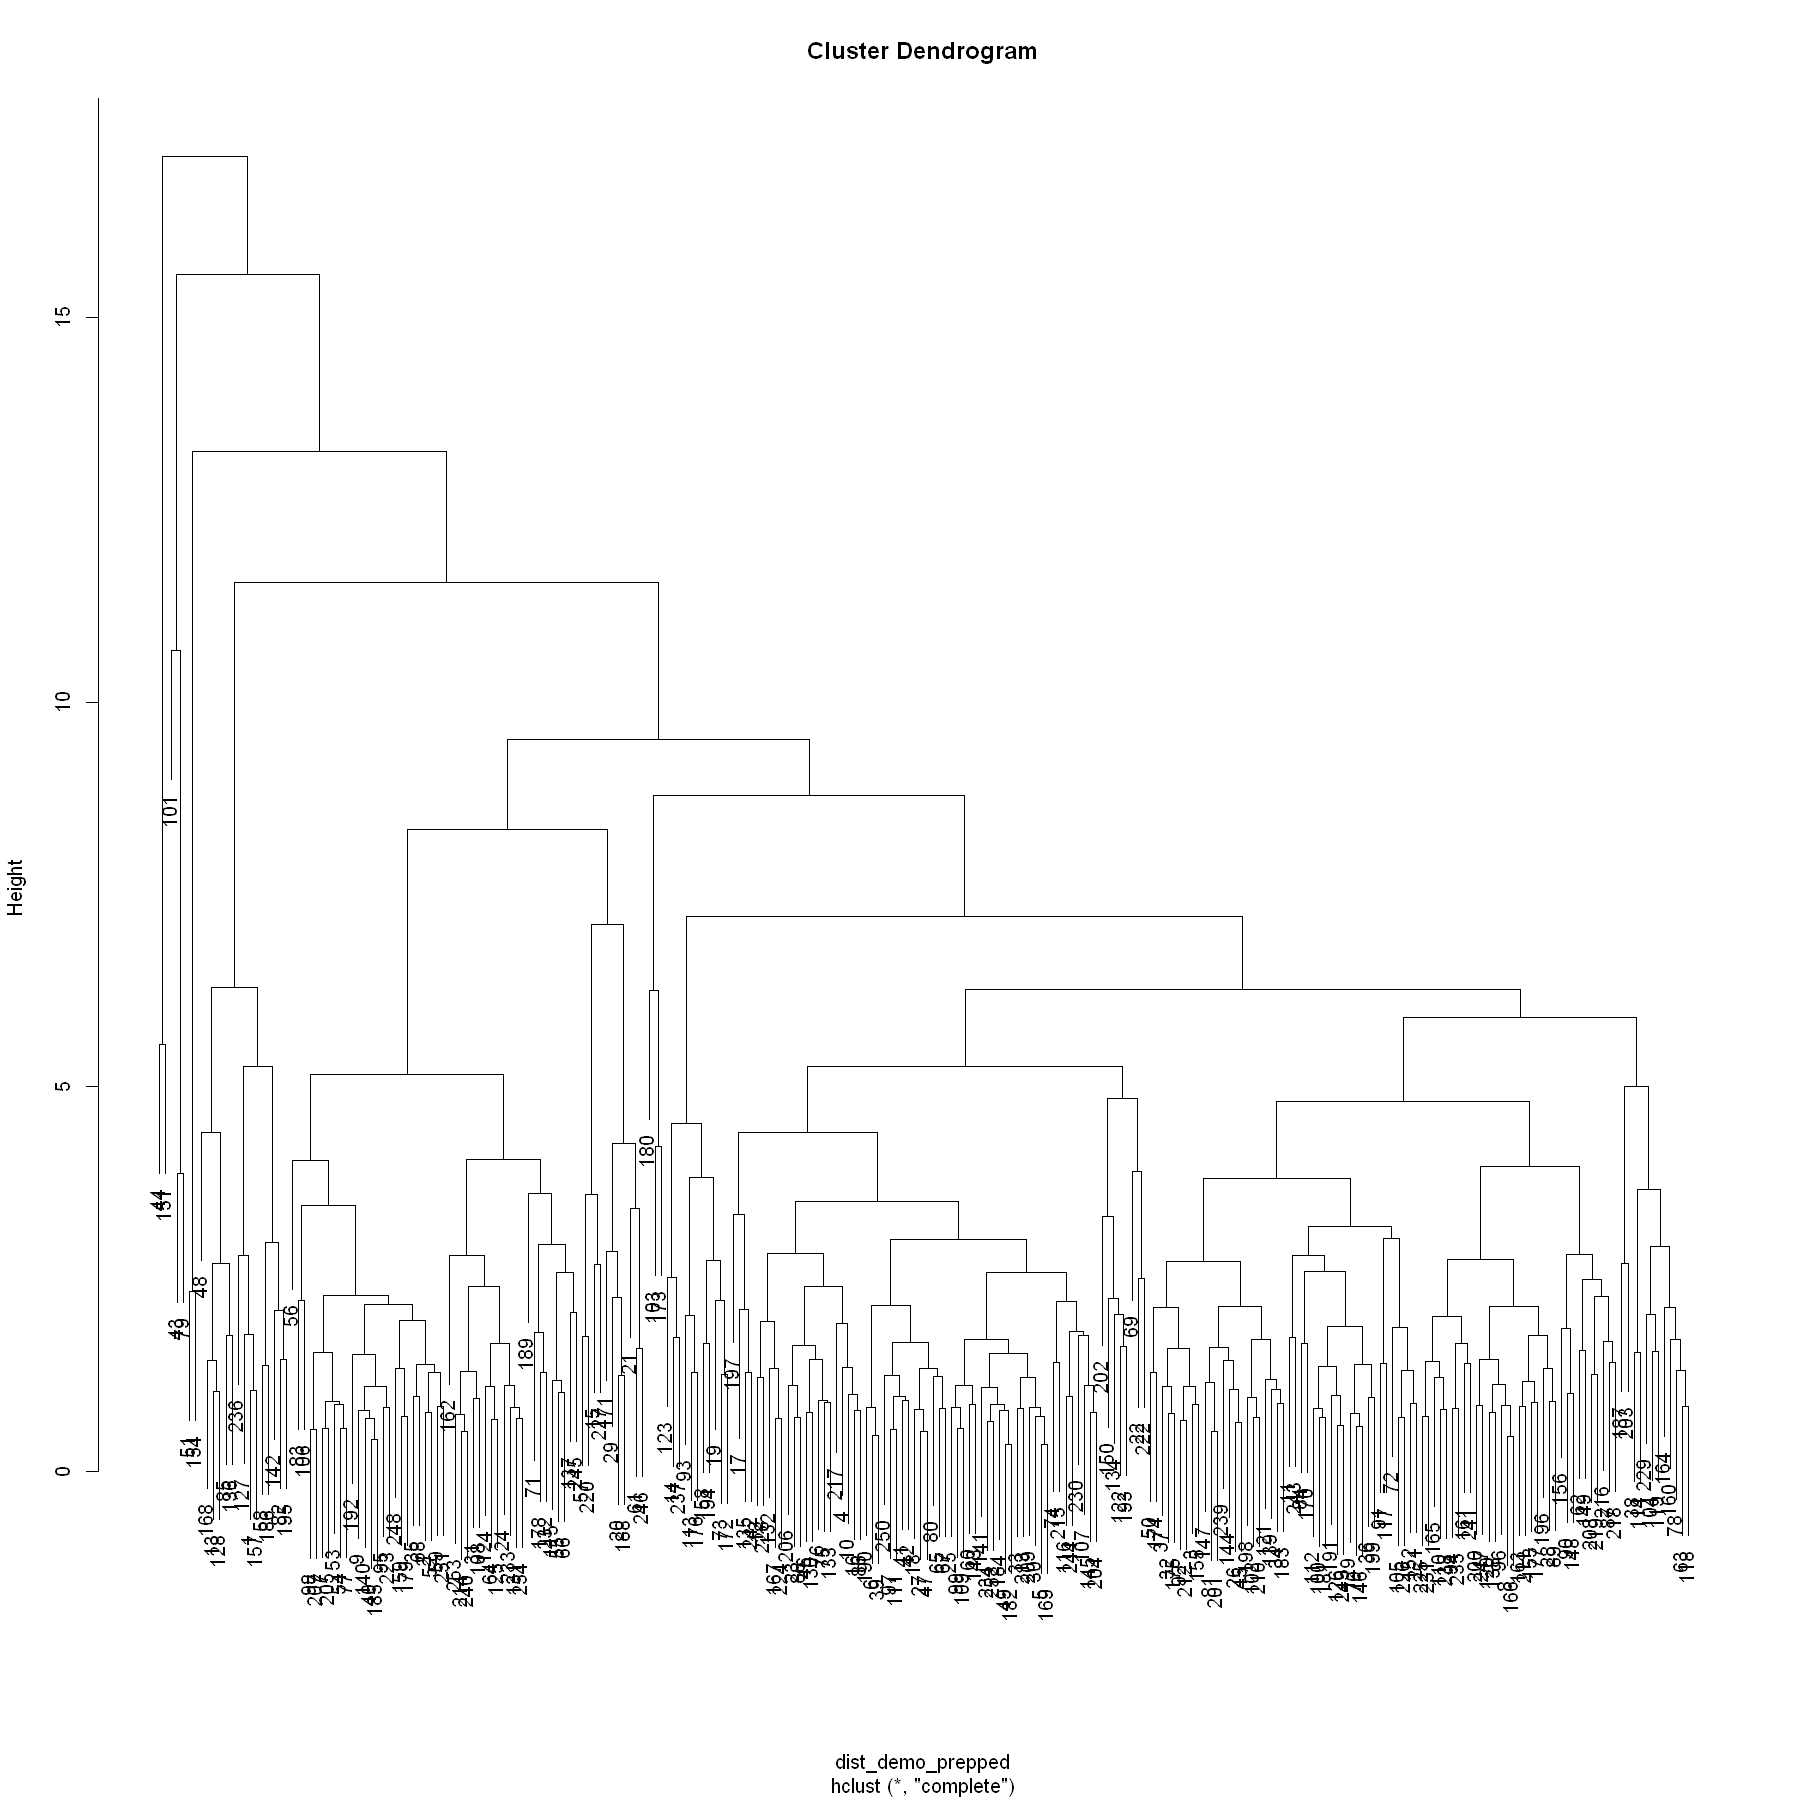

In [363]:
plot(hc)

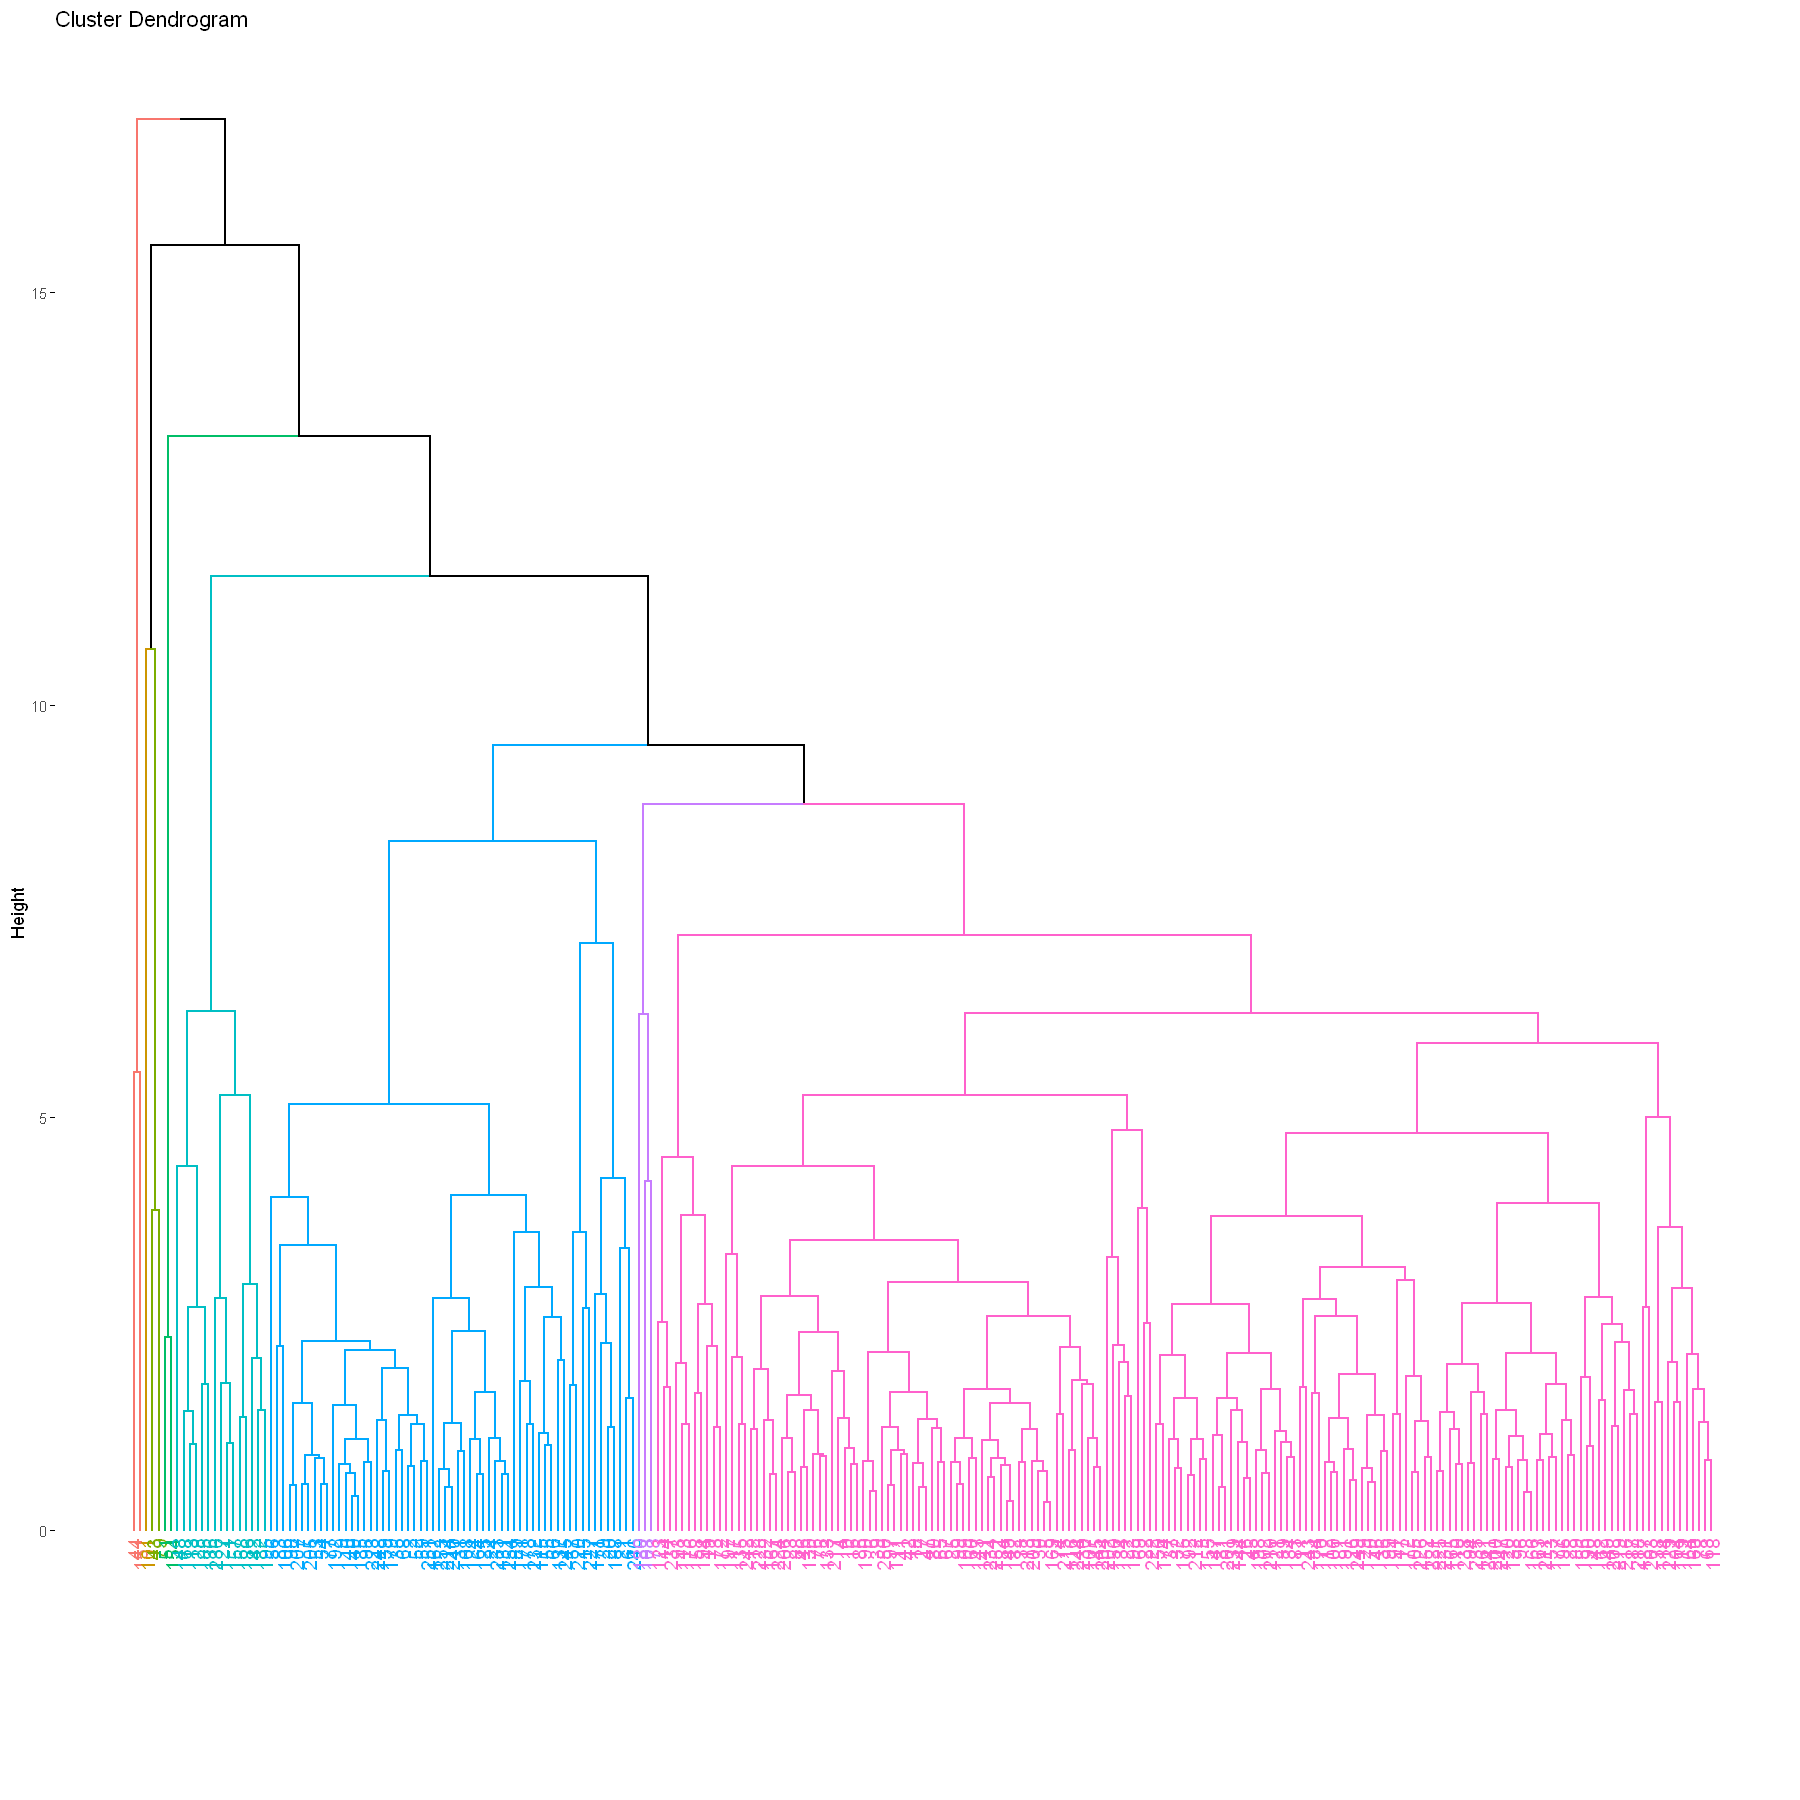

In [364]:
fviz_dend(hc, k=8)

In [365]:
h_clusters <- cutree(hc, k=8)
demo_data_hclust <- demo_data_prepped %>% add_column(cluster = factor(h_clusters))

In [366]:
counties_TX_hclust <- counties_TX %>% left_join(demo_data %>% 
    add_column(cluster = demo_data_hclust$cluster))

Joining, by = "county"


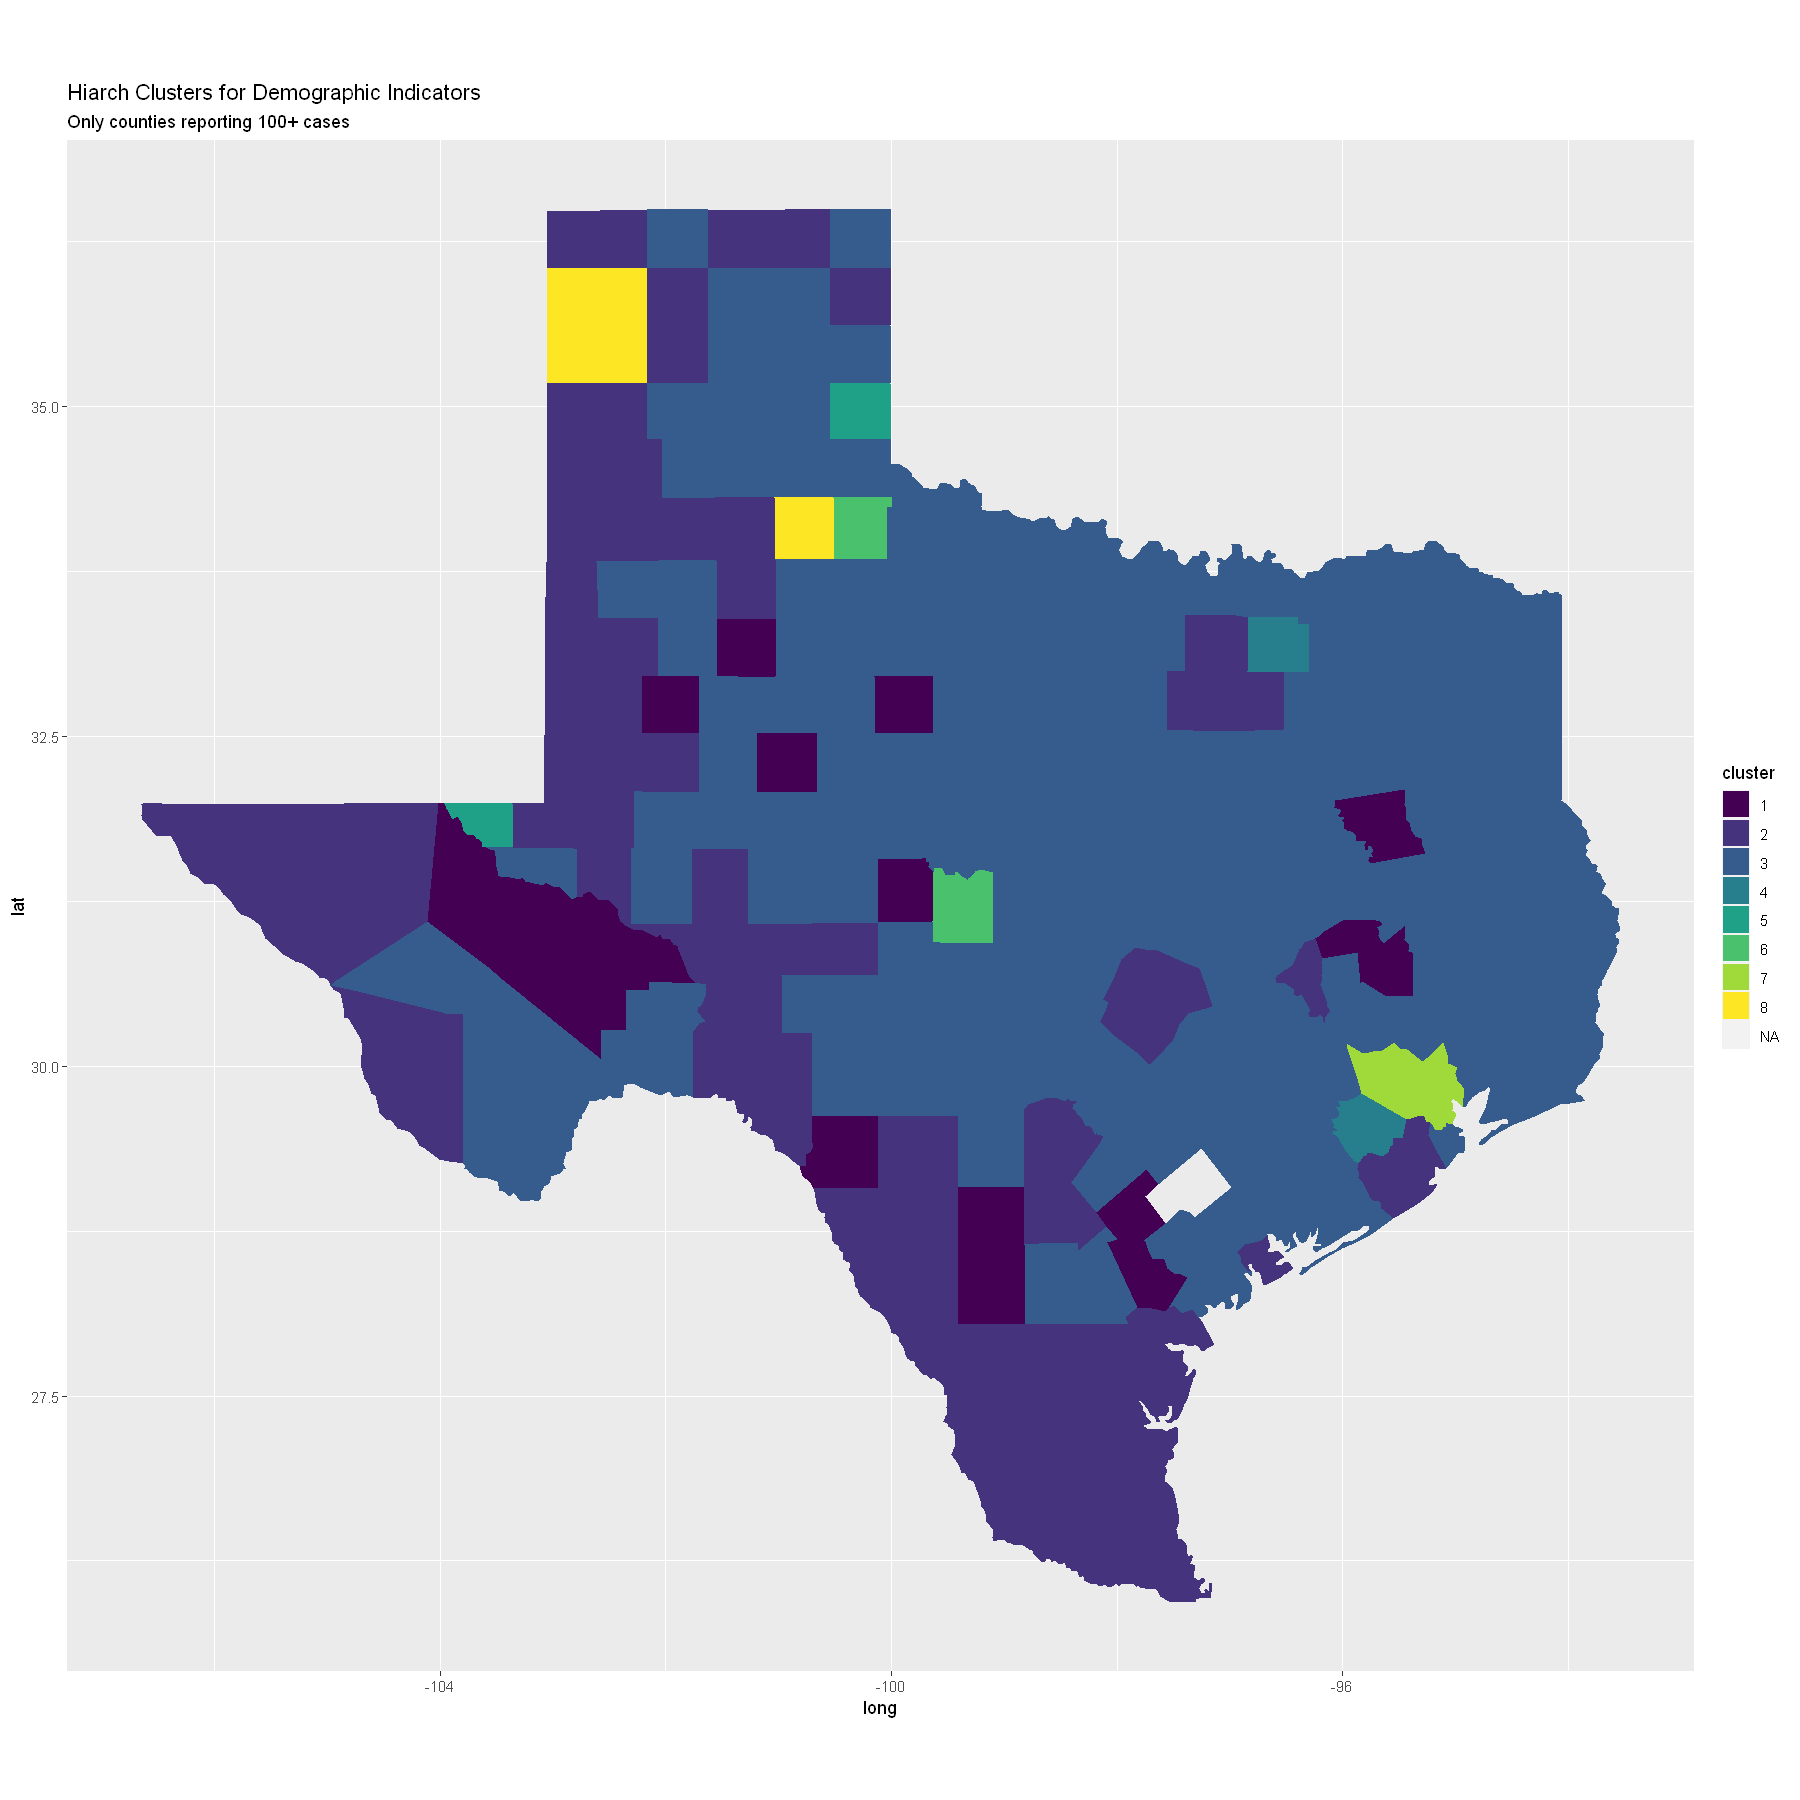

In [367]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_hclust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "Hiarch Clusters for Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

In [368]:
demo_data_dc <- demo_data %>% add_column(cluster = demo_data_hclust$cluster)

demo_data_dc %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,90.58481,1.8534023,0.022324122
2,94.52129,2.3161623,0.024977366
3,71.79703,1.6964574,0.024863565
4,66.37357,0.5727389,0.008712453
5,45.91736,1.3218771,0.016877637
6,87.41289,3.0730968,0.032734329
7,63.27584,0.8452069,0.013357499
8,68.51548,2.5291332,0.035630930


### HClust Observations
+ 1,2,6 high cases
+ 8, 4 low deaths

# Fuzzy Clustering

In [372]:
fc <- cmeans(as.matrix(demo_data_prepped), centers = 4)
fc

Fuzzy c-means clustering with 4 clusters

Cluster centers:
  hispanic_ratio  median_age bachelors_degree percent_male_pop
1    -0.61578033  0.73124703      -0.12285039     -0.313103792
2     1.22843592 -0.81040872      -0.07164055      0.005892772
3    -0.09291009 -0.04412942       0.02729744      0.299322058
4    -0.32977458 -0.05451657       0.02746050     -0.094772940
  percent_female_pop white_ratio black_ratio asian_ratio amerindian_ratio
1        0.313103792  0.76342646  -0.2558477 -0.16864608       0.10600375
2       -0.005892772 -1.14137304  -0.5224407 -0.12933020      -0.25952242
3       -0.299322058  0.03430383   0.1782800  0.06040640       0.04328666
4        0.094772940  0.18812655   0.5004757  0.08620914       0.00431444
  other_race_ratio percent_children
1       -0.1247604      -0.49478460
2       -0.1384422       0.93360848
3        0.0791948      -0.14579322
4        0.0525475      -0.05175421

Memberships:
             1          2          3          4
1   0.22379796

In [373]:
demo_data_fc <- demo_data %>% add_column(cluster = fc$membership)

In [374]:
counties_TX_fc <- counties_TX %>% left_join(demo_data_fc)

Joining, by = "county"


In [375]:
fc_clust_1 <- counties_TX_fc %>% mutate(cluster = cluster[,1])
fc_clust_2 <- counties_TX_fc %>% mutate(cluster = cluster[,2])
fc_clust_3 <- counties_TX_fc %>% mutate(cluster = cluster[,3])
fc_clust_4 <- counties_TX_fc %>% mutate(cluster = cluster[,4])

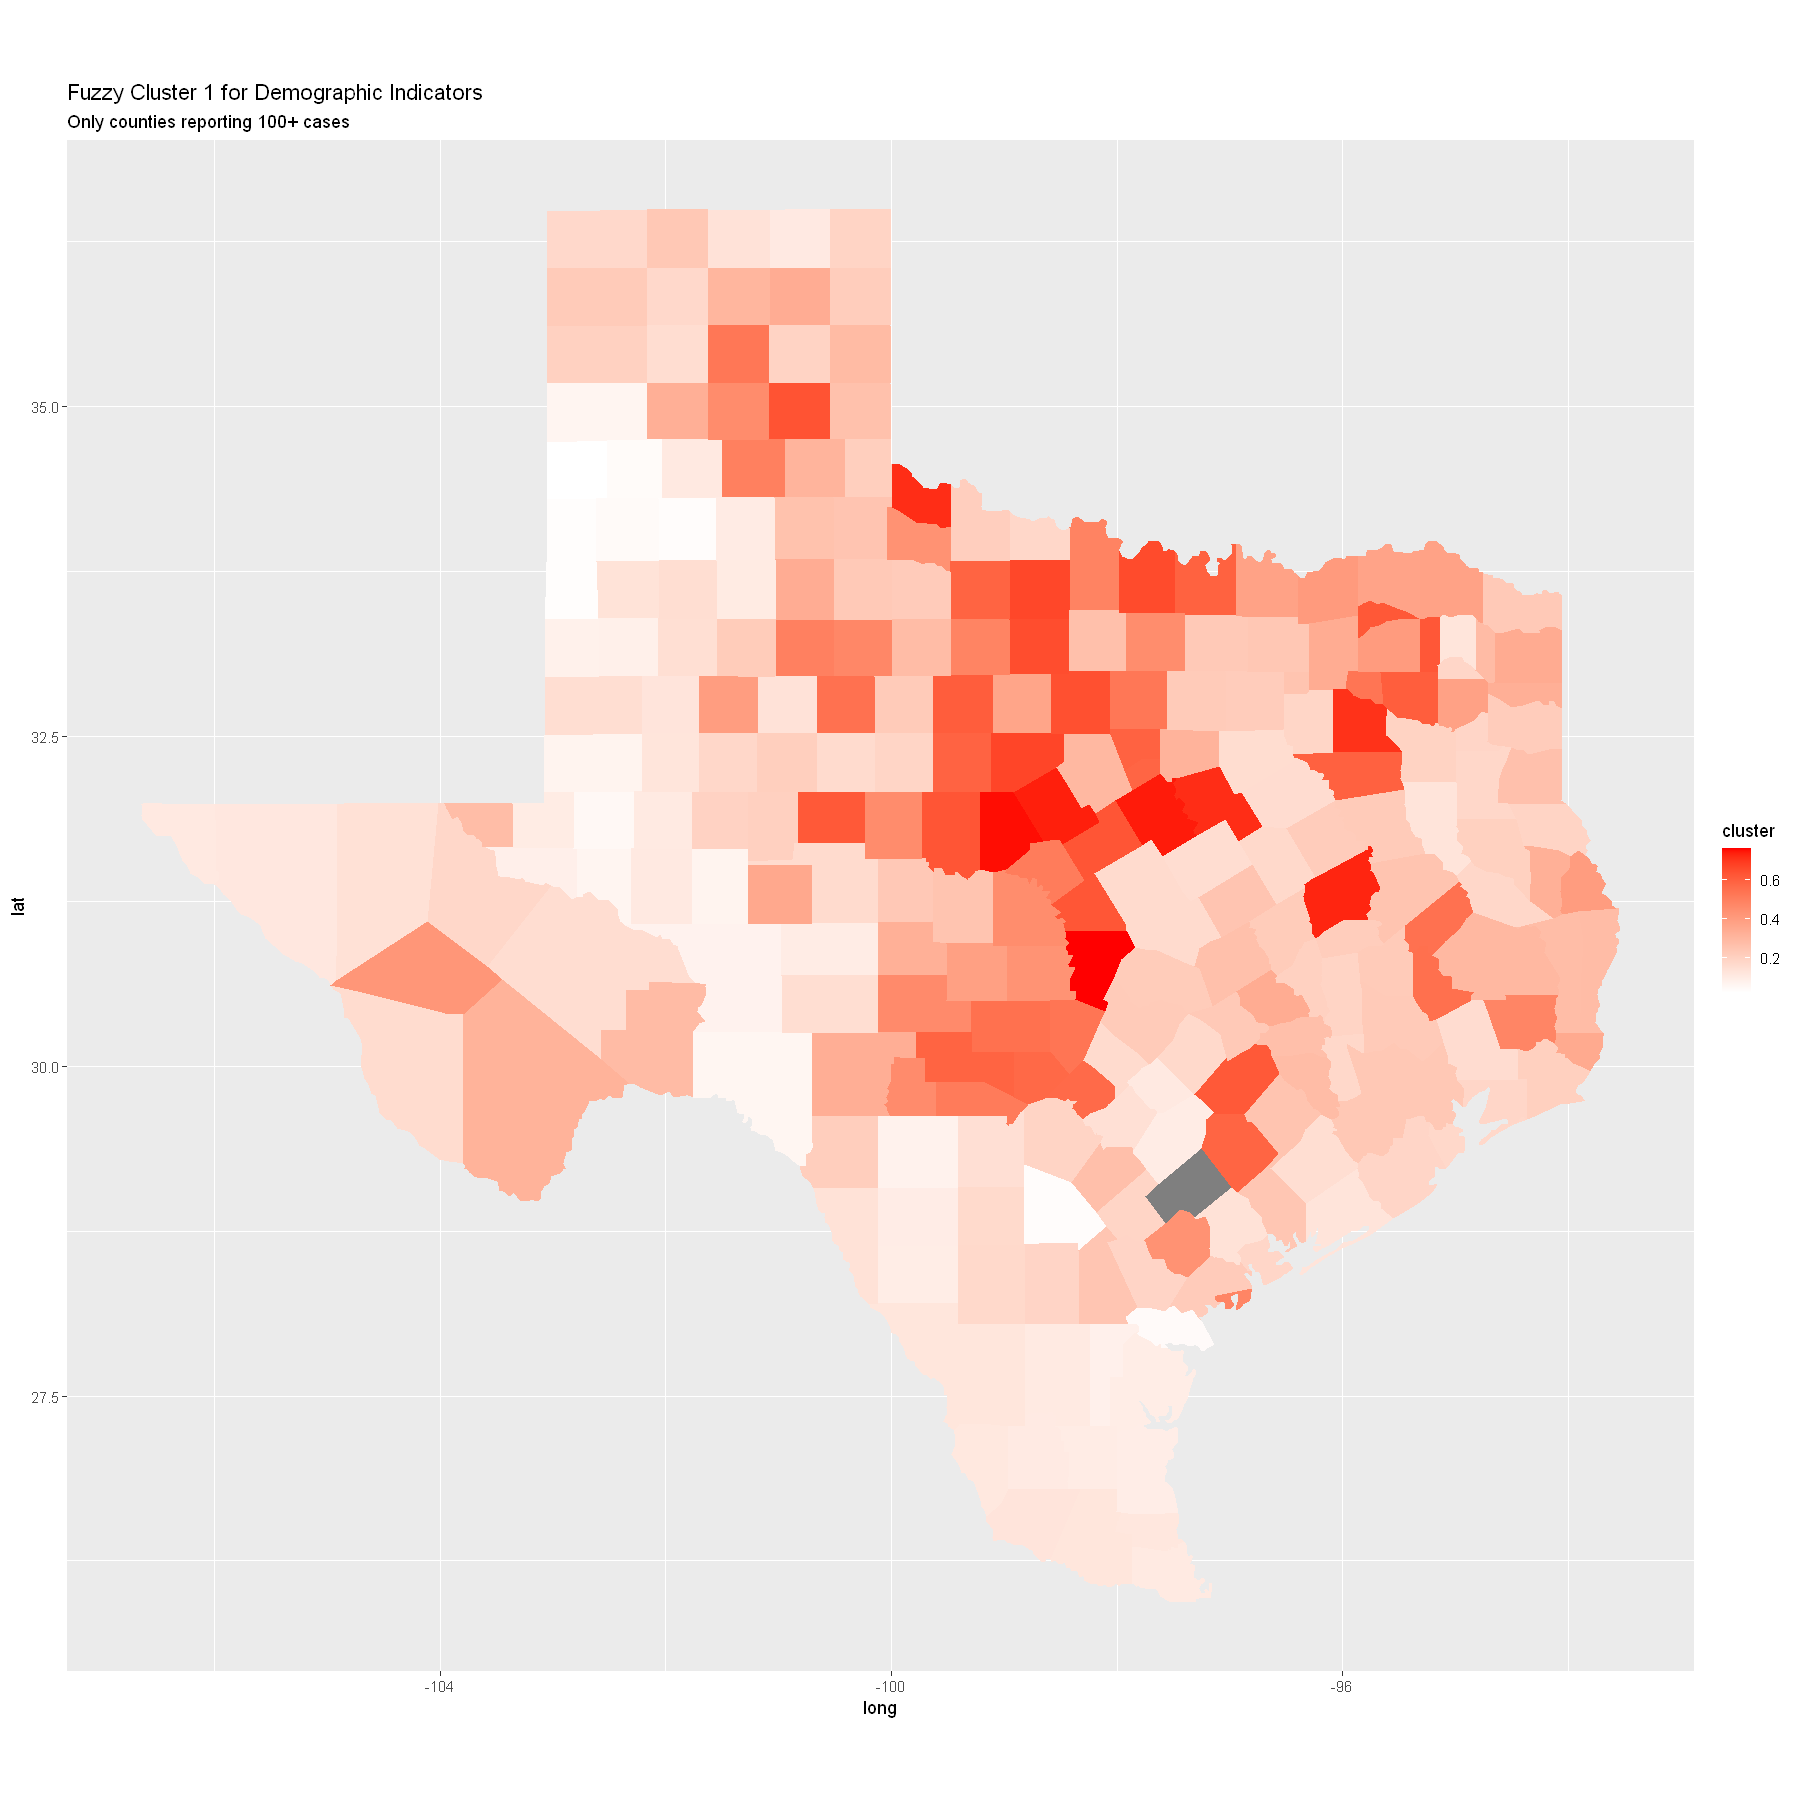

In [376]:
ggplot(fc_clust_1, aes(long, lat)) + 
  geom_polygon(data = fc_clust_1, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Fuzzy Cluster 1 for Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

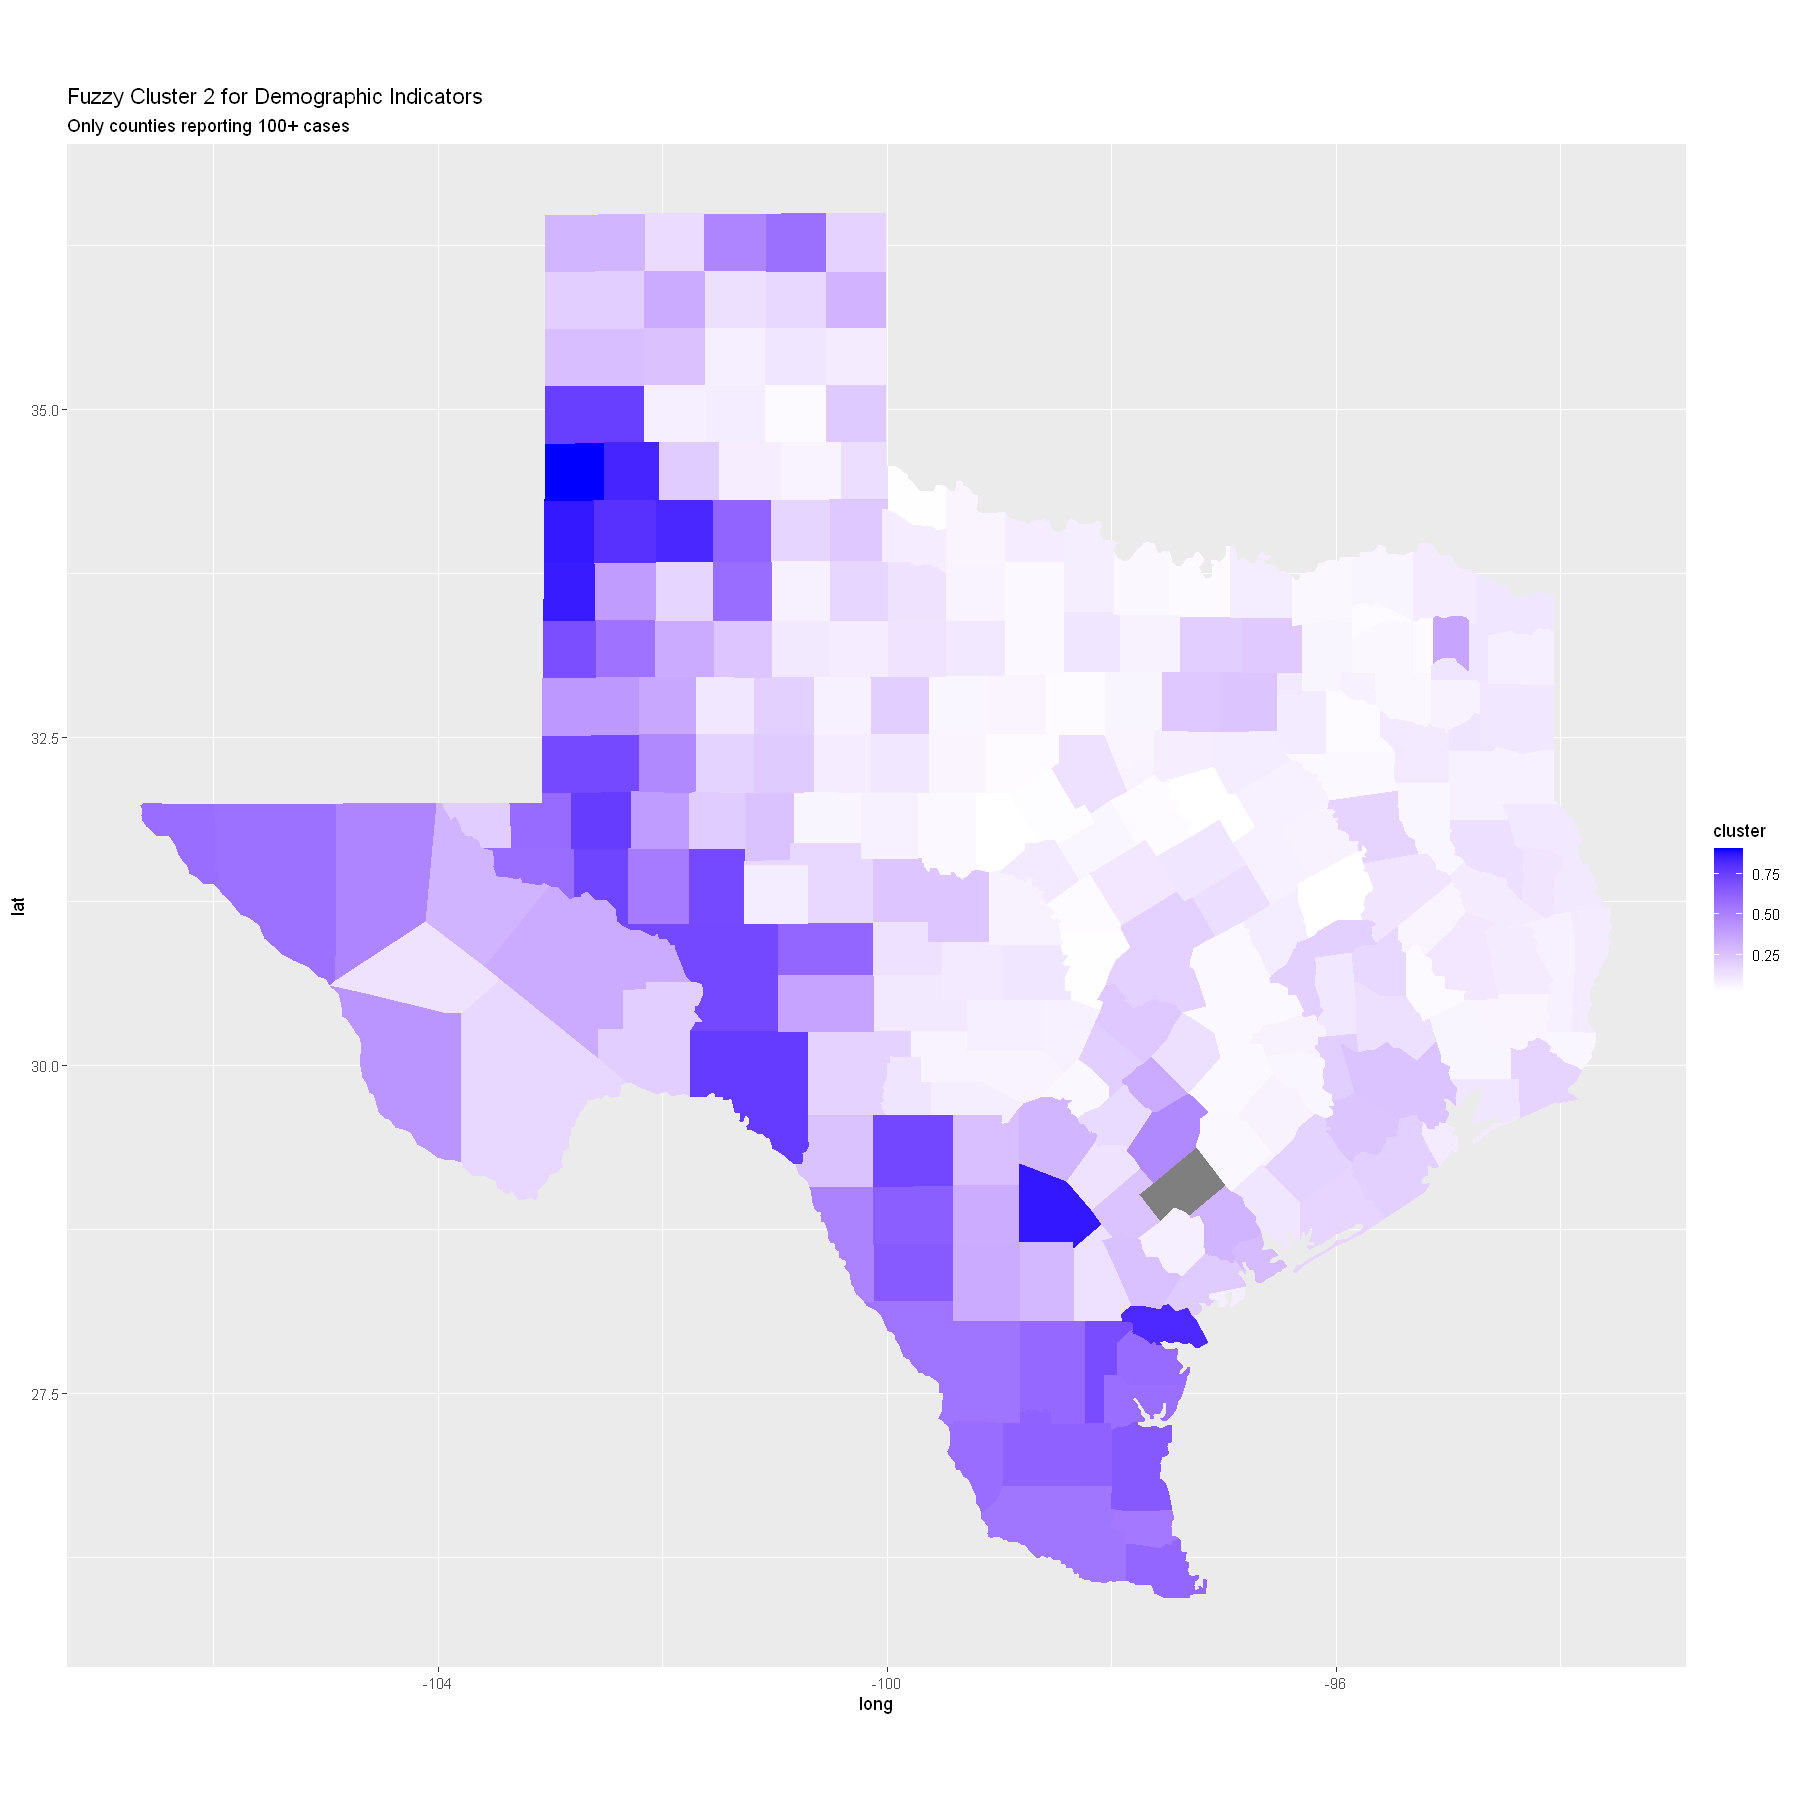

In [378]:
ggplot(fc_clust_2, aes(long, lat)) + 
  geom_polygon(data = fc_clust_2, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Fuzzy Cluster 2 for Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

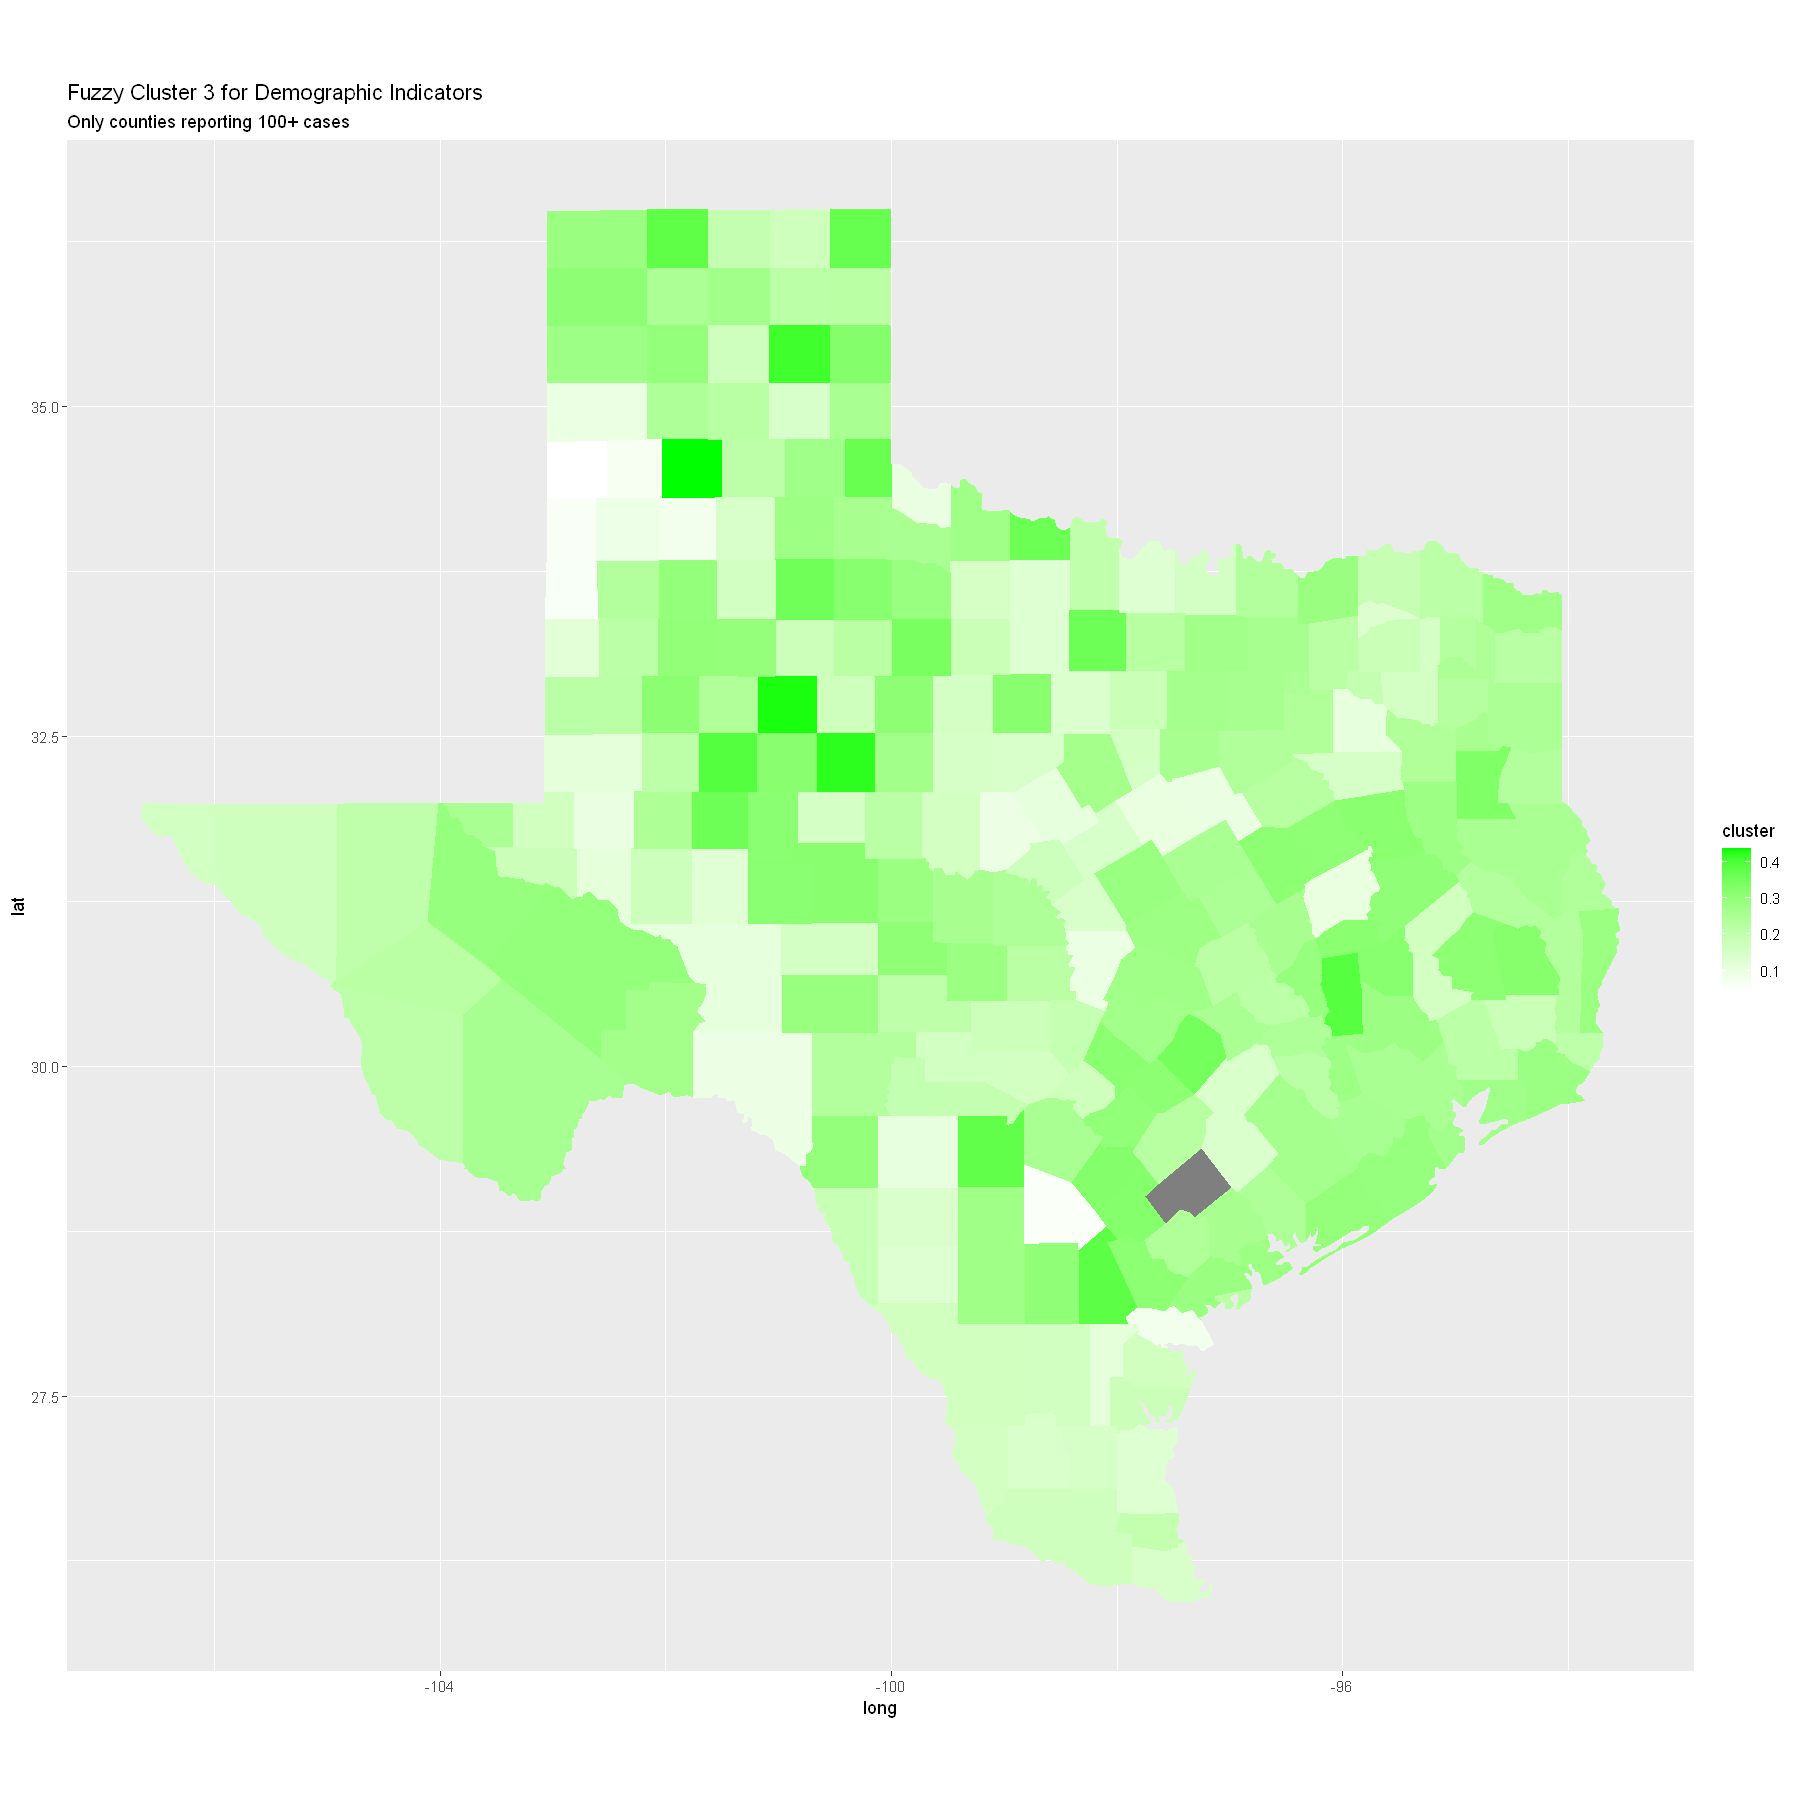

In [379]:
ggplot(fc_clust_3, aes(long, lat)) + 
  geom_polygon(data = fc_clust_3, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "green") +
  labs(title = "Fuzzy Cluster 3 for Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

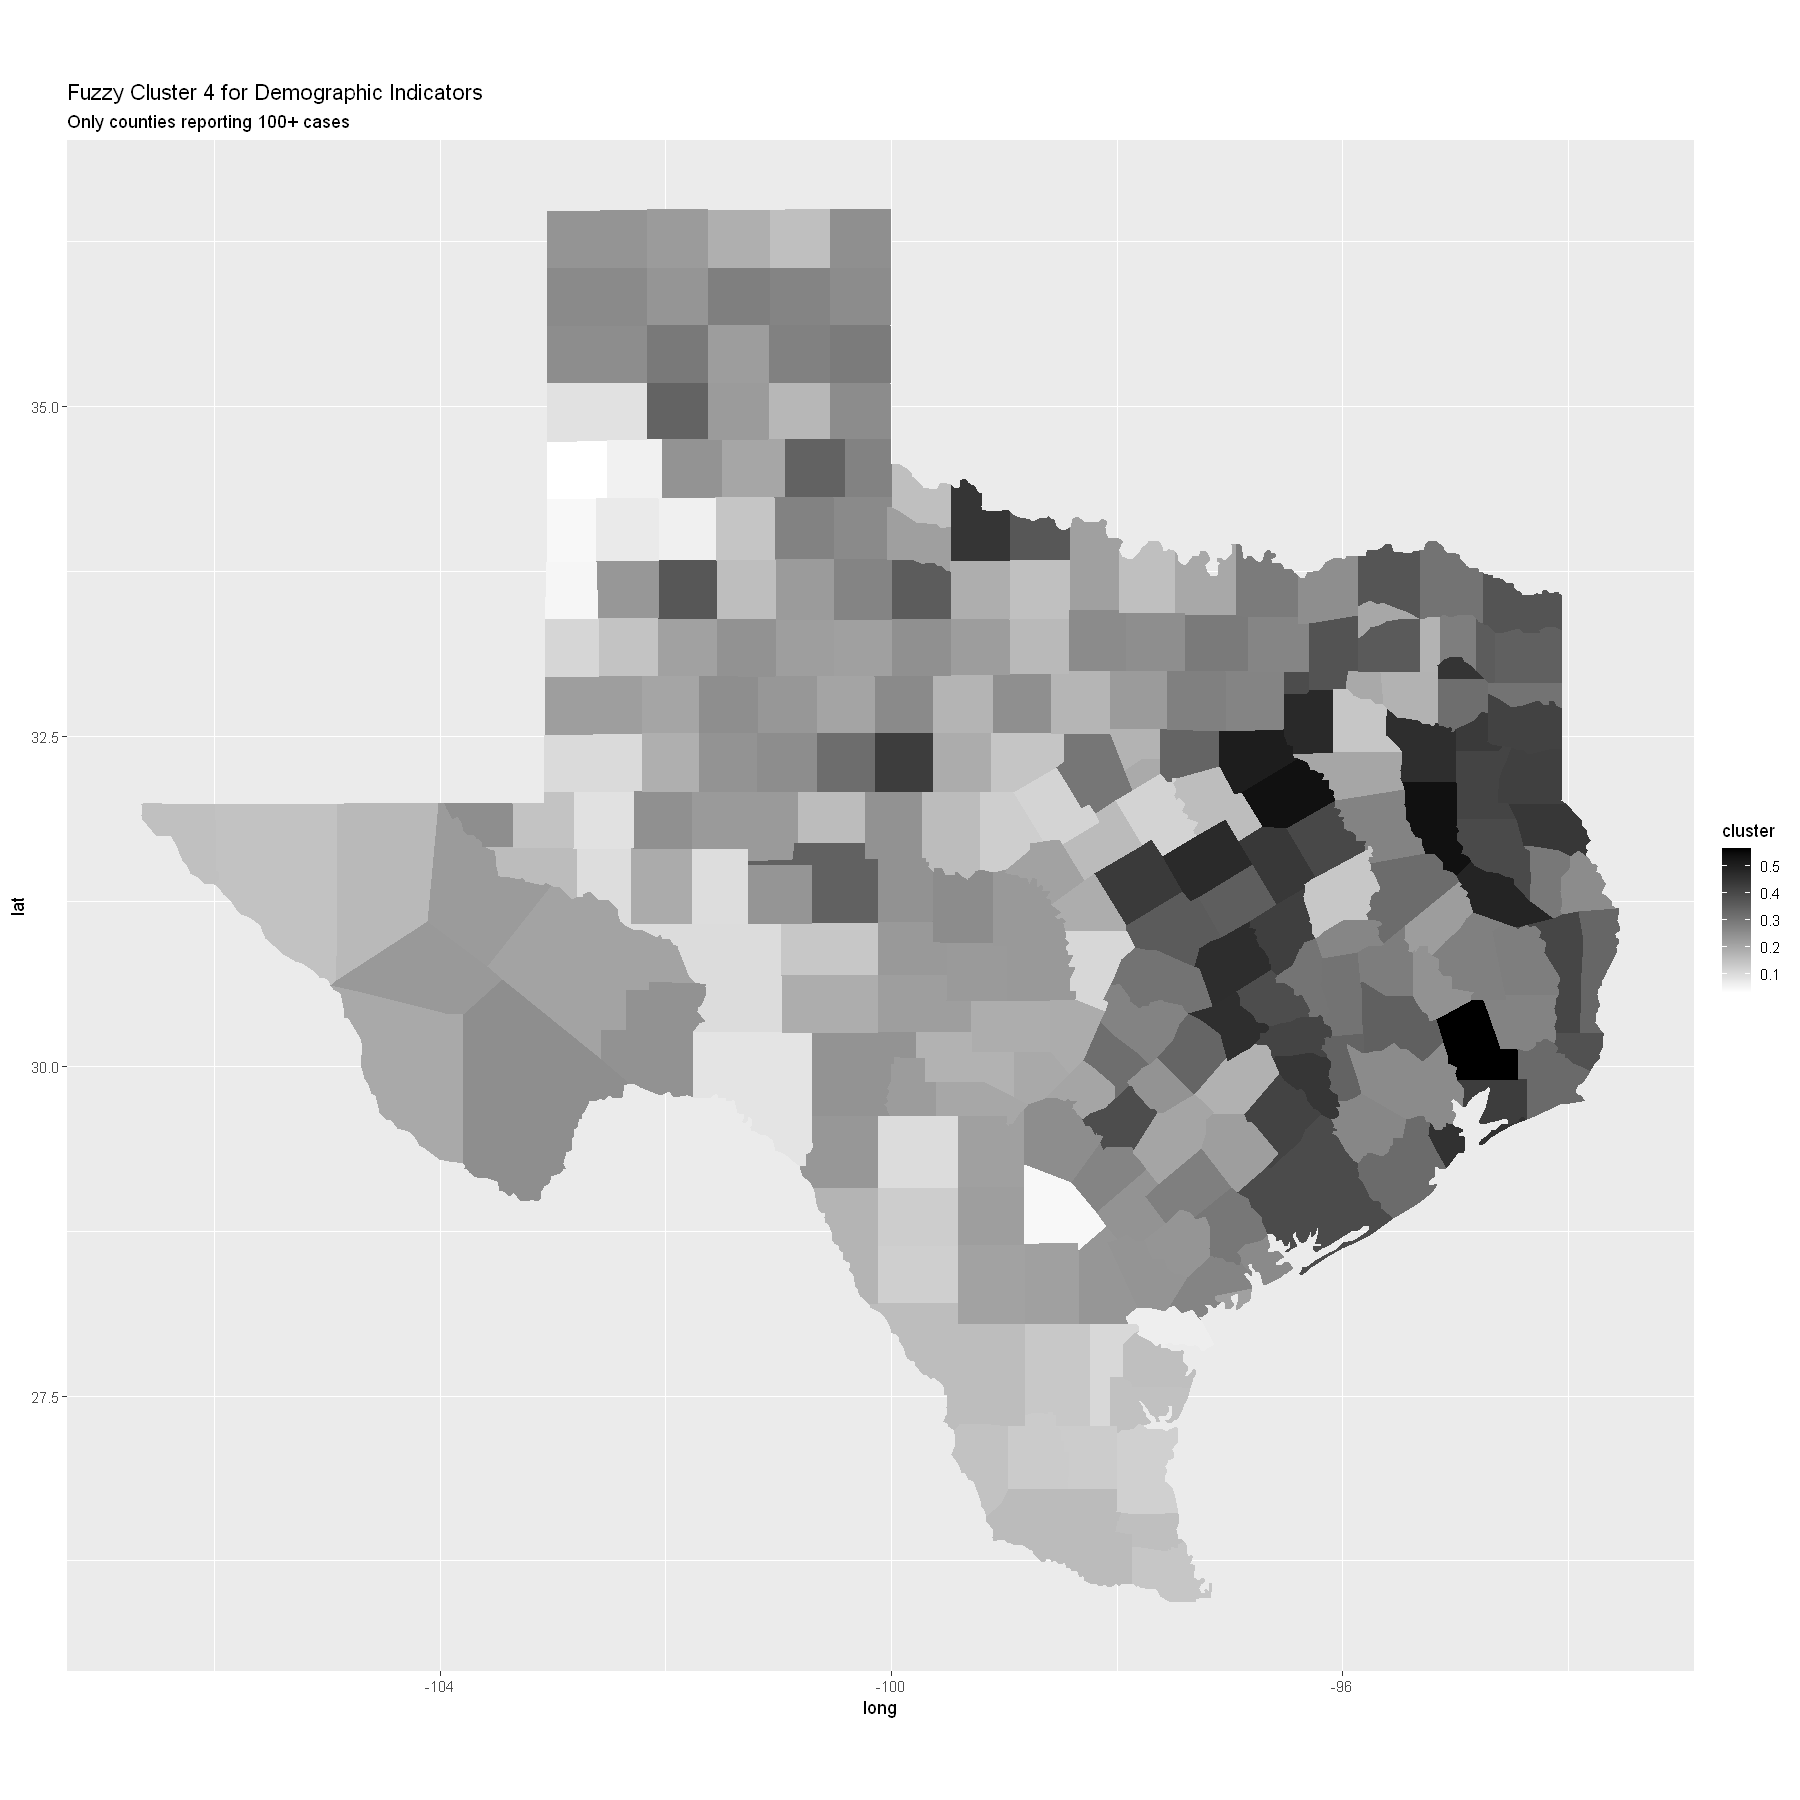

In [380]:
ggplot(fc_clust_4, aes(long, lat)) + 
  geom_polygon(data = fc_clust_4, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "black") +
  labs(title = "Fuzzy Cluster 4 for Demographic Indicators", subtitle = "Only counties reporting 100+ cases")

In [387]:
row_max_indices <- apply(fc$membership, 1, which.max)

In [392]:
demo_data_hc <- demo_data %>% add_column(cluster = row_max_indices)

demo_data_hc %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<int>,<dbl>,<dbl>,<dbl>
1,66.56043,1.727673,0.02673583
2,95.89856,2.420570,0.02594857
3,80.13787,1.986049,0.02672623
4,72.67852,1.370462,0.01977588


### Fuzzy Cluster Observations
4 has lower deaths per case

# Partitioning Around Medoids (PAM) Clustering


In [393]:
dist_demo <- dist(demo_data_prepped)

In [400]:
p <- pam(dist_demo, k=6)

In [401]:
demo_data_p <- demo_data_prepped %>% add_column(cluster = factor(p$cluster))

In [402]:
counties_TX_p <- counties_TX %>% left_join(demo_data %>% add_column(cluster = demo_data_p$cluster))

Joining, by = "county"


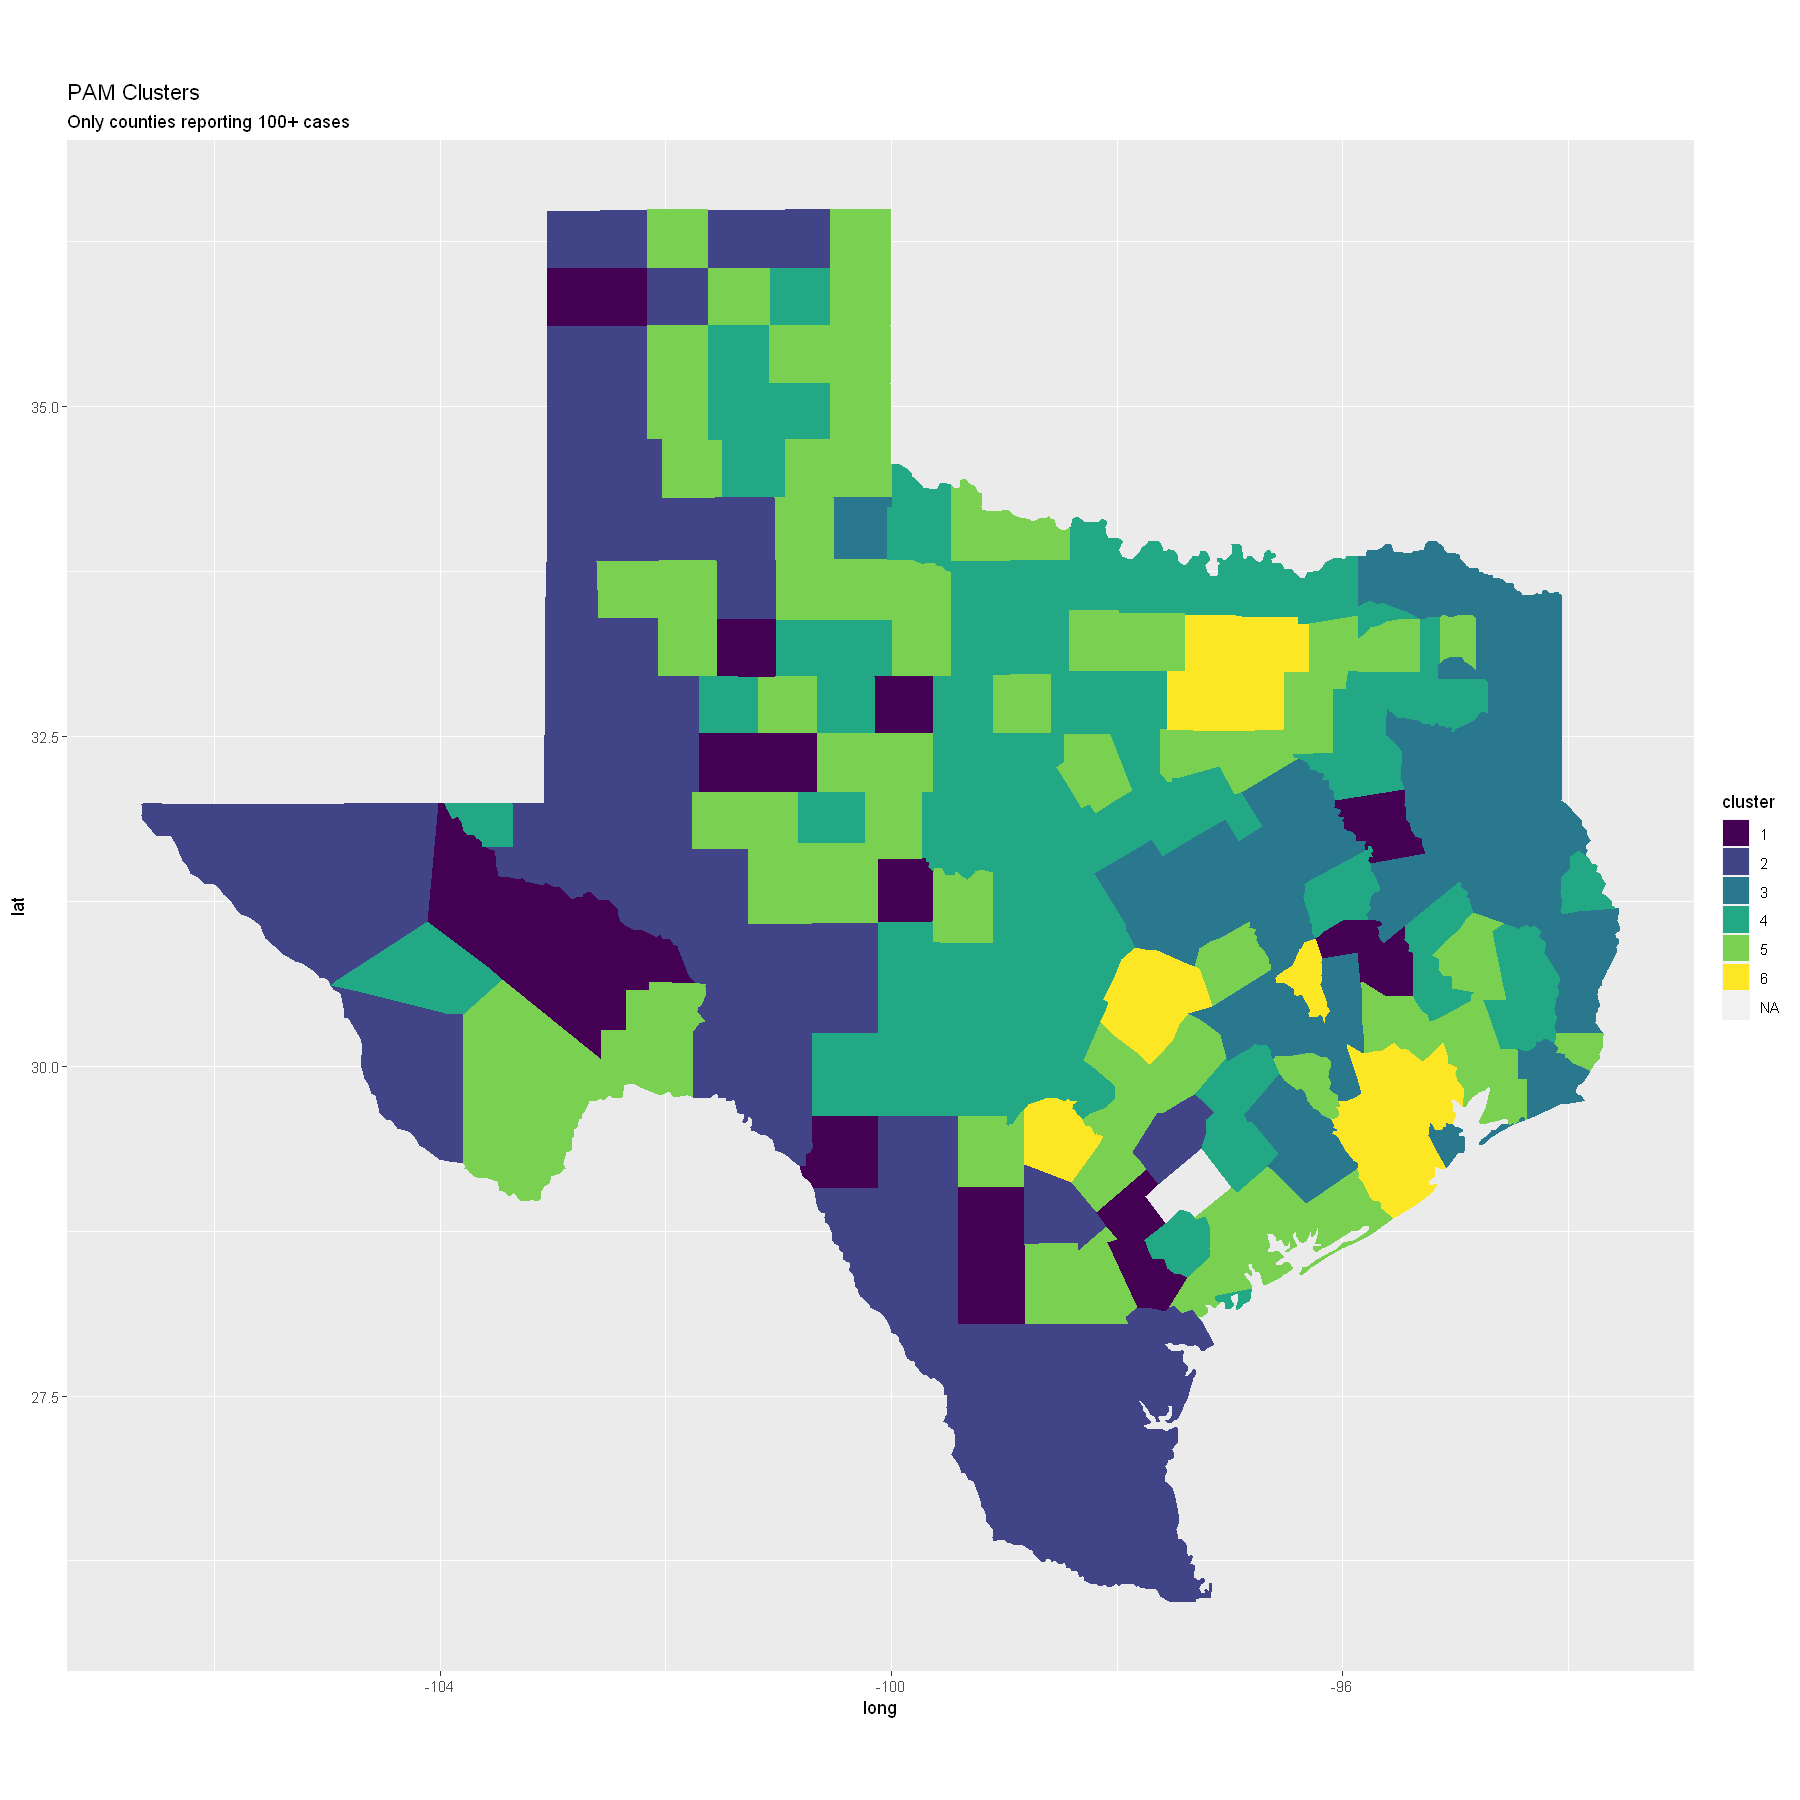

In [403]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(counties_TX_p, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_viridis_d() + 
  labs(title = "PAM Clusters", subtitle = "Only counties reporting 100+ cases")

In [404]:
demo_data_p <- demo_data %>% add_column(cluster = factor(p$cluster))

demo_data_p %>% group_by(cluster) %>% summarize(
  avg_cases = mean(cases_per_1000), 
  avg_deaths = mean(deaths_per_1000),
avg_deaths_per_case = mean(death_per_case))

cluster,avg_cases,avg_deaths,avg_deaths_per_case
<fct>,<dbl>,<dbl>,<dbl>
1,87.99641,1.6127499,0.02015863
2,96.84889,2.5405201,0.02710684
3,63.62517,1.6567932,0.02700799
4,65.32981,1.6651095,0.02579769
5,82.44806,1.8418580,0.02368562
6,71.81667,0.7378485,0.01026435


### PAM Observations
+ 6 has less deaths per case
+ interesting how the demo PAM looks similar to the social economic PAM